# Eli Ordonez – Capstone Project

This document is an account of everything I did in Python for my capstone project, encompassing all data cleaning, handling, analysis, modelling and even API calling. 

In this project, I will build a model that can predict the daily composition of Japan's Spotify Top 50 based on each day's weather data. I chose to work with an East Asian country rather than a Southeast Asian one as East Asian countries have greater seasonal variation, which might make for a more well-defined model. 

In [1]:
import requests
import pandas as pd
import time
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from scipy.stats import chi2_contingency
from IPython.display import display
from matplotlib.gridspec import GridSpec
from pandas.api.types import is_numeric_dtype
import statsmodels.api as sm
import shap
from catboost import CatBoostRegressor

## Part 1: Looking at Japanese Weather Data

Firstly, I will explore the dataset I have gathered for Japan's weather. It was obtained from [Open-Meteo](https://open-meteo.com/), a free meteorological aggregator which offers historical weather data from Tokyo, Japan. 

While the Spotify dataset does feature Top 50 song data from Japan, it does not specify the popularity of the songs per region or prefecture. As a result, I have decided to arbitrarily choose Tokyo as a geographical representation of Japan. As Tokyo is Japan's capital, it is likely that there is a high concentration of Spotify users in the city compared to other, less populated regions of Japan. Thus, listening patterns in Tokyo are likely to reflect general listening patterns across the whole of Japan.

Here are more details about the weather dataset from Japan:
1. Coordinates-wise, Japan is defined as 35.6766, 139.8069 in this dataset
2. It includes the following data:<br>
&nbsp;• Min, Max & Mean Temperature (2m)<br>
&nbsp;• Rain sum (cm), snowfall sum(mm), precipitaion sum(rain+snow)(mm)<br>
&nbsp;• Min, Max & Mean Relative Humidity (2m)<br>
&nbsp;• Min, Max & Mean Wind Speed (10m)<br>
&nbsp;• Daylight Duration (s)<br>
&nbsp;• Sunrise, Sunset (iso8601)<br>
3. It contains 561 days' worth of data, from 2023-10-18 to 2025-04-30

### 1.1 Data Cleaning & Checks

In [1483]:
tokyo_wea = pd.read_csv("/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/(USE THIS) Tokyo Weather/tokyo (2023-10-18 to 2025-04-30, Final).csv")
tokyo_wea.head()

time  temperature_2m_max (°C)  temperature_2m_min (°C)  \
0  2023-10-18T00:00                     23.6                     12.8   
1  2023-10-19T00:00                     24.3                     12.7   
2  2023-10-20T00:00                     25.2                     14.8   
3  2023-10-21T00:00                     21.1                     13.8   
4  2023-10-22T00:00                     18.6                      9.9   

   temperature_2m_mean (°C)  rain_sum (mm)  snowfall_sum (cm)  \
0                      17.8            0.0                0.0   
1                      18.8            0.0                0.0   
2                      20.2            0.0                0.0   
3                      17.5            0.0                0.0   
4                      14.7            0.0                0.0   

   precipitation_sum (mm)  relative_humidity_2m_max (%)  \
0                     0.0                            91   
1                     0.0                           100   
2                     0.0                            90   
3                     0.0                            73   
4                     0.0                            85   

   relative_humidity_2m_min (%)  relative_humidity_2m_mean (%)  \
0                            47                             72   
1                            51                             78   
2                            57                             75   
3                            48                             58   
4                            39                             60   

   wind_speed_10m_max (km/h)  wind_speed_10m_min (km/h)  \
0                       15.5                        2.4   
1                       24.2                        4.2   
2                       45.6                        7.0   
3                       31.6                        4.5   
4                       25.8                        4.4   

   wind_speed_10m_mean (km/h)  daylight_duration (s) sunrise (iso8601)  \
0                        11.0               40391.20  2023-10-18T05:49   
1                        12.2               40261.54  2023-10-19T05:50   
2                        23.7               40132.71  2023-10-20T05:51   
3                        19.2               40004.85  2023-10-21T05:52   
4                        14.9               39878.03  2023-10-22T05:52   

   sunset (iso8601)  
0  2023-10-18T17:02  
1  2023-10-19T17:01  
2  2023-10-20T17:00  
3  2023-10-21T16:58  
4  2023-10-22T16:57

In [1485]:
# Let's check for any duplicate rows of data
tokyo_wea.duplicated().sum()

0

In [1487]:
# Let's check for any null values
tokyo_wea.isnull().sum()

time                             0
temperature_2m_max (°C)          0
temperature_2m_min (°C)          0
temperature_2m_mean (°C)         0
rain_sum (mm)                    0
snowfall_sum (cm)                0
precipitation_sum (mm)           0
relative_humidity_2m_max (%)     0
relative_humidity_2m_min (%)     0
relative_humidity_2m_mean (%)    0
wind_speed_10m_max (km/h)        0
wind_speed_10m_min (km/h)        0
wind_speed_10m_mean (km/h)       0
daylight_duration (s)            0
sunrise (iso8601)                0
sunset (iso8601)                 0
dtype: int64

In [1489]:
# Let's check the datatypes of each column
tokyo_wea.dtypes

time                              object
temperature_2m_max (°C)          float64
temperature_2m_min (°C)          float64
temperature_2m_mean (°C)         float64
rain_sum (mm)                    float64
snowfall_sum (cm)                float64
precipitation_sum (mm)           float64
relative_humidity_2m_max (%)       int64
relative_humidity_2m_min (%)       int64
relative_humidity_2m_mean (%)      int64
wind_speed_10m_max (km/h)        float64
wind_speed_10m_min (km/h)        float64
wind_speed_10m_mean (km/h)       float64
daylight_duration (s)            float64
sunrise (iso8601)                 object
sunset (iso8601)                  object
dtype: object

In [1491]:
# Let's convert the date/time-related columns to datetime format
tokyo_wea['time'] = pd.to_datetime(tokyo_wea['time'])
tokyo_wea['sunrise (iso8601)'] = pd.to_datetime(tokyo_wea['sunrise (iso8601)'])
tokyo_wea['sunset (iso8601)'] = pd.to_datetime(tokyo_wea['sunset (iso8601)'])
tokyo_wea.dtypes

time                             datetime64[ns]
temperature_2m_max (°C)                 float64
temperature_2m_min (°C)                 float64
temperature_2m_mean (°C)                float64
rain_sum (mm)                           float64
snowfall_sum (cm)                       float64
precipitation_sum (mm)                  float64
relative_humidity_2m_max (%)              int64
relative_humidity_2m_min (%)              int64
relative_humidity_2m_mean (%)             int64
wind_speed_10m_max (km/h)               float64
wind_speed_10m_min (km/h)               float64
wind_speed_10m_mean (km/h)              float64
daylight_duration (s)                   float64
sunrise (iso8601)                datetime64[ns]
sunset (iso8601)                 datetime64[ns]
dtype: object

In [1493]:
tokyo_wea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   time                           561 non-null    datetime64[ns]
 1   temperature_2m_max (°C)        561 non-null    float64       
 2   temperature_2m_min (°C)        561 non-null    float64       
 3   temperature_2m_mean (°C)       561 non-null    float64       
 4   rain_sum (mm)                  561 non-null    float64       
 5   snowfall_sum (cm)              561 non-null    float64       
 6   precipitation_sum (mm)         561 non-null    float64       
 7   relative_humidity_2m_max (%)   561 non-null    int64         
 8   relative_humidity_2m_min (%)   561 non-null    int64         
 9   relative_humidity_2m_mean (%)  561 non-null    int64         
 10  wind_speed_10m_max (km/h)      561 non-null    float64       
 11  wind_speed_10m_min 

In [513]:
# For backup's sake, let's save this cleaned dataset as a csv file
tokyo_wea.to_csv('tokyo_wea.csv')

### 1.2 Exploratory Data Analysis

In [14]:
# Let's look at how temperature has changed over the 561-day period
tokyo_temp = pd.DataFrame({
    'day': tokyo_wea['time'],
    'mean_temp': tokyo_wea['temperature_2m_mean (°C)']
})
px.line(tokyo_temp,x='day',y='mean_temp',title='Temperature is lowest in Jan and highest in Jul/Aug')

In [15]:
# How about precipitation?
tokyo_prec_daily = pd.DataFrame({
    'day': tokyo_wea['time'],
    'total_precipitation': tokyo_wea['precipitation_sum (mm)'],
})
px.line(tokyo_prec_daily,x='day',y='total_precipitation',title='Daily Precipitation')

In [16]:
# Let's see if precipitation by week can reveal to us a more distinct pattern. 
# NOTE: dt.to_period('W') will give us a range of dates, which px can't read. dt.start_time converts the range to the start of the week in datetime.
tokyo_prec_weekly = pd.DataFrame({
    'weekly_precipitation': tokyo_wea.groupby(tokyo_wea['time'].dt.to_period('W').dt.start_time)['precipitation_sum (mm)'].sum()
})
tokyo_prec_weekly = (tokyo_prec_weekly.reset_index()
                     .rename(columns={'time': 'week'}))
px.line(tokyo_prec_weekly,x='week',y='weekly_precipitation',title='Weekly Precipitation')

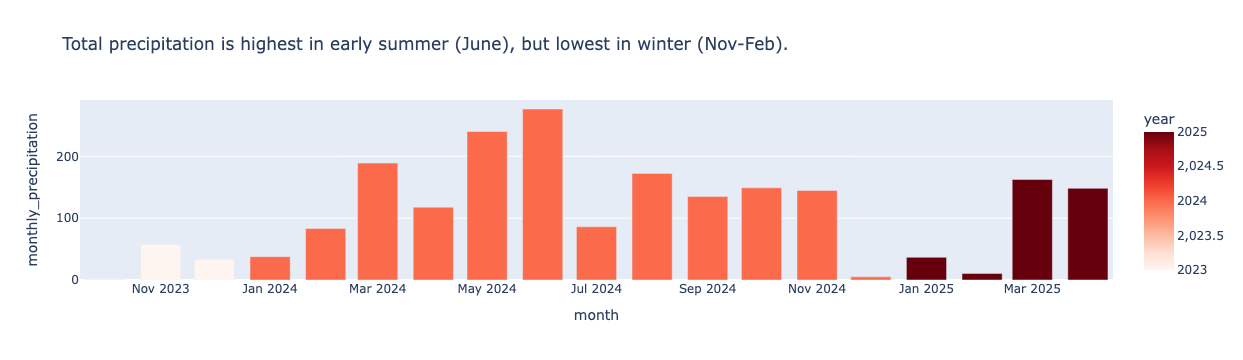

In [1516]:
tokyo_prec_monthly = pd.DataFrame({
    'monthly_precipitation': tokyo_wea.groupby(tokyo_wea['time'].dt.to_period('M').dt.start_time)['precipitation_sum (mm)'].sum(),
    'monthly_rainfall': tokyo_wea.groupby(tokyo_wea['time'].dt.to_period('M').dt.start_time)['rain_sum (mm)'].sum(),
    'monthly_snowfall': tokyo_wea.groupby(tokyo_wea['time'].dt.to_period('M').dt.start_time)['snowfall_sum (cm)'].sum()
})
tokyo_prec_monthly = (tokyo_prec_monthly.reset_index()
                     .rename(columns={'time': 'month'}))
tokyo_prec_monthly['year'] = tokyo_prec_monthly['month'].dt.year
tokyo_prec_monthly
px.bar(tokyo_prec_monthly,x='month',y='monthly_precipitation',color='year',color_continuous_scale=px.colors.sequential.Reds,title='Total precipitation is highest in early summer (June), but lowest in winter (Nov-Feb).',width=1000)

In [18]:
px.bar(tokyo_prec_monthly,x='month',y='monthly_snowfall',color='year',color_continuous_scale=px.colors.sequential.Reds,title='Snowfall is highest at the end of winter (March)')

In [19]:
# Is there any pattern in terms of relative humidity?
tokyo_rh = pd.DataFrame({
    'date': tokyo_wea['time'],
    'rel_humidity': tokyo_wea['relative_humidity_2m_mean (%)']
})
px.line(tokyo_rh,x='date',y='rel_humidity',title='There is no clear pattern in relative humidity throughout the data time range')

In [20]:
# How about wind speed?
tokyo_ws = pd.DataFrame({
    'date': tokyo_wea['time'],
    'mean_wind_speed': tokyo_wea['wind_speed_10m_mean (km/h)'],
})
px.line(tokyo_ws,x='date',y='mean_wind_speed',title='There is no clear pattern in mean wind speed throughout the data time range')

In [21]:
# Finally, let's see if there is any real variation in daylight duration
tokyo_day = pd.DataFrame({
    'date': tokyo_wea['time'],
    'daylight (s)': tokyo_wea['daylight_duration (s)']
})
px.line(tokyo_day,x='date',y='daylight (s)',title='There is a very clear correlation between sunlight duration and time of year')

Based on my EDA, I can conclude that the weather metrics with the most pronounced general trends over time are:<br>
&nbsp;• **Temperature**<br>
&nbsp;• **Sunlight Duration**<br>
&nbsp;• **Precipitation**<br>

## Part 2: Looking into Japan's Spotify Data

In [778]:
# Now, let's create a copy of the dataset, but only filtered to include Japan's 
spotify_data = pd.read_csv("/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/(USE THIS) Kaggle Dataset/universal_top_spotify_songs 2.csv",encoding='utf-8')
jp_spotify_data = spotify_data[spotify_data['country'] == 'JP'].reset_index()
jp_spotify_data = jp_spotify_data.copy()

In [780]:
jp_spotify_data

index              spotify_id         name              artists  \
0         1819  3huSUfmhUr4entz2S0G31O         クスシキ     Mrs. GREEN APPLE   
1         1820  7rPEpMvt6O2Np1i7TFk3Hc  TWILIGHT!!!             King Gnu   
2         1821  78W4mTLIh4qoLu92W4IQhO        ライラック     Mrs. GREEN APPLE   
3         1822  6FhWelfRDMFZRtFUU6SIdC           怪獣          sakanaction   
4         1823  7sMRDjjwsB7wQEBOkdfg0i        Kaiju          sakanaction   
...        ...                     ...          ...                  ...   
27050  1957321  6SwATVDZUy3jha72jDyxe2  サマータイムシンデレラ  Ryokuoushoku Shakai   
27051  1957322  2cxcqKwQtfKq7giphxjzOu          晩餐歌                tuki.   
27052  1957323  6zjk7Qbwb9DZ4ykUUoqknh         第ゼロ感              10-FEET   
27053  1957324  2piySGAWgVwsRKm60SfOmF   ai no hana               Aimyon   
27054  1957325  0nokJDMZpEnGbC09v5Fn6T    Love Song                 マルシィ   

       daily_rank  daily_movement  weekly_movement country snapshot_date  \
0               1              49               49      JP    2025-04-30   
1               2              48               48      JP    2025-04-30   
2               3              47               47      JP    2025-04-30   
3               4              46               46      JP    2025-04-30   
4               4              46               46      JP    2025-04-30   
...           ...             ...              ...     ...           ...   
27050          46               4                0      JP    2023-10-18   
27051          47               3                0      JP    2023-10-18   
27052          48               2                0      JP    2023-10-18   
27053          49               1                0      JP    2023-10-18   
27054          50               0                0      JP    2023-10-18   

       popularity  ...  key  loudness mode speechiness  acousticness  \
0              80  ...    1    -3.614    0      0.0491      0.001630   
1              75  ...    9    -5.120    0      0.0498      0.260000   
2              81  ...   10    -4.363    1      0.0964      0.017600   
3              80  ...    4    -2.825    1      0.0500      0.099800   
4              70  ...    4    -2.825    1      0.0500      0.099800   
...           ...  ...  ...       ...  ...         ...           ...   
27050          75  ...    7    -1.974    1      0.0648      0.423000   
27051          67  ...    8    -4.665    1      0.0251      0.433000   
27052          71  ...    7    -4.160    1      0.1750      0.000028   
27053          51  ...   10    -6.210    1      0.0303      0.287000   
27054          43  ...    1    -6.533    1      0.0277      0.298000   

       instrumentalness  liveness  valence    tempo  time_signature  
0              0.000000    0.2930    0.911  137.909               3  
1              0.000155    0.1670    0.655  114.992               4  
2              0.000000    0.0820    0.775  149.923               4  
3              0.000002    0.1500    0.634   90.014               4  
4              0.000002    0.1500    0.634   90.014               4  
...                 ...       ...      ...      ...             ...  
27050          0.000000    0.2600    0.311  143.057               4  
27051          0.000000    0.1100    0.630  102.983               4  
27052          0.000013    0.3200    0.349  150.082               4  
27053          0.000000    0.0773    0.469  170.028               3  
27054          0.000000    0.0731    0.528   78.047               4  

[27055 rows x 26 columns]

### 2.1 Handling Duplicated Rows

I notice that the total number of rows is actually not divisible by 50, which means some days may have >50 rows. Let's remove them from the dataset

In [782]:
# Finding out which dates have more than 50 rows of data
sizes = jp_spotify_data.groupby('snapshot_date').size()
filtered = sizes[sizes > 50]
filtered

snapshot_date
2024-03-14    51
2024-03-16    51
2025-04-30    53
dtype: int64

The code above indicates that there are 5 total duplicate lines. Now we need to find what these duplicate rows are and remove them from the data.

In [784]:
# Let's extract only the entries which fulfil the snapshot dates above
dup_check_df1 = pd.DataFrame(jp_spotify_data[jp_spotify_data['snapshot_date'] == '2024-03-14'])
dup_check_df1

index              spotify_id                                 name  \
19604  1417593  0kdqcbwei4MDWFEX5f33yG                 Bling-Bang-Bang-Born   
19605  1417594  4dmruTsdHIOjfOIeaFitXK                                 幾億光年   
19606  1417595  2cxcqKwQtfKq7giphxjzOu                                  晩餐歌   
19607  1417596  3jNwPOqdPvQIr5dRT0hzgY                            タイムパラドックス   
19608  1417597  1hAloWiinXLPQUJxrJReb1                                 アイドル   
19609  1417598  0teqQ0PYqVDyyXJuPOyMhu                                ケセラセラ   
19610  1417599  6M6ZNRplLNspFEn6Ab3mOv                                 オレンジ   
19611  1417600  5eY7692tmgHB9dbmq6wa2M                                   晴る   
19612  1417601  3gQ19Wo6CbBpdHYmt2GVt0                     Kaiju no Hanauta   
19613  1417602  5LkmpgQYtwHtuvASgnLBe1                               ダンスホール   
19614  1417603  18mkDTCwDfZyTJNYieHxhQ                                 GOAT   
19615  1417604  170XOP1T4MvY9TLTgPw07D                                Magic   
19616  1417605  2HRgqmZQC0MC7GeNuDIXHN  Seven (feat. Latto) (Explicit Ver.)   
19617  1417606  7o0TPSw494RG2Q4iWmd1v6                                    唱   
19618  1417607  096KHkONhQm4MQNH35mU22                                  鬼ノ宴   
19619  1417608  3YML5IHoqWbw9c9vJJvrvM                              Soranji   
19620  1417609  7sditHCsoFw3nHnjFv1BHV                              ナハトムジーク   
19621  1417610  0GWNtMohuYUEHVZ40tcnHF                             SPECIALZ   
19622  1417611  74X2u8JMVooG2QbjRxXwR8                        Perfect Night   
19623  1417612  0OeTb9sIQTNq313HQHv9TM                                   春愁   
19624  1417613  0YTM7bCx451c6LQbkddy4Q                                   勇者   
19625  1417614  2O4Bb2WCkjlTPO827OnBMI                                 EASY   
19626  1417615  6nIoYpfSvie3Ln46dyi8FC                                  冬と春   
19627  1417616  5BC6kr6etk2Y9J62AyI4i3                                  青と夏   
19628  1417617  2jdbZGFp8KVTuk0YxDNL4l                              高嶺の花子さん   
19629  1417618  3wJHCry960drNlAUGrJLmz                               ただ君に晴れ   
19630  1417619  3RvdkNMcSy71m0aT6UF9Uf                                  水平線   
19631  1417620  2EmkTBTh964LQen4Vz0svg                  花になって - Be a flower   
19632  1417621  4KiY8v1cM2S8BS8ob2IGVg                            Any angle   
19633  1417622  1H3qOzheTPhE7aVvJOWfvA                                 美しい鰭   
19634  1417623  38Ypb7FJIGVovqqQO2Yu5S                                  二度寝   
19635  1417624  7M0dIdZWN1FDcveRdoOzbZ                               ビリミリオン   
19636  1417625  4zrKPIygugUDKGFEjVwpSB                             Subtitle   
19637  1417626  3zbKiko8V3u2yn1RcT8xBZ                                青のすみか   
19638  1417627  7Md0Rk4s9khBtVpSD03bWl                                 点描の唄   
19639  1417628  2kXER8pkjxDVQnlagpVJJw                      more than words   
19640  1417629  3cBghvTcQNDNkW98Y4eGaP                            W / X / Y   
19641  1417630  2LGHS7ojlzMd2xkLrB7eTr                                最高到達点   
19642  1417631  1JrxwbZ9u0VNwemdcJwZNi                             SOULSOUP   
19643  1417632  5m21ZR5lO6U0tp9KENxuCc                           I'm a mess   
19644  1417633  3ElzGGiQ4ehegbG7dLIka7                                 FUJI   
19645  1417634  5W7Y92LB4jWvu9NeEQ0GZl                             なんでもないよ、   
19646  1417635  77mI5OSGIIPKxHXBkHOySy                          rendez-vous   
19647  1417636  2hXPmiqKdXcbV0L1VKnTDN                                最高到達点   
19648  1417637  1lyDrDkuV5HsD1vfmAxbPI                       HAPPY BIRTHDAY   
19649  1417638  2vOAHp8PBBFYqvQUWSoITY                               インフェルノ   
19650  1417639  1BxfuPKGuaTgP7aM0Bbdwr                         Cruel Summer   
19651  1417640  02tNuntKQsoou5T4O8meyh                                 Hana   
19652  1417641  1VoTe7qVyqyMNLgZpQeugO                                   祝福   
19653  1417642  0JcI7OdALbpSFkyKoufRYs                     

In [786]:
dup_col_lst = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']
dup_check_df1.duplicated(subset=dup_col_lst,keep='first')

19604    False
19605    False
19606    False
19607    False
19608    False
19609    False
19610    False
19611    False
19612    False
19613    False
19614    False
19615    False
19616    False
19617    False
19618    False
19619    False
19620    False
19621    False
19622    False
19623    False
19624    False
19625    False
19626    False
19627    False
19628    False
19629    False
19630    False
19631    False
19632    False
19633    False
19634    False
19635    False
19636    False
19637    False
19638    False
19639    False
19640    False
19641    False
19642    False
19643    False
19644    False
19645    False
19646    False
19647    False
19648    False
19649    False
19650    False
19651    False
19652    False
19653    False
19654    False
dtype: bool

In [788]:
dup_check_df2 = pd.DataFrame(jp_spotify_data[jp_spotify_data['snapshot_date'] == '2024-03-16'])
dup_check_df2

index              spotify_id                                 name  \
19553  1413724  0kdqcbwei4MDWFEX5f33yG                 Bling-Bang-Bang-Born   
19554  1413725  4dmruTsdHIOjfOIeaFitXK                                 幾億光年   
19555  1413726  2cxcqKwQtfKq7giphxjzOu                                  晩餐歌   
19556  1413727  3jNwPOqdPvQIr5dRT0hzgY                            タイムパラドックス   
19557  1413728  4hsEFcCA7AL5hlKG4PRp2Z          Michi Teyu Ku (Overflowing)   
19558  1413729  1hAloWiinXLPQUJxrJReb1                                 アイドル   
19559  1413730  0teqQ0PYqVDyyXJuPOyMhu                                ケセラセラ   
19560  1413731  6M6ZNRplLNspFEn6Ab3mOv                                 オレンジ   
19561  1413732  5eY7692tmgHB9dbmq6wa2M                                   晴る   
19562  1413733  5LkmpgQYtwHtuvASgnLBe1                               ダンスホール   
19563  1413734  3gQ19Wo6CbBpdHYmt2GVt0                     Kaiju no Hanauta   
19564  1413735  170XOP1T4MvY9TLTgPw07D                                Magic   
19565  1413736  2HRgqmZQC0MC7GeNuDIXHN  Seven (feat. Latto) (Explicit Ver.)   
19566  1413737  096KHkONhQm4MQNH35mU22                                  鬼ノ宴   
19567  1413738  7o0TPSw494RG2Q4iWmd1v6                                    唱   
19568  1413739  0OeTb9sIQTNq313HQHv9TM                                   春愁   
19569  1413740  3YML5IHoqWbw9c9vJJvrvM                              Soranji   
19570  1413741  18mkDTCwDfZyTJNYieHxhQ                                 GOAT   
19571  1413742  74X2u8JMVooG2QbjRxXwR8                        Perfect Night   
19572  1413743  7sditHCsoFw3nHnjFv1BHV                              ナハトムジーク   
19573  1413744  6nIoYpfSvie3Ln46dyi8FC                                  冬と春   
19574  1413745  5BC6kr6etk2Y9J62AyI4i3                                  青と夏   
19575  1413746  0YTM7bCx451c6LQbkddy4Q                                   勇者   
19576  1413747  3wJHCry960drNlAUGrJLmz                               ただ君に晴れ   
19577  1413748  0GWNtMohuYUEHVZ40tcnHF                             SPECIALZ   
19578  1413749  2jdbZGFp8KVTuk0YxDNL4l                              高嶺の花子さん   
19579  1413750  38Ypb7FJIGVovqqQO2Yu5S                                  二度寝   
19580  1413751  2O4Bb2WCkjlTPO827OnBMI                                 EASY   
19581  1413752  3RvdkNMcSy71m0aT6UF9Uf                                  水平線   
19582  1413753  7M0dIdZWN1FDcveRdoOzbZ                               ビリミリオン   
19583  1413754  1H3qOzheTPhE7aVvJOWfvA                                 美しい鰭   
19584  1413755  2EmkTBTh964LQen4Vz0svg                  花になって - Be a flower   
19585  1413756  4KiY8v1cM2S8BS8ob2IGVg                            Any angle   
19586  1413757  4zrKPIygugUDKGFEjVwpSB                             Subtitle   
19587  1413758  02tNuntKQsoou5T4O8meyh                                 Hana   
19588  1413759  3zbKiko8V3u2yn1RcT8xBZ                                青のすみか   
19589  1413760  7cIn67LEvk16v6komC8znS                            ONE SPARK   
19590  1413761  0JcI7OdALbpSFkyKoufRYs                              ロマンチシズム   
19591  1413762  2kXER8pkjxDVQnlagpVJJw                      more than words   
19592  1413763  7Md0Rk4s9khBtVpSD03bWl                                 点描の唄   
19593  1413764  1lyDrDkuV5HsD1vfmAxbPI                       HAPPY BIRTHDAY   
19594  1413765  5W7Y92LB4jWvu9NeEQ0GZl                             なんでもないよ、   
19595  1413766  5m21ZR5lO6U0tp9KENxuCc                           I'm a mess   
19596  1413767  3cBghvTcQNDNkW98Y4eGaP                            W / X / Y   
19597  1413768  2LGHS7ojlzMd2xkLrB7eTr                                最高到達点   
19598  1413769  1JrxwbZ9u0VNwemdcJwZNi                             SOULSOUP   
19599  1413770  2vOAHp8PBBFYqvQUWSoITY                               インフェルノ   
19600  1413771  3ElzGGiQ4ehegbG7dLIka7                                 FUJI   
19601  1413772  77mI5OSGIIPKxHXBkHOySy                          rendez-vous   
19602  1413773  1BxfuPKGuaTgP7aM0Bbdwr                     

In [790]:
dup_check_df2.duplicated(subset=dup_col_lst,keep='first')

19553    False
19554    False
19555    False
19556    False
19557    False
19558    False
19559    False
19560    False
19561    False
19562    False
19563    False
19564    False
19565    False
19566    False
19567    False
19568    False
19569    False
19570    False
19571    False
19572    False
19573    False
19574    False
19575    False
19576    False
19577    False
19578    False
19579    False
19580    False
19581    False
19582    False
19583    False
19584    False
19585    False
19586    False
19587    False
19588    False
19589    False
19590    False
19591    False
19592    False
19593    False
19594    False
19595    False
19596    False
19597    False
19598    False
19599    False
19600    False
19601    False
19602    False
19603    False
dtype: bool

In [792]:
dup_check_df3 = pd.DataFrame(jp_spotify_data[jp_spotify_data['snapshot_date'] == '2025-04-30'])
dup_check_df3.duplicated(subset=dup_col_lst,keep='first')

0     False
1     False
2     False
3     False
4      True
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13     True
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
50    False
51     True
52    False
dtype: bool

Our checks have revealed that for the two days with 51 rows of data, there are actually no duplicates. I am unsure why these two days have more than 50 rows of data, but since they're not the exact same songs, we shall keep the extra rows from both these days.

On the other hand, we have successfully identified 3 duplicate songs in the top 50 list for '2025-04-30'. Now, let's remove them.

In [794]:
# These are the rows which are duplicated
dup_rows = dup_check_df3[dup_check_df3.duplicated(subset=dup_col_lst,keep='first')]
dup_rows

index              spotify_id                   name      artists  \
4    1823  7sMRDjjwsB7wQEBOkdfg0i                  Kaiju  sakanaction   
13   1832  3gQ19Wo6CbBpdHYmt2GVt0       Kaiju no Hanauta       Vaundy   
51   1870  00WTRpkXPTms4ah74VurQi  masshiro (pure white)   Fujii Kaze   

    daily_rank  daily_movement  weekly_movement country snapshot_date  \
4            4              46               46      JP    2025-04-30   
13          12              38               38      JP    2025-04-30   
51          49               1                1      JP    2025-04-30   

    popularity  ...  key  loudness mode speechiness  acousticness  \
4           70  ...    4    -2.825    1       0.050       0.09980   
13          49  ...    2    -3.176    1       0.067       0.00334   
51          65  ...    7    -9.570    0       0.045       0.26700   

    instrumentalness  liveness  valence    tempo  time_signature  
4           0.000002     0.150    0.634   90.014               4  
13          0.000000     0.324    0.640   75.093               4  
51          0.096200     0.109    0.720  125.052               4  

[3 rows x 26 columns]

In [796]:
# Let's drop those columns
jp_spotify_data.drop(axis=0,index=[4,13,51],inplace=True)

In [806]:
jp_spotify_data

index              spotify_id         name              artists  \
0         1819  3huSUfmhUr4entz2S0G31O         クスシキ     Mrs. GREEN APPLE   
1         1820  7rPEpMvt6O2Np1i7TFk3Hc  TWILIGHT!!!             King Gnu   
2         1821  78W4mTLIh4qoLu92W4IQhO        ライラック     Mrs. GREEN APPLE   
3         1822  6FhWelfRDMFZRtFUU6SIdC           怪獣          sakanaction   
5         1824  5JTNhYqB0eG0ivgZcBviJ0         ROSE                 HANA   
...        ...                     ...          ...                  ...   
27050  1957321  6SwATVDZUy3jha72jDyxe2  サマータイムシンデレラ  Ryokuoushoku Shakai   
27051  1957322  2cxcqKwQtfKq7giphxjzOu          晩餐歌                tuki.   
27052  1957323  6zjk7Qbwb9DZ4ykUUoqknh         第ゼロ感              10-FEET   
27053  1957324  2piySGAWgVwsRKm60SfOmF   ai no hana               Aimyon   
27054  1957325  0nokJDMZpEnGbC09v5Fn6T    Love Song                 マルシィ   

       daily_rank  daily_movement  weekly_movement country snapshot_date  \
0               1              49               49      JP    2025-04-30   
1               2              48               48      JP    2025-04-30   
2               3              47               47      JP    2025-04-30   
3               4              46               46      JP    2025-04-30   
5               5              45               45      JP    2025-04-30   
...           ...             ...              ...     ...           ...   
27050          46               4                0      JP    2023-10-18   
27051          47               3                0      JP    2023-10-18   
27052          48               2                0      JP    2023-10-18   
27053          49               1                0      JP    2023-10-18   
27054          50               0                0      JP    2023-10-18   

       popularity  ...  key  loudness mode speechiness  acousticness  \
0              80  ...    1    -3.614    0      0.0491      0.001630   
1              75  ...    9    -5.120    0      0.0498      0.260000   
2              81  ...   10    -4.363    1      0.0964      0.017600   
3              80  ...    4    -2.825    1      0.0500      0.099800   
5              78  ...    0    -4.424    1      0.0619      0.069800   
...           ...  ...  ...       ...  ...         ...           ...   
27050          75  ...    7    -1.974    1      0.0648      0.423000   
27051          67  ...    8    -4.665    1      0.0251      0.433000   
27052          71  ...    7    -4.160    1      0.1750      0.000028   
27053          51  ...   10    -6.210    1      0.0303      0.287000   
27054          43  ...    1    -6.533    1      0.0277      0.298000   

       instrumentalness  liveness  valence    tempo  time_signature  
0              0.000000    0.2930    0.911  137.909               3  
1              0.000155    0.1670    0.655  114.992               4  
2              0.000000    0.0820    0.775  149.923               4  
3              0.000002    0.1500    0.634   90.014               4  
5              0.000000    0.0976    0.367  124.983               4  
...                 ...       ...      ...      ...             ...  
27050          0.000000    0.2600    0.311  143.057               4  
27051          0.000000    0.1100    0.630  102.983               4  
27052          0.000013    0.3200    0.349  150.082               4  
27053          0.000000    0.0773    0.469  170.028               3  
27054          0.000000    0.0731    0.528   78.047               4  

[27052 rows x 26 columns]

### 2.2 Correcting Wrong Formats

In [804]:
# Let's first get a bird's eye view of the dataset
jp_spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27052 entries, 0 to 27054
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               27052 non-null  int64  
 1   spotify_id          27052 non-null  object 
 2   name                27052 non-null  object 
 3   artists             27052 non-null  object 
 4   daily_rank          27052 non-null  int64  
 5   daily_movement      27052 non-null  int64  
 6   weekly_movement     27052 non-null  int64  
 7   country             27052 non-null  object 
 8   snapshot_date       27052 non-null  object 
 9   popularity          27052 non-null  int64  
 10  is_explicit         27052 non-null  bool   
 11  duration_ms         27052 non-null  int64  
 12  album_name          27038 non-null  object 
 13  album_release_date  27052 non-null  object 
 14  danceability        27052 non-null  float64
 15  energy              27052 non-null  float64
 16  key      

In [808]:
# Let's turn the date-related data ('snapshot_date' & 'album_release_date') to datetime format.
jp_spotify_data['snapshot_date'] = pd.to_datetime(jp_spotify_data['snapshot_date'])
jp_spotify_data['album_release_date'] = pd.to_datetime(jp_spotify_data['album_release_date'])

In [810]:
# Let's check on the boolean column
jp_spotify_data['is_explicit']

0        False
1        False
2        False
3        False
5        False
         ...  
27050    False
27051    False
27052    False
27053    False
27054    False
Name: is_explicit, Length: 27052, dtype: bool

In [812]:
# Maybe we can convert this to binary form
jp_spotify_data['is_explicit'] = jp_spotify_data['is_explicit'].astype(int)

In [814]:
jp_spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27052 entries, 0 to 27054
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               27052 non-null  int64         
 1   spotify_id          27052 non-null  object        
 2   name                27052 non-null  object        
 3   artists             27052 non-null  object        
 4   daily_rank          27052 non-null  int64         
 5   daily_movement      27052 non-null  int64         
 6   weekly_movement     27052 non-null  int64         
 7   country             27052 non-null  object        
 8   snapshot_date       27052 non-null  datetime64[ns]
 9   popularity          27052 non-null  int64         
 10  is_explicit         27052 non-null  int64         
 11  duration_ms         27052 non-null  int64         
 12  album_name          27038 non-null  object        
 13  album_release_date  27052 non-null  datetime64[ns]


### 2.3 Handling Null Values

In [816]:
# There are only 14 rows that are missing data under 'album_name'. Let's look at these rows.
jp_spotify_data[jp_spotify_data['album_name'].isnull()]

index              spotify_id  name artists  daily_rank  \
13802   996872  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          50   
14002  1011422  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          50   
14049  1015069  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          47   
14099  1018719  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          47   
14142  1022362  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          40   
14188  1026008  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          36   
14240  1029660  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          38   
14289  1033309  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          37   
14341  1036961  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          39   
14391  1040611  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          39   
14441  1044261  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          39   
14491  1047911  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          39   
14552  1051572  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          50   
14602  1055222  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          50   

       daily_movement  weekly_movement country snapshot_date  popularity  ...  \
13802               0              -10      JP    2024-07-11          67  ...   
14002              -3              -11      JP    2024-07-07          67  ...   
14049               0               -8      JP    2024-07-06          67  ...   
14099              -7               -8      JP    2024-07-05          66  ...   
14142              -4               -1      JP    2024-07-04          66  ...   
14188               2               14      JP    2024-07-03          66  ...   
14240              -1               12      JP    2024-07-02          65  ...   
14289               2               13      JP    2024-07-01          64  ...   
14341               0               11      JP    2024-06-30          63  ...   
14391               0               11      JP    2024-06-29          63  ...   
14441               0               11      JP    2024-06-28          62  ...   
14491              11               11      JP    2024-06-27          61  ...   
14552               0                0      JP    2024-06-26          60  ...   
14602               0                0      JP    2024-06-25          59  ...   

       key  loudness mode speechiness  acousticness  instrumentalness  \
13802    3    -2.507    0      0.0619        0.0444               0.0   
14002    3    -2.507    0      0.0619        0.0444               0.0   
14049    3    -2.507    0      0.0619        0.0444               0.0   
14099    3    -2.507    0      0.0619        0.0444               0.0   
14142    3    -2.507    0      0.0619        0.0444               0.0   
14188    3    -2.507    0      0.0619        0.0444               0.0   
14240    3    -2.507    0      0.0619        0.0444               0.0   
14289    3    -2.507    0      0.0619        0.0444               0.0   
14341    3    -2.507    0      0.0619        0.0444               0.0   
14391    3    -2.507    0      0.0619        0.0444               0.0   
14441    3    -2.507    0      0.0619        0.0444               0.0   
14491    3    -2.507    0      0.0619        0.0444               0.0   
14552    3    -2.507    0      0.0619        0.0444               0.0   
14602    3    -2.507    0      0.0619        0.0444               0.0   

       liveness  valence    tempo  time_signature  
13802     0.185    0.855  105.979               4  
14002     0.185    0.855  105.979               4  
14049     0.185    0.855  105.979               4  
14099     0.185    0.855  105.979               4  
14142     0.185    0.855  105.979               4  
14188     0.185    0.855  105.979               4  
14240     0.185    0.855  105.979               4  
14289     0.185    0.855  105.979               4  
14341     0.185    0.855  105.979               4  
14391     0.185    0.855  105.979               4  
14441     0.185    0.855  105.979               4  
14491     0.185    0.855  105.979               4  


In [818]:
# All 14 rows are for the same song. 
# A quick search reveals that NAYEON's 'ABCD' was indeed released on an EP literally called 'Na' (not to be confused with N/A). 
# That EP was released on 14 June 2024. Let's check the 'album_release_date' column for the 14 rows.
jp_spotify_data[jp_spotify_data['album_name'].isnull()]['album_release_date']

13802   2024-06-14
14002   2024-06-14
14049   2024-06-14
14099   2024-06-14
14142   2024-06-14
14188   2024-06-14
14240   2024-06-14
14289   2024-06-14
14341   2024-06-14
14391   2024-06-14
14441   2024-06-14
14491   2024-06-14
14552   2024-06-14
14602   2024-06-14
Name: album_release_date, dtype: datetime64[ns]

In [820]:
# Having confirmed that all 14 rows' 'album_release_date' aligns with the release date of the EP 'ABCD' comes from, let's impute the EP's name to these 14 rows.
jp_spotify_data.loc[(jp_spotify_data['name'] == 'ABCD') & (jp_spotify_data['album_name'].isnull()),'album_name'] = 'Na'

In [824]:
# Poof, all null values gone!
jp_spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27052 entries, 0 to 27054
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               27052 non-null  int64         
 1   spotify_id          27052 non-null  object        
 2   name                27052 non-null  object        
 3   artists             27052 non-null  object        
 4   daily_rank          27052 non-null  int64         
 5   daily_movement      27052 non-null  int64         
 6   weekly_movement     27052 non-null  int64         
 7   country             27052 non-null  object        
 8   snapshot_date       27052 non-null  datetime64[ns]
 9   popularity          27052 non-null  int64         
 10  is_explicit         27052 non-null  int64         
 11  duration_ms         27052 non-null  int64         
 12  album_name          27052 non-null  object        
 13  album_release_date  27052 non-null  datetime64[ns]


### 2.4 Checking for Missing Dates

In [826]:
# Let's see if there are any dates missing from the data.
jp_spotify_data['snapshot_date'].nunique()

541

In [828]:
# There are 20 days' worth of data missing within the data's overall time range
# Let's find out what these days are
date_range = pd.date_range(start='2023-10-18', end='2025-04-30').to_list()

def missing_dates(date_range, snapshot_date_column):
    mising_lst = []
    comparison = set(snapshot_date_column)
    for i in date_range:
        if i not in comparison:
            mising_lst.append(i)
    return mising_lst

missing_jp = missing_dates(date_range, jp_spotify_data['snapshot_date'])
missing_jp

[Timestamp('2024-03-15 00:00:00'),
 Timestamp('2024-03-17 00:00:00'),
 Timestamp('2024-11-28 00:00:00'),
 Timestamp('2024-11-29 00:00:00'),
 Timestamp('2024-11-30 00:00:00'),
 Timestamp('2024-12-01 00:00:00'),
 Timestamp('2024-12-02 00:00:00'),
 Timestamp('2024-12-03 00:00:00'),
 Timestamp('2024-12-04 00:00:00'),
 Timestamp('2024-12-05 00:00:00'),
 Timestamp('2024-12-07 00:00:00'),
 Timestamp('2024-12-08 00:00:00'),
 Timestamp('2025-04-22 00:00:00'),
 Timestamp('2025-04-23 00:00:00'),
 Timestamp('2025-04-24 00:00:00'),
 Timestamp('2025-04-25 00:00:00'),
 Timestamp('2025-04-26 00:00:00'),
 Timestamp('2025-04-27 00:00:00'),
 Timestamp('2025-04-28 00:00:00'),
 Timestamp('2025-04-29 00:00:00')]

In [830]:
len(missing_jp)

20

In [832]:
# One last check
jp_spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27052 entries, 0 to 27054
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               27052 non-null  int64         
 1   spotify_id          27052 non-null  object        
 2   name                27052 non-null  object        
 3   artists             27052 non-null  object        
 4   daily_rank          27052 non-null  int64         
 5   daily_movement      27052 non-null  int64         
 6   weekly_movement     27052 non-null  int64         
 7   country             27052 non-null  object        
 8   snapshot_date       27052 non-null  datetime64[ns]
 9   popularity          27052 non-null  int64         
 10  is_explicit         27052 non-null  int64         
 11  duration_ms         27052 non-null  int64         
 12  album_name          27052 non-null  object        
 13  album_release_date  27052 non-null  datetime64[ns]


In [834]:
# As the dataset has Japanese characters, the new dataframe must be encoded such that Excel is forced to read the mandarin characters in utf-8 format. 
# This explains the "encoding='utf-8-sig'"
jp_spotify_data.to_csv('jp_spotify_data.csv',index=False,encoding='utf-8-sig')

## Part 3: Hierarchical Clustering of Japan's Spotify Data

### 3.1: Hierarchical Clustering

In [3]:
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.font_manager as fm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import shap
import random

Moving forward, the goal is to create a combined dataframe that includes:<br>
&nbsp;• **The proportion of song clusters for each day. *(Song clusters are the product of hierarchical clustering among all the songs in Japan's spotify data based on the columns describing their musical characteristics)***<br>
&nbsp;• **Each day's weather data**<br>

This ultimate dataset should only consist 561 rows, and will be the dataset we will use to construct the model.

In this part, we will facilitate hierarchical clustering on Japan's Spotify data in order to decide the number of clusters to include in the model.

In [7]:
# Let's read the CSV file containing Japan's spotify data
jp_spotify = pd.read_csv('/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/Final Datasets/jp_spotify_data.csv')
jp_spotify

index              spotify_id         name              artists  \
0         1819  3huSUfmhUr4entz2S0G31O         クスシキ     Mrs. GREEN APPLE   
1         1820  7rPEpMvt6O2Np1i7TFk3Hc  TWILIGHT!!!             King Gnu   
2         1821  78W4mTLIh4qoLu92W4IQhO        ライラック     Mrs. GREEN APPLE   
3         1822  6FhWelfRDMFZRtFUU6SIdC           怪獣          sakanaction   
4         1824  5JTNhYqB0eG0ivgZcBviJ0         ROSE                 HANA   
...        ...                     ...          ...                  ...   
27047  1957321  6SwATVDZUy3jha72jDyxe2  サマータイムシンデレラ  Ryokuoushoku Shakai   
27048  1957322  2cxcqKwQtfKq7giphxjzOu          晩餐歌                tuki.   
27049  1957323  6zjk7Qbwb9DZ4ykUUoqknh         第ゼロ感              10-FEET   
27050  1957324  2piySGAWgVwsRKm60SfOmF   ai no hana               Aimyon   
27051  1957325  0nokJDMZpEnGbC09v5Fn6T    Love Song                 マルシィ   

       daily_rank  daily_movement  weekly_movement country snapshot_date  \
0               1              49               49      JP    2025-04-30   
1               2              48               48      JP    2025-04-30   
2               3              47               47      JP    2025-04-30   
3               4              46               46      JP    2025-04-30   
4               5              45               45      JP    2025-04-30   
...           ...             ...              ...     ...           ...   
27047          46               4                0      JP    2023-10-18   
27048          47               3                0      JP    2023-10-18   
27049          48               2                0      JP    2023-10-18   
27050          49               1                0      JP    2023-10-18   
27051          50               0                0      JP    2023-10-18   

       popularity  ...  key  loudness mode speechiness  acousticness  \
0              80  ...    1    -3.614    0      0.0491      0.001630   
1              75  ...    9    -5.120    0      0.0498      0.260000   
2              81  ...   10    -4.363    1      0.0964      0.017600   
3              80  ...    4    -2.825    1      0.0500      0.099800   
4              78  ...    0    -4.424    1      0.0619      0.069800   
...           ...  ...  ...       ...  ...         ...           ...   
27047          75  ...    7    -1.974    1      0.0648      0.423000   
27048          67  ...    8    -4.665    1      0.0251      0.433000   
27049          71  ...    7    -4.160    1      0.1750      0.000028   
27050          51  ...   10    -6.210    1      0.0303      0.287000   
27051          43  ...    1    -6.533    1      0.0277      0.298000   

       instrumentalness  liveness  valence    tempo  time_signature  
0              0.000000    0.2930    0.911  137.909               3  
1              0.000155    0.1670    0.655  114.992               4  
2              0.000000    0.0820    0.775  149.923               4  
3              0.000002    0.1500    0.634   90.014               4  
4              0.000000    0.0976    0.367  124.983               4  
...                 ...       ...      ...      ...             ...  
27047          0.000000    0.2600    0.311  143.057               4  
27048          0.000000    0.1100    0.630  102.983               4  
27049          0.000013    0.3200    0.349  150.082               4  
27050          0.000000    0.0773    0.469  170.028               3  
27051          0.000000    0.0731    0.528   78.047               4  

[27052 rows x 26 columns]

**As we begin to facilitate clustering, I have decided not to consider the following columns:**<br>
•**'Key'**: This column simply describes the song's key, and may not be important in understanding a song's mood and feel. Both upbeat and mellow songs can be written in any key. Additionally, it is difficult to read as the keys are assigned numerical values, and the data dictionary does not explain which numbers each key corresponds to.<br>

•**'Time_signature'**: This column simply describes the song's meter. It may not be important in understanding a song's mood and feel as both upbeat and mellow songs can be written in various time signatures. Additionally, it appears to be inaccurate – based on a quick preview of the song in index 0, my musical knowledge tells me it does not have a time signature of "3/4".

•**'Liveness'**: This column is "a measure of the presence of a live audience in the recording". Historically, a very slim proportion of charting hits have been live recordings. Additionally, I feel that this column describes the quality of the recording more than the song itself (e.g whether it is upbeat and fast vs. sad and slow).

**NOTE**: *I realised that each distinct song in the jp_spotify dataset has more than one set of music characteristic data. This may be a result of delayed metadata processing on the part of Spotify's algorithm. In order to facilitate clustering, I will form a list of the distinct songs in jp_spotify by taking the musical data from their LAST appearance in the data. This is because I want to base my clustering on Spotify's most updated reading of each song's musical characteristics.*

In [9]:
# Let's make a new segment of the jp_spotify dataset that only has the latest snapshot of each distinct song
jp_spotify_sorted = jp_spotify.sort_values(by=['name','artists','snapshot_date'])
jp_spotify_sorted_last = jp_spotify_sorted.drop_duplicates(subset=['name','artists'],keep='last')
jp_song_features_df = jp_spotify_sorted_last[['name','artists','danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','valence','tempo']].reset_index(drop=True)
jp_song_features_df

name                 artists  danceability  energy  \
0                       &ME                  NALALA         0.579   0.932   
1                   ):阿修羅:(                King Gnu         0.620   0.856   
2    3D (feat. Jack Harlow)  Jung Kook, Jack Harlow         0.853   0.824   
3                      3月9日              Remioromen         0.439   0.502   
4                      ABCD                  NAYEON         0.683   0.925   
..                      ...                     ...           ...     ...   
242                     青と夏        Mrs. GREEN APPLE         0.310   0.891   
243                   青のすみか          Tatsuya Kitani         0.483   0.893   
244                      風神                  Vaundy         0.707   0.639   
245                 高嶺の花子さん             back number         0.540   0.923   
246                     鬼ノ宴                     友成空         0.804   0.536   

     loudness  mode  speechiness  acousticness  instrumentalness  valence  \
0      -3.532     1       0.0969       0.00394          0.006530    0.523   
1      -5.703     0       0.2480       0.10900          0.000000    0.585   
2      -3.287     1       0.1030       0.03220          0.000000    0.888   
3      -7.882     1       0.0253       0.01750          0.000002    0.371   
4      -2.507     0       0.0619       0.04440          0.000000    0.855   
..        ...   ...          ...           ...               ...      ...   
242    -1.660     1       0.0469       0.00157          0.000000    0.748   
243    -4.842     1       0.2050       0.01440          0.000000    0.651   
244    -3.071     1       0.0369       0.02310          0.000000    0.698   
245    -2.838     1       0.0623       0.06600          0.000000    0.343   
246    -7.003     1       0.0427       0.01410          0.000007    0.978   

       tempo  
0    144.927  
1    170.004  
2    108.044  
3    152.942  
4    105.979  
..       ...  
242  184.886  
243  152.034  
244   96.984  
245  137.977  
246  130.017  

[247 rows x 11 columns]

In [11]:
# This serves to confirm that there are no duplicate rows; the check below returns the same number of rows as the dataframe.
jp_song_features_df[jp_song_features_df.duplicated() == False]

name                 artists  danceability  energy  \
0                       &ME                  NALALA         0.579   0.932   
1                   ):阿修羅:(                King Gnu         0.620   0.856   
2    3D (feat. Jack Harlow)  Jung Kook, Jack Harlow         0.853   0.824   
3                      3月9日              Remioromen         0.439   0.502   
4                      ABCD                  NAYEON         0.683   0.925   
..                      ...                     ...           ...     ...   
242                     青と夏        Mrs. GREEN APPLE         0.310   0.891   
243                   青のすみか          Tatsuya Kitani         0.483   0.893   
244                      風神                  Vaundy         0.707   0.639   
245                 高嶺の花子さん             back number         0.540   0.923   
246                     鬼ノ宴                     友成空         0.804   0.536   

     loudness  mode  speechiness  acousticness  instrumentalness  valence  \
0      -3.532     1       0.0969       0.00394          0.006530    0.523   
1      -5.703     0       0.2480       0.10900          0.000000    0.585   
2      -3.287     1       0.1030       0.03220          0.000000    0.888   
3      -7.882     1       0.0253       0.01750          0.000002    0.371   
4      -2.507     0       0.0619       0.04440          0.000000    0.855   
..        ...   ...          ...           ...               ...      ...   
242    -1.660     1       0.0469       0.00157          0.000000    0.748   
243    -4.842     1       0.2050       0.01440          0.000000    0.651   
244    -3.071     1       0.0369       0.02310          0.000000    0.698   
245    -2.838     1       0.0623       0.06600          0.000000    0.343   
246    -7.003     1       0.0427       0.01410          0.000007    0.978   

       tempo  
0    144.927  
1    170.004  
2    108.044  
3    152.942  
4    105.979  
..       ...  
242  184.886  
243  152.034  
244   96.984  
245  137.977  
246  130.017  

[247 rows x 11 columns]

In [13]:
# Let's apply scaling the songs' measures so only the weightages are considered
music_features = ['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','valence','tempo']

scaler_1 = MinMaxScaler()
scaler_1_df = scaler_1.fit_transform(jp_song_features_df[music_features])
final_jp_spot_df1 = pd.concat([jp_song_features_df[['name', 'artists']], pd.DataFrame(scaler_1_df,
                  columns=music_features)], axis=1)
final_jp_spot_df1

name                 artists  danceability    energy  \
0                       &ME                  NALALA        0.4480  0.921203   
1                   ):阿修羅:(                King Gnu        0.5136  0.812321   
2    3D (feat. Jack Harlow)  Jung Kook, Jack Harlow        0.8864  0.766476   
3                      3月9日              Remioromen        0.2240  0.305158   
4                      ABCD                  NAYEON        0.6144  0.911175   
..                      ...                     ...           ...       ...   
242                     青と夏        Mrs. GREEN APPLE        0.0176  0.862464   
243                   青のすみか          Tatsuya Kitani        0.2944  0.865330   
244                      風神                  Vaundy        0.6528  0.501433   
245                 高嶺の花子さん             back number        0.3856  0.908309   
246                     鬼ノ宴                     友成空        0.8080  0.353868   

     loudness  mode  speechiness  acousticness  instrumentalness   valence  \
0    0.742093   1.0     0.199610      0.004560          0.008162  0.445122   
1    0.561883   0.0     0.620853      0.127011          0.000000  0.520732   
2    0.762430   1.0     0.216616      0.037498          0.000000  0.890244   
3    0.381008   1.0     0.000000      0.020365          0.000002  0.259756   
4    0.827177   0.0     0.102035      0.051718          0.000000  0.850000   
..        ...   ...          ...           ...               ...       ...   
242  0.897485   1.0     0.060217      0.001798          0.000000  0.719512   
243  0.633353   1.0     0.500976      0.016751          0.000000  0.601220   
244  0.780360   1.0     0.032339      0.026892          0.000000  0.658537   
245  0.799701   1.0     0.103150      0.076893          0.000000  0.225610   
246  0.453972   1.0     0.048509      0.016402          0.000009  1.000000   

        tempo  
0    0.560576  
1    0.741169  
2    0.294961  
3    0.618296  
4    0.280090  
..        ...  
242  0.848343  
243  0.611757  
244  0.215312  
245  0.510525  
246  0.453201  

[247 rows x 11 columns]

In [16]:
# Now, let's conduct our hierarchical clustering
linked = linkage(final_jp_spot_df1[music_features], method='ward')  # Ward minimizes variance within clusters#

In [17]:
# Before we run the dendrogram, let's ensure that the graphic font can read Japanese
jp_font = fm.FontProperties(fname="/Users/elimatthewordonez/Library/Fonts/NotoSansJP-VariableFont_wght.ttf")

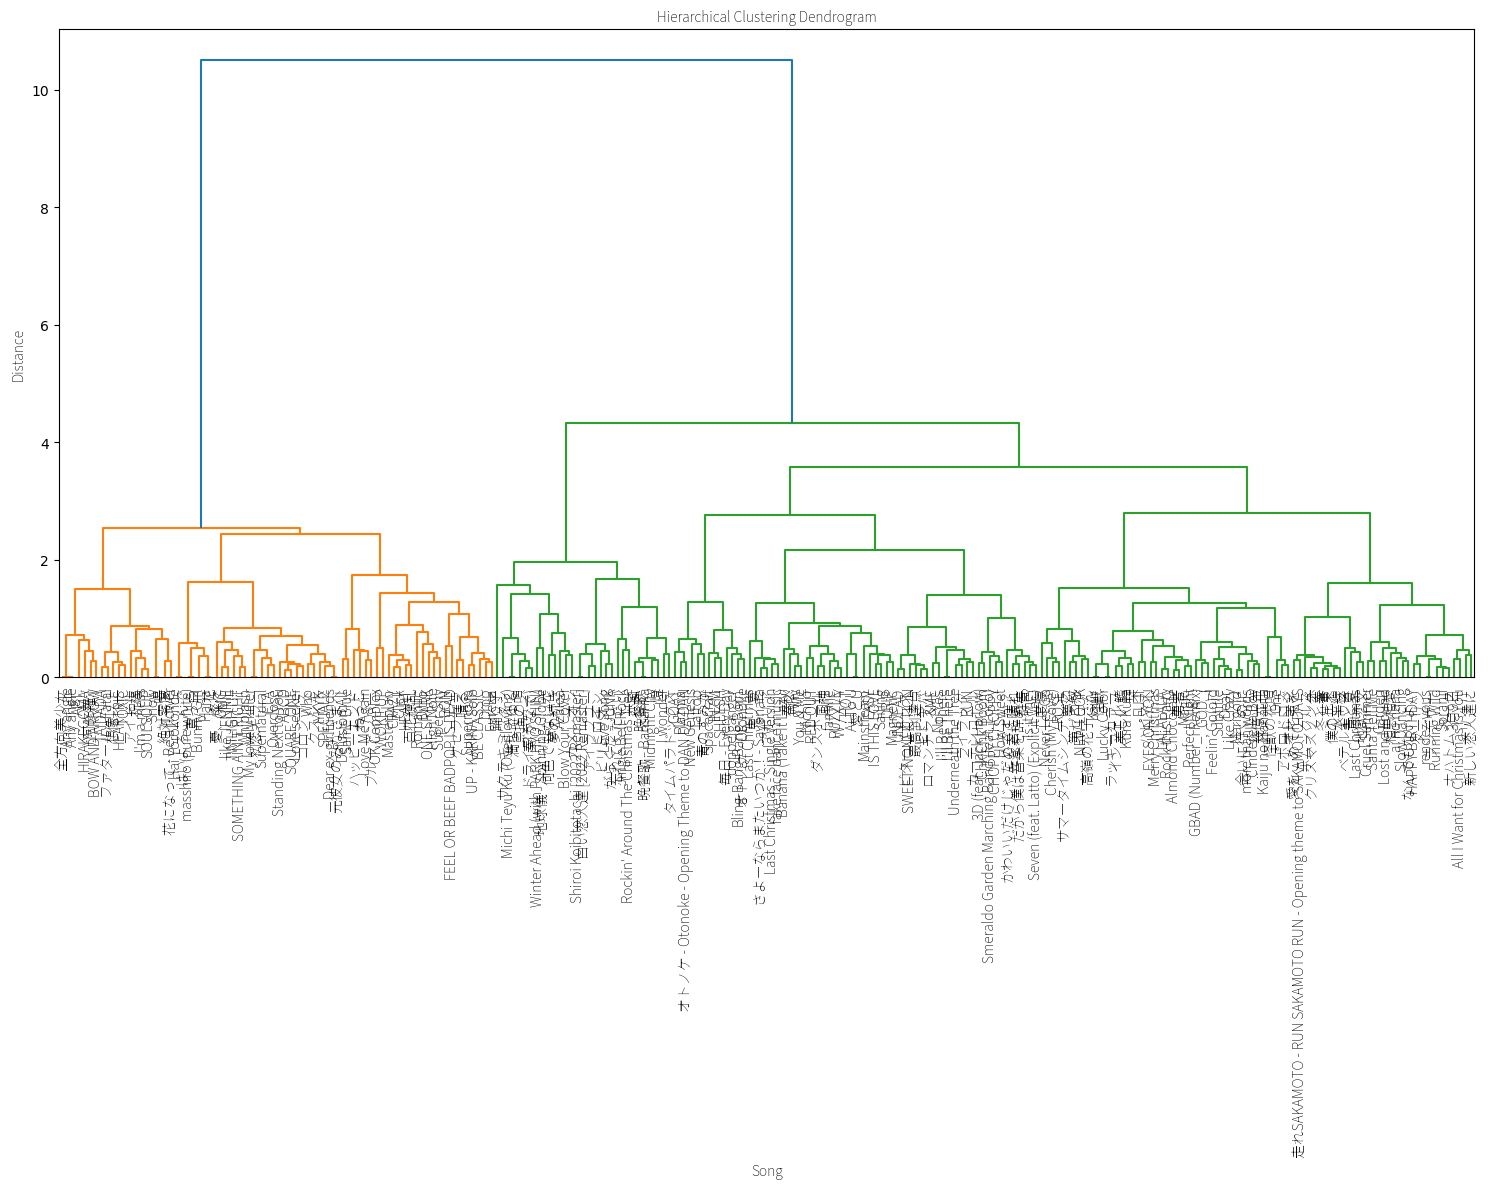

In [18]:
# Let's plot a dendrogram!
plt.figure(figsize=(15, 12))
dendrogram(linked, 
           labels=final_jp_spot_df1['name'].values, 
           leaf_rotation=90, 
           leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram',fontproperties=jp_font)
plt.xlabel('Song',fontproperties=jp_font)
plt.ylabel('Distance',fontproperties=jp_font)
plt.xticks(fontproperties=jp_font)
plt.tight_layout()
plt.show()

In [19]:
# Let's cut the dendrogram off at an appropriate distance that would give us the number of clusters we want. 
# Right now, I want to set the distance = 2, which would give us 9 clusters.
den_threshold = 2
final_jp_spot_df1['cluster'] = fcluster(linked, den_threshold,criterion='distance')
unique_clust = np.unique(final_jp_spot_df1['cluster'], return_counts=False)
print(unique_clust)

[1 2 3 4 5 6 7 8 9]


### 3.2 What are the clusters characterised by?

In [23]:
# Let's make a table which gives us the mean value per column in each cluster.
mean_list = []
for i in range(1,10):
    cluster_df = final_jp_spot_df1[final_jp_spot_df1['cluster'] == i][music_features]
    stats = cluster_df.agg(['mean'])
    # pd.pivot(stats,id_vars=music_features,var_name=['mean'])
    stats['cluster'] = i
    mean_list.append(stats)
mean_summary_jp = pd.concat(mean_list)
mean_summary_jp = mean_summary_jp.set_index('cluster')
mean_summary_jp

danceability    energy  loudness  mode  speechiness  acousticness  \
cluster                                                                      
1            0.469680  0.915115  0.766025   0.0     0.399038      0.097480   
2            0.665876  0.721569  0.563185   0.0     0.073676      0.136696   
3            0.589511  0.666030  0.616345   0.0     0.272486      0.081812   
4            0.474426  0.412977  0.495872   1.0     0.048562      0.571871   
5            0.591754  0.805488  0.560580   1.0     0.616350      0.055734   
6            0.732492  0.510139  0.553997   1.0     0.082027      0.114147   
7            0.583552  0.832550  0.754598   1.0     0.116677      0.129882   
8            0.457964  0.775853  0.699108   1.0     0.105431      0.078212   
9            0.281450  0.544950  0.622466   1.0     0.063258      0.119471   

         instrumentalness   valence     tempo  
cluster                                        
1                0.000005  0.724451  0.598910  
2                0.010184  0.772918  0.416775  
3                0.000094  0.377958  0.371007  
4                0.036670  0.439496  0.296798  
5                0.020975  0.612008  0.641441  
6                0.000155  0.704878  0.370607  
7                0.000638  0.770878  0.478735  
8                0.000701  0.390438  0.316565  
9                0.000259  0.400800  0.659976

In [48]:
mean_summary_jp.to_csv('mean_summary_jp.csv',index=True)

Based on the table above, I came up with short summaries which summed up the characteristics which defined each cluster.

**Cluster #1: Intense, loud tracks with spoken elements and upbeat mood, not very danceable.**

In [71]:
final_jp_spot_df1[final_jp_spot_df1['cluster'] == 1].head(10)

name                artists  danceability    energy  loudness  \
1          ):阿修羅:(               King Gnu        0.5136  0.812321  0.561883   
5             APT.       ROSÉ, Bruno Mars        0.7648  0.707736  0.663651   
9        Any angle                    noa        0.2688  0.922636  0.692206   
10       Any angle                     乃紫        0.2688  0.922636  0.692206   
14   BOW AND ARROW          Kenshi Yonezu        0.4880  0.852436  0.582303   
45        HEARTRIS                  NiziU        0.7008  0.985673  0.857143   
46      HIRAKEGOMA               Number_i        0.5216  0.863897  0.605379   
54      I'm a mess         MY FIRST STORY        0.2976  0.941261  0.726405   
105       SOULSOUP  OFFICIAL HIGE DANDISM        0.3328  0.931232  0.678426   
114           Show                    Ado        0.5072  0.982808  1.000000   

     mode  speechiness  acousticness  instrumentalness   valence     tempo  \
1     0.0     0.620853      0.127011          0.000000  0.520732  0.741169   
5     0.0     0.654307      0.032952          0.000000  0.952439  0.590102   
9     0.0     0.623641      0.174799          0.000000  0.848780  0.783241   
10    0.0     0.623641      0.174799          0.000000  0.848780  0.783241   
14    0.0     0.406189      0.033768          0.000004  0.652439  0.812825   
45    0.0     0.244494      0.136336          0.000006  0.836585  0.410359   
46    0.0     0.829941      0.003441          0.000000  0.652439  0.971388   
54    0.0     0.236130      0.007893          0.000000  0.564634  0.453503   
105   0.0     0.175355      0.001180          0.000000  0.560976  0.554231   
114   0.0     0.509339      0.200440          0.000002  0.712195  0.467870   

     cluster  
1          1  
5          1  
9          1  
10         1  
14         1  
45         1  
46         1  
54         1  
105        1  
114        1

**Cluster #2: Very upbeat, feel-good tracks suited for dancing, mostly melodic.**

In [32]:
final_jp_spot_df1[final_jp_spot_df1['cluster'] == 2].head(10)

name          artists  danceability    energy  loudness  \
4                  ABCD           NAYEON        0.6144  0.911175  0.827177   
18           Bunny Girl          AKASAKI        0.6880  0.563037  0.310949   
28  Dear ex-girlfriends         Koresawa        0.5632  0.795129  0.648211   
33                  ETA         NewJeans        0.8208  0.659026  0.504939   
48        Hai Yorokonde  Kocchi no Kento        0.7760  0.563037  0.070142   
49                 Hana       Fujii Kaze        0.7520  0.611748  0.354362   
57                IYKYK               XG        0.6544  0.799427  0.539802   
72          Love seeker              JO1        0.7536  0.875358  0.722504   
82     My lovely killer               乃紫        0.6640  0.767908  0.596995   
89                  OMG         NewJeans        0.8080  0.690544  0.697684   

    mode  speechiness  acousticness  instrumentalness   valence     tempo  \
4    0.0     0.102035      0.051718          0.000000  0.850000  0.280090   
18   0.0     0.094787      0.001996          0.000000  0.640244  0.668635   
28   0.0     0.031224      0.048571          0.000000  0.732927  0.395279   
33   0.0     0.040145      0.125846          0.000000  0.832927  0.488877   
48   0.0     0.122386      0.088898          0.000126  0.814634  0.575894   
49   0.0     0.049066      0.137501          0.008238  0.612195  0.402891   
57   0.0     0.103150      0.029689          0.000002  0.668293  0.452193   
72   0.0     0.082520      0.029572          0.000000  0.885366  0.394537   
82   0.0     0.074157      0.174799          0.001450  1.000000  0.568598   
89   0.0     0.050181      0.416065          0.000004  0.708537  0.431157   

    cluster  
4         2  
18        2  
28        2  
33        2  
48        2  
49        2  
57        2  
72        2  
82        2  
89        2

**Cluster #3: Edgy or somber tracks with some speech-like elements and a synthetic sound**

In [34]:
final_jp_spot_df1[final_jp_spot_df1['cluster'] == 3].head(10)

name        artists  danceability    energy  \
12                   BE CLASSIC            JO1        0.6928  0.567335   
13                          BON       Number_i        0.7280  0.680516   
20                        CRAZY    LE SSERAFIM        0.8048  0.873926   
24                        Click           ME:I        0.7152  0.912607   
29                 Delusion:All    ONE OK ROCK        0.1936  0.872493   
30                        Ditto       NewJeans        0.8240  0.504298   
31                         Drop           HANA        0.6272  0.773639   
35                       Eureka    Gen Hoshino        0.6528  0.628940   
36  FEEL OR BEEF BADPOP IS DEAD   NAMEDARUMAAZ        0.4688  0.916905   
44                        HEART  King & Prince        0.6112  0.863897   

    loudness  mode  speechiness  acousticness  instrumentalness   valence  \
12  0.710799   0.0     0.277948      0.033069          0.000000  0.508537   
13  0.491243   0.0     0.545581      0.011740          0.000000  0.598780   
20  0.850751   0.0     0.280736      0.011075          0.000364  0.454878   
24  0.769237   0.0     0.378311      0.017101          0.000000  0.441463   
29  0.720677   0.0     0.152495      0.000083          0.000000  0.189024   
30  0.540799   0.0     0.238918      0.031437          0.000000  0.030488   
31  0.625882   0.0     0.224979      0.025610          0.000000  0.453659   
35  0.565867   0.0     0.112350      0.144495          0.000988  0.345122   
36  0.682826   0.0     0.790912      0.247062          0.000000  0.690244   
44  0.691292   0.0     0.308614      0.095542          0.000000  0.441463   

       tempo  cluster  
12  0.236924        3  
13  0.150880        3  
20  0.453417        3  
24  0.532634        3  
29  0.296135        3  
30  0.480833        3  
31  0.117825        3  
35  0.143808        3  
36  0.109680        3  
44  0.453237        3

**Cluster #4: Mellow, acoustic, instrumental-leaning tracks with reflective or relaxed mood.**

In [36]:
final_jp_spot_df1[final_jp_spot_df1['cluster'] == 4].head(10)

name           artists  danceability  \
11                                Azalea     Kenshi Yonezu        0.6128   
17                       Blow Your Cover          Number_i        0.8192   
52                              I wonder            Da-iCE        0.7776   
60                      Jingle Bell Rock       Bobby Helms        0.7280   
71                             Love Song              マルシィ        0.4160   
80           Michi Teyu Ku (Overflowing)        Fujii Kaze        0.4256   
81                         Midnight City          Number_i        0.5520   
100    Rockin' Around The Christmas Tree        Brenda Lee        0.4784   
113  Shiroi Koibitotachi [2022 Remaster]    Keisuke Kuwata        0.1808   
136    Winter Ahead (with PARK HYO SHIN)  V, Park Hyo Shin        0.0976   

       energy  loudness  mode  speechiness  acousticness  instrumentalness  \
11   0.525788  0.241886   1.0     0.064399      0.467349          0.000005   
17   0.365330  0.393210   1.0     0.085029      0.661994          0.000017   
52   0.471347  0.714452   1.0     0.093950      0.596724          0.000000   
60   0.193410  0.332780   1.0     0.030666      0.749409          0.000000   
71   0.446991  0.494895   1.0     0.007527      0.343802          0.000000   
80   0.432665  0.378683   1.0     0.023139      0.551268          0.065375   
81   0.663324  0.632025   1.0     0.020630      0.364781          0.000000   
100  0.259312  0.309455   1.0     0.067745      0.719105          0.000000   
113  0.659026  0.699925   1.0     0.016727      0.461521          0.000530   
136  0.038682  0.209015   1.0     0.008642      1.000000          0.000265   

      valence     tempo  cluster  
11   0.464634  0.294529        4  
17   0.290244  0.308810        4  
52   0.863415  0.416761        4  
60   0.790244  0.378938        4  
71   0.471951  0.078331        4  
80   0.330488  0.553828        4  
81   0.502439  0.165088        4  
100  0.879268  0.000000        4  
113  0.241463  0.054977        4  
136  0.086585  0.070273        4

**Cluster #5: Energetic rap/spoken tracks with a positive tone and rhythmic drive.**

In [38]:
final_jp_spot_df1[final_jp_spot_df1['cluster'] == 5].head(10)

name                artists  danceability    energy  \
16   Bling-Bang-Bang-Born            Creepy Nuts        0.8896  0.724928   
40                   GOAT               Number_i        0.5840  0.891117   
55                   INZM               Number_i        0.6576  0.750716   
85            New Genesis                    Ado        0.3056  1.000000   
95                 Plazma          Kenshi Yonezu        0.4864  0.881089   
103                SHEESH            BABYMONSTER        0.7600  0.628940   
118            Spacecraft               BE:FIRST        0.8528  0.570201   
127                Tattoo  OFFICIAL HIGE DANDISM        0.2912  0.876791   
139          doppelgänger            Creepy Nuts        0.8336  0.978510   
160        オトノケ - Otonoke            Creepy Nuts        0.6496  0.759312   

     loudness  mode  speechiness  acousticness  instrumentalness   valence  \
16   0.382004   1.0     0.657095      0.109761          0.018875  0.726829   
40   0.799286   1.0     0.799275      0.035750          0.000000  0.710976   
55   0.619490   1.0     0.540006      0.012672          0.000000  0.487805   
85   0.846103   1.0     0.634792      0.057079          0.000004  0.357317   
95   0.542791   1.0     0.746306      0.026076          0.000000  0.581707   
103  0.613680   1.0     0.400613      0.131674          0.000000  0.369512   
118  0.356686   1.0     0.584611      0.059177          0.000045  0.375610   
127  0.568025   1.0     0.383886      0.013255          0.000000  0.803659   
139  0.510335   1.0     0.498188      0.038314          0.114750  0.787805   
160  0.497883   1.0     0.743518      0.064422          0.067125  0.764634   

        tempo  cluster  
16   0.647952        5  
40   0.812947        5  
55   0.330688        5  
85   0.777609        5  
95   0.763155        5  
103  0.525389        5  
118  0.524921        5  
127  0.914582        5  
139  0.662168        5  
160  0.740766        5

**Cluster #6: Highly danceable and happy tracks with a soft and groovy feel.**

In [40]:
final_jp_spot_df1[final_jp_spot_df1['cluster'] == 6].head(10)

name          artists  danceability    energy  \
6                           Ai To U  Mega Shinnosuke        0.7936  0.570201   
15            Banana (Take It Lazy)         Number_i        0.7376  0.130372   
26                             DRIP      BABYMONSTER        0.9008  0.570201   
32                             EASY      LE SSERAFIM        0.7120  0.588825   
47                              HOT      LE SSERAFIM        0.7424  0.488539   
56                     IS THIS LOVE               XG        0.7344  0.600287   
66                   Last Christmas            Wham!        0.6976  0.270774   
67  Last Christmas - Single Version            Wham!        0.6944  0.442693   
75                         Magnetic            ILLIT        0.7968  0.542980   
76                       Mainstream         BE:FIRST        0.9632  0.608883   

    loudness  mode  speechiness  acousticness  instrumentalness   valence  \
6   0.630032   1.0     0.164483      0.010131          0.001812  0.789024   
15  0.476384   1.0     0.058824      0.252890          0.000000  0.501220   
26  0.602391   1.0     0.125174      0.075728          0.000000  0.665854   
32  0.607454   1.0     0.070811      0.220255          0.000003  0.541463   
47  0.752553   1.0     0.085029      0.102885          0.000000  0.987805   
56  0.566116   1.0     0.130471      0.040878          0.000000  0.370732   
66  0.000000   1.0     0.011151      0.220255          0.000003  0.962195   
67  0.352287   1.0     0.006970      0.247062          0.000005  0.947561   
75  0.552254   1.0     0.120992      0.299511          0.000000  0.648780   
76  0.710052   1.0     0.277948      0.286690          0.000000  0.441463   

       tempo  cluster  
6   0.626002        6  
15  0.150354        6  
26  0.380861        6  
32  0.705161        6  
47  0.438366        6  
56  0.453352        6  
66  0.292354        6  
67  0.292714        6  
75  0.460762        6  
76  0.237111        6

**Cluster #7: Bright, energetic tracks with minimal spoken content and a strong rhythm**

In [42]:
final_jp_spot_df1[final_jp_spot_df1['cluster'] == 7].head(10)

name                      artists  danceability  \
0                      &ME                       NALALA        0.4480   
2   3D (feat. Jack Harlow)       Jung Kook, Jack Harlow        0.8864   
19           CHOPPY CHOPPY  PRODUCE 101 JAPAN THE GIRLS        0.8432   
22            Chk Chk Boom                   Stray Kids        1.0000   
51               How Sweet                     NewJeans        0.8064   
53           I'll Be There                          Jin        0.3824   
58               Is it me?                     Number_i        0.6656   
59           I’ll Be There                          Jin        0.3824   
87                  No-Yes                     Number_i        0.4912   
98                     RUN                     timelesz        0.2464   

      energy  loudness  mode  speechiness  acousticness  instrumentalness  \
0   0.921203  0.742093   1.0     0.199610      0.004560          0.008162   
2   0.766476  0.762430   1.0     0.216616      0.037498          0.000000   
19  0.935530  0.881381   1.0     0.150544      0.234241          0.000000   
22  0.644699  0.810741   1.0     0.277948      0.185288          0.000000   
51  0.868195  0.795551   1.0     0.103150      0.095076          0.000007   
53  0.643266  0.835063   1.0     0.053527      0.040878          0.000000   
58  0.883954  0.753383   1.0     0.068023      0.266876          0.000000   
59  0.643266  0.835063   1.0     0.053527      0.040878          0.000000   
87  0.809456  0.728065   1.0     0.102035      0.005446          0.000006   
98  0.909742  0.573919   1.0     0.189852      0.003931          0.000000   

     valence     tempo  cluster  
0   0.445122  0.560576        7  
2   0.890244  0.294961        7  
19  0.885366  0.337760        7  
22  0.857317  0.251370        7  
51  0.730488  0.417027        7  
53  0.704878  0.589094        7  
58  0.854878  0.366566        7  
59  0.704878  0.589094        7  
87  0.489024  0.734702        7  
98  0.657317  0.460215        7

**Cluster #8: Intense but moody or dark tracks, possibly electronic.**

In [44]:
final_jp_spot_df1[final_jp_spot_df1['cluster'] == 8].head(10)

name                           artists  danceability  \
8        Almond Chocolate                             ILLIT        0.6240   
21      Cherish (My Love)                             ILLIT        0.6640   
23         Cinderella Boy                         Saucy Dog        0.4752   
27                   Dear                  Mrs. GREEN APPLE        0.4272   
34            EYES ON YOU                      Kana Nishino        0.6784   
37                   FUJI                          Number_i        0.6416   
38         Feelin’ Go(o)d                        Fujii Kaze        0.4880   
39  GBAD (Number_i Remix)  88rising, Jackson Wang, Number_i        0.4464   
41                  GOD_i                          Number_i        0.5808   
61                  Kaiju                       sakanaction        0.4672   

      energy  loudness  mode  speechiness  acousticness  instrumentalness  \
8   0.830946  0.679256   1.0     0.065236      0.117687          0.000386   
21  0.762178  0.716942   1.0     0.110677      0.275035          0.000000   
23  0.638968  0.507180   1.0     0.022024      0.087150          0.000000   
27  0.611748  0.630613   1.0     0.021466      0.007765          0.000000   
34  0.806590  0.846103   1.0     0.009479      0.369444          0.000000   
37  0.769341  0.641820   1.0     0.367159      0.030155          0.000039   
38  0.679083  0.381423   1.0     0.088653      0.042976          0.000044   
39  0.388252  0.508591   1.0     0.173962      0.025260          0.000005   
41  0.571633  0.612767   1.0     0.211040      0.073513          0.000000   
61  0.757880  0.800780   1.0     0.068860      0.116288          0.000002   

     valence     tempo  cluster  
8   0.413415  0.301867        8  
21  0.176829  0.546482        8  
23  0.446341  0.295408        8  
27  0.297561  0.417114        8  
34  0.506098  0.273212        8  
37  0.264634  0.223025        8  
38  0.234146  0.273666        8  
39  0.490244  0.178130        8  
41  0.475610  0.143563        8  
61  0.580488  0.165117        8

**Cluster #9: Fast-paced but serious-sounding tracks that are less rhythmic and more ambient.**

In [46]:
final_jp_spot_df1[final_jp_spot_df1['cluster'] == 9].head(10)

name             artists  danceability  \
3                               3月9日          Remioromen        0.2240   
7    All I Want for Christmas Is You        Mariah Carey        0.0592   
25                      Cruel Summer        Taylor Swift        0.4048   
42                            Garden          Fujii Kaze        0.4640   
43                    HAPPY BIRTHDAY         back number        0.2928   
65                    Last Christmas       Ariana Grande        0.3280   
69                    Lost and Found  KingLee, Lil' Flip        0.6240   
102                     Running Wild                 Jin        0.3008   
111                    Santa Tell Me       Ariana Grande        0.3616   
115                     Slow Dancing                   V        0.4480   

       energy  loudness  mode  speechiness  acousticness  instrumentalness  \
3    0.305158  0.381008   1.0     0.000000      0.020365          0.000002   
7    0.484241  0.415788   1.0     0.036521      0.191116          0.000000   
25   0.591691  0.561551   1.0     0.367159      0.136336          0.000026   
42   0.340974  0.343654   1.0     0.088932      0.108596          0.000421   
43   0.448424  0.672948   1.0     0.013939      0.081789          0.000000   
65   0.732092  0.805927   1.0     0.038472      0.145660          0.000000   
69   0.329513  0.479538   1.0     0.200725      0.094843          0.000000   
102  0.604585  0.684984   1.0     0.019236      0.000172          0.000000   
111  0.475645  0.424006   1.0     0.255645      0.056963          0.000000   
115  0.488539  0.391301   1.0     0.091163      0.299511          0.005775   

      valence     tempo  cluster  
3    0.259756  0.618296        9  
7    0.234146  0.599075        9  
25   0.495122  0.741097        9  
42   0.509756  0.510856        9  
43   0.459756  0.568217        9  
65   0.769512  1.000000        9  
69   0.464634  0.641010        9  
102  0.193902  0.574936        9  
111  0.529268  0.898624        9  
115  0.480488  0.640031        9

In [49]:
# Hmm the size of the clusters is very uneven... will this affect the modelling? This is simply a reflection of what Japan's users listened to though. 
print(final_jp_spot_df1[final_jp_spot_df1['cluster'] == 1].shape[0])
print(final_jp_spot_df1[final_jp_spot_df1['cluster'] == 2].shape[0])
print(final_jp_spot_df1[final_jp_spot_df1['cluster'] == 3].shape[0])
print(final_jp_spot_df1[final_jp_spot_df1['cluster'] == 4].shape[0])
print(final_jp_spot_df1[final_jp_spot_df1['cluster'] == 5].shape[0])
print(final_jp_spot_df1[final_jp_spot_df1['cluster'] == 6].shape[0])
print(final_jp_spot_df1[final_jp_spot_df1['cluster'] == 7].shape[0])
print(final_jp_spot_df1[final_jp_spot_df1['cluster'] == 8].shape[0])
print(final_jp_spot_df1[final_jp_spot_df1['cluster'] == 9].shape[0])

20
29
27
31
13
26
25
44
32


### 3.3 Getting daily cluster proportionality 

We have assigned every distinct song in the dataset a cluster number. Let's merge the original dataset with the 'cluster' column.

In [28]:
jp_spotify2 = jp_spotify.merge(final_jp_spot_df1[['name','artists','cluster']],on=['name','artists'],how='left')
jp_spotify2

index              spotify_id         name              artists  \
0         1819  3huSUfmhUr4entz2S0G31O         クスシキ     Mrs. GREEN APPLE   
1         1820  7rPEpMvt6O2Np1i7TFk3Hc  TWILIGHT!!!             King Gnu   
2         1821  78W4mTLIh4qoLu92W4IQhO        ライラック     Mrs. GREEN APPLE   
3         1822  6FhWelfRDMFZRtFUU6SIdC           怪獣          sakanaction   
4         1824  5JTNhYqB0eG0ivgZcBviJ0         ROSE                 HANA   
...        ...                     ...          ...                  ...   
27047  1957321  6SwATVDZUy3jha72jDyxe2  サマータイムシンデレラ  Ryokuoushoku Shakai   
27048  1957322  2cxcqKwQtfKq7giphxjzOu          晩餐歌                tuki.   
27049  1957323  6zjk7Qbwb9DZ4ykUUoqknh         第ゼロ感              10-FEET   
27050  1957324  2piySGAWgVwsRKm60SfOmF   ai no hana               Aimyon   
27051  1957325  0nokJDMZpEnGbC09v5Fn6T    Love Song                 マルシィ   

       daily_rank  daily_movement  weekly_movement country snapshot_date  \
0               1              49               49      JP    2025-04-30   
1               2              48               48      JP    2025-04-30   
2               3              47               47      JP    2025-04-30   
3               4              46               46      JP    2025-04-30   
4               5              45               45      JP    2025-04-30   
...           ...             ...              ...     ...           ...   
27047          46               4                0      JP    2023-10-18   
27048          47               3                0      JP    2023-10-18   
27049          48               2                0      JP    2023-10-18   
27050          49               1                0      JP    2023-10-18   
27051          50               0                0      JP    2023-10-18   

       popularity  ...  loudness  mode speechiness acousticness  \
0              80  ...    -3.614     0      0.0491     0.001630   
1              75  ...    -5.120     0      0.0498     0.260000   
2              81  ...    -4.363     1      0.0964     0.017600   
3              80  ...    -2.825     1      0.0500     0.099800   
4              78  ...    -4.424     1      0.0619     0.069800   
...           ...  ...       ...   ...         ...          ...   
27047          75  ...    -1.974     1      0.0648     0.423000   
27048          67  ...    -4.665     1      0.0251     0.433000   
27049          71  ...    -4.160     1      0.1750     0.000028   
27050          51  ...    -6.210     1      0.0303     0.287000   
27051          43  ...    -6.533     1      0.0277     0.298000   

       instrumentalness  liveness  valence    tempo  time_signature  cluster  
0              0.000000    0.2930    0.911  137.909               3        2  
1              0.000155    0.1670    0.655  114.992               4        2  
2              0.000000    0.0820    0.775  149.923               4        7  
3              0.000002    0.1500    0.634   90.014               4        8  
4              0.000000    0.0976    0.367  124.983               4        8  
...                 ...       ...      ...      ...             ...      ...  
27047          0.000000    0.2600    0.311  143.057               4        8  
27048          0.000000    0.1100    0.630  102.983               4        4  
27049          0.000013    0.3200    0.349  150.082               4        8  
27050          0.000000    0.0773    0.469  170.028               3        9  
27051          0.000000    0.0731    0.528   78.047               4        4  

[27052 rows x 27 columns]

**Now, let's calculate the percentage of each cluster for each day's top 50**

In [30]:
cluster_count = jp_spotify2.groupby(['snapshot_date', 'cluster']).size().unstack(fill_value=0)
cluster_count_pct = cluster_count.div(cluster_count.sum(axis=1),axis=0)
cluster_count_pct = cluster_count_pct.reset_index()
cluster_count_pct

cluster snapshot_date     1     2     3     4     5     6     7     8     9
0          2023-10-18  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18
1          2023-10-19  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18
2          2023-10-20  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18
3          2023-10-21  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18
4          2023-10-22  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18
..                ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
536        2025-04-18  0.04  0.14  0.12  0.08  0.08  0.06  0.10  0.24  0.14
537        2025-04-19  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14
538        2025-04-20  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14
539        2025-04-21  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14
540        2025-04-30  0.04  0.14  0.12  0.08  0.08  0.08  0.10  0.22  0.14

[541 rows x 10 columns]

## Part 4: Modelling

### 4.1: Joining the daily cluster data with the daily weather data

In [33]:
new_tokyo_wea = pd.read_csv('/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/Final Datasets/tokyo_wea.csv')
new_tokyo_wea = new_tokyo_wea.set_index('Unnamed: 0')
new_tokyo_wea

time  temperature_2m_max (°C)  temperature_2m_min (°C)  \
Unnamed: 0                                                                 
0           2023-10-18                     23.6                     12.8   
1           2023-10-19                     24.3                     12.7   
2           2023-10-20                     25.2                     14.8   
3           2023-10-21                     21.1                     13.8   
4           2023-10-22                     18.6                      9.9   
...                ...                      ...                      ...   
556         2025-04-26                     16.9                     12.3   
557         2025-04-27                     20.2                     10.1   
558         2025-04-28                     21.3                     14.1   
559         2025-04-29                     21.6                     12.5   
560         2025-04-30                     20.8                     10.3   

            temperature_2m_mean (°C)  rain_sum (mm)  snowfall_sum (cm)  \
Unnamed: 0                                                               
0                               17.8            0.0                0.0   
1                               18.8            0.0                0.0   
2                               20.2            0.0                0.0   
3                               17.5            0.0                0.0   
4                               14.7            0.0                0.0   
...                              ...            ...                ...   
556                             14.7            3.3                0.0   
557                             16.2            0.0                0.0   
558                             17.4           12.0                0.0   
559                             16.6            3.5                0.0   
560                             16.0            0.0                0.0   

            precipitation_sum (mm)  relative_humidity_2m_max (%)  \
Unnamed: 0                                                         
0                              0.0                            91   
1                              0.0                           100   
2                              0.0                            90   
3                              0.0                            73   
4                              0.0                            85   
...                            ...                           ...   
556                            3.3                            85   
557                            0.0                            99   
558                           12.0                            94   
559                            3.5                            97   
560                            0.0                            82   

            relative_humidity_2m_min (%)  relative_humidity_2m_mean (%)  \
Unnamed: 0                                                                
0                                     47                             72   
1                                     51                             78   
2                                     57                             75   
3                                     48                             58   
4                                     39                             60   
...                                  ...                            ...   
556                                   54                             67   
557                                   51                             70   
558                                   55                             74   
559                                   25                             60   
560                                   36                             54   

            wind_speed_10m_max (km/h)  wind_speed_10m_min (km/h)  \
Unnamed: 0                                                         
0                                15.5                        2.4   
1

In [34]:
final_jp_df = pd.merge(cluster_count_pct,new_tokyo_wea,left_on='snapshot_date',right_on='time')
final_jp_df.drop(columns=['time'],inplace=True)
final_jp_df

snapshot_date     1     2     3     4     5     6     7     8     9  ...  \
0      2023-10-18  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
1      2023-10-19  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
2      2023-10-20  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
3      2023-10-21  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
4      2023-10-22  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
..            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
536    2025-04-18  0.04  0.14  0.12  0.08  0.08  0.06  0.10  0.24  0.14  ...   
537    2025-04-19  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
538    2025-04-20  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
539    2025-04-21  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
540    2025-04-30  0.04  0.14  0.12  0.08  0.08  0.08  0.10  0.22  0.14  ...   

     precipitation_sum (mm)  relative_humidity_2m_max (%)  \
0                       0.0                            91   
1                       0.0                           100   
2                       0.0                            90   
3                       0.0                            73   
4                       0.0                            85   
..                      ...                           ...   
536                     0.0                            88   
537                     0.0                            97   
538                     0.0                            88   
539                     0.0                            89   
540                     0.0                            82   

     relative_humidity_2m_min (%)  relative_humidity_2m_mean (%)  \
0                              47                             72   
1                              51                             78   
2                              57                             75   
3                              48                             58   
4                              39                             60   
..                            ...                            ...   
536                            54                             73   
537                            51                             79   
538                            63                             75   
539                            28                             62   
540                            36                             54   

     wind_speed_10m_max (km/h)  wind_speed_10m_min (km/h)  \
0                         15.5                        2.4   
1                         24.2                        4.2   
2                         45.6                        7.0   
3                         31.6                        4.5   
4                         25.8                        4.4   
..                         ...                        ...   
536                       17.9                        1.1   
537                       16.0                        0.8   
538                       22.5                        4.0   
539                       16.8                        6.6   
540                       15.1                        5.2   

     wind_speed_10m_mean (km/h)  daylight_duration (s)    sunrise (iso8601)  \
0                          11.0               40391.20  2023-10-18 05:49:00   
1                          12.2               40261.54  2023-10-19 05:50:00   
2                          23.7               40132.71  2023-10-20 05:51:00   
3                          19.2               40004.85  2023-10-21 05:52:00   
4                          14.9               39878.03  2023-10-22 05:52:00   
..                          ...                    ...                  ...   
536                         9.2               47512.69  2025-04-18 05:04:00   
537                         9.3               47637.75  2025-04-19 05:02:00   
538                        15.0               477

In [77]:
# Saving for safety's sake
final_jp_df.to_csv('final_jp_df.csv')

### 4.2: Adding 'Season' as a variable to the dataset

In [38]:
# Now, I want to create a new column in final_jp_df that indicates which season the day belongs to
final_jp_df['snapshot_date'] = pd.to_datetime(final_jp_df['snapshot_date'])
autumn_list = pd.date_range(start='2023-09-01', end='2023-11-30').strftime('%m-%d').tolist()
winter_list = pd.date_range(start='2023-12-01', end='2024-02-29').strftime('%m-%d').tolist()
spring_list = pd.date_range(start='2024-03-01', end='2024-05-31').strftime('%m-%d').tolist()
summer_list = pd.date_range(start='2024-06-01', end='2024-08-31').strftime('%m-%d').tolist()

def season(date):
    if date.strftime('%m-%d') in autumn_list:
        return 'Autumn'
    elif date.strftime('%m-%d') in winter_list:
        return 'Winter'
    elif date.strftime('%m-%d') in spring_list:
        return 'Spring'
    else:
        return 'Summer'

final_jp_df['season'] = final_jp_df['snapshot_date'].apply(season)
final_jp_df

snapshot_date     1     2     3     4     5     6     7     8     9  ...  \
0      2023-10-18  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
1      2023-10-19  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
2      2023-10-20  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
3      2023-10-21  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
4      2023-10-22  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
..            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
536    2025-04-18  0.04  0.14  0.12  0.08  0.08  0.06  0.10  0.24  0.14  ...   
537    2025-04-19  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
538    2025-04-20  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
539    2025-04-21  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
540    2025-04-30  0.04  0.14  0.12  0.08  0.08  0.08  0.10  0.22  0.14  ...   

     relative_humidity_2m_max (%)  relative_humidity_2m_min (%)  \
0                              91                            47   
1                             100                            51   
2                              90                            57   
3                              73                            48   
4                              85                            39   
..                            ...                           ...   
536                            88                            54   
537                            97                            51   
538                            88                            63   
539                            89                            28   
540                            82                            36   

     relative_humidity_2m_mean (%)  wind_speed_10m_max (km/h)  \
0                               72                       15.5   
1                               78                       24.2   
2                               75                       45.6   
3                               58                       31.6   
4                               60                       25.8   
..                             ...                        ...   
536                             73                       17.9   
537                             79                       16.0   
538                             75                       22.5   
539                             62                       16.8   
540                             54                       15.1   

     wind_speed_10m_min (km/h)  wind_speed_10m_mean (km/h)  \
0                          2.4                        11.0   
1                          4.2                        12.2   
2                          7.0                        23.7   
3                          4.5                        19.2   
4                          4.4                        14.9   
..                         ...                         ...   
536                        1.1                         9.2   
537                        0.8                         9.3   
538                        4.0                        15.0   
539                        6.6                         9.1   
540                        5.2                        10.4   

     daylight_duration (s)    sunrise (iso8601)     sunset (iso8601)  season  
0                 40391.20  2023-10-18 05:49:00  2023-10-18 17:02:00  Autumn  
1                 40261.54  2023-10-19 05:50:00  2023-10-19 17:01:00  Autumn  
2                 40132.71  2023-10-20 05:51:00  2023-10-20 17:00:00  Autumn  
3                 40004.85  2023-10-21 05:52:00  2023-10-21 16:58:00  Autumn  
4                 39878.03  2023-10-22 05:52:00  2023-10-22 16:57:00  Autumn  
..                     ...                  ...                  ...     ...  
536               47512.69  2025-04-18 05:04:00  2025-04-18 18:16:00  Spring  
537               47637.75  2025-04-19 05:02:00  2025-04-19 18:16:00  Spring  
5

In [39]:
# Now, I want to one-hot encode 'season', which is a categorical variable
final_jp_df['season'] = final_jp_df['season'].astype(str)

encoder1 = OneHotEncoder(sparse_output=False, drop='first')
encoder1_array = encoder1.fit_transform(final_jp_df[['season']])
encoder1_array = pd.DataFrame(encoder1_array, columns=encoder1.get_feature_names_out(['season']))
encoder1_array

season_Spring  season_Summer  season_Winter
0              0.0            0.0            0.0
1              0.0            0.0            0.0
2              0.0            0.0            0.0
3              0.0            0.0            0.0
4              0.0            0.0            0.0
..             ...            ...            ...
536            1.0            0.0            0.0
537            1.0            0.0            0.0
538            1.0            0.0            0.0
539            1.0            0.0            0.0
540            1.0            0.0            0.0

[541 rows x 3 columns]

In [40]:
very_final_jp_df = pd.concat([final_jp_df,encoder1_array],axis=1)
very_final_jp_df.drop('season',axis=1,inplace=True)
very_final_jp_df

snapshot_date     1     2     3     4     5     6     7     8     9  ...  \
0      2023-10-18  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
1      2023-10-19  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
2      2023-10-20  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
3      2023-10-21  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
4      2023-10-22  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
..            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
536    2025-04-18  0.04  0.14  0.12  0.08  0.08  0.06  0.10  0.24  0.14  ...   
537    2025-04-19  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
538    2025-04-20  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
539    2025-04-21  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
540    2025-04-30  0.04  0.14  0.12  0.08  0.08  0.08  0.10  0.22  0.14  ...   

     relative_humidity_2m_mean (%)  wind_speed_10m_max (km/h)  \
0                               72                       15.5   
1                               78                       24.2   
2                               75                       45.6   
3                               58                       31.6   
4                               60                       25.8   
..                             ...                        ...   
536                             73                       17.9   
537                             79                       16.0   
538                             75                       22.5   
539                             62                       16.8   
540                             54                       15.1   

     wind_speed_10m_min (km/h)  wind_speed_10m_mean (km/h)  \
0                          2.4                        11.0   
1                          4.2                        12.2   
2                          7.0                        23.7   
3                          4.5                        19.2   
4                          4.4                        14.9   
..                         ...                         ...   
536                        1.1                         9.2   
537                        0.8                         9.3   
538                        4.0                        15.0   
539                        6.6                         9.1   
540                        5.2                        10.4   

     daylight_duration (s)    sunrise (iso8601)     sunset (iso8601)  \
0                 40391.20  2023-10-18 05:49:00  2023-10-18 17:02:00   
1                 40261.54  2023-10-19 05:50:00  2023-10-19 17:01:00   
2                 40132.71  2023-10-20 05:51:00  2023-10-20 17:00:00   
3                 40004.85  2023-10-21 05:52:00  2023-10-21 16:58:00   
4                 39878.03  2023-10-22 05:52:00  2023-10-22 16:57:00   
..                     ...                  ...                  ...   
536               47512.69  2025-04-18 05:04:00  2025-04-18 18:16:00   
537               47637.75  2025-04-19 05:02:00  2025-04-19 18:16:00   
538               47762.61  2025-04-20 05:01:00  2025-04-20 18:17:00   
539               47887.18  2025-04-21 05:00:00  2025-04-21 18:18:00   
540               48979.58  2025-04-30 04:49:00  2025-04-30 18:26:00   

     season_Spring  season_Summer  season_Winter  
0              0.0            0.0            0.0  
1              0.0            0.0            0.0  
2              0.0            0.0            0.0  
3              0.0            0.0            0.0  
4              0.0            0.0            0.0  
..             ...            ...            ...  
536            1.0            0.0            0.0  
537            1.0            0.0            0.0  
538            1.0            0.0            0.0  
539            1.0            0.0            0.0  
540            1.0            0.0            0.0  

[541 rows x 28 columns]

In [41]:
very_final_jp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   snapshot_date                  541 non-null    datetime64[ns]
 1   1                              541 non-null    float64       
 2   2                              541 non-null    float64       
 3   3                              541 non-null    float64       
 4   4                              541 non-null    float64       
 5   5                              541 non-null    float64       
 6   6                              541 non-null    float64       
 7   7                              541 non-null    float64       
 8   8                              541 non-null    float64       
 9   9                              541 non-null    float64       
 10  temperature_2m_max (°C)        541 non-null    float64       
 11  temperature_2m_min 

In [42]:
# I notice that the sunrise and sunset columns are strings.
# I want to convert them into a format which the model would be able to understand
# I will convert them to datetime first, then re-assign to each column the concatenation of the hour and minute/60
# The result should be a float value
very_final_jp_df['sunrise (iso8601)'] = pd.to_datetime(very_final_jp_df['sunrise (iso8601)'])
very_final_jp_df['sunset (iso8601)'] = pd.to_datetime(very_final_jp_df['sunset (iso8601)'])

very_final_jp_df['sunrise (iso8601)'] = very_final_jp_df['sunrise (iso8601)'].dt.hour + very_final_jp_df['sunrise (iso8601)'].dt.minute/60
very_final_jp_df['sunset (iso8601)'] = very_final_jp_df['sunset (iso8601)'].dt.hour + very_final_jp_df['sunset (iso8601)'].dt.minute/60

very_final_jp_df.rename(columns={'sunrise (iso8601)': 'sunrise_time', 'sunset (iso8601)': 'sunset_time'},inplace=True)
very_final_jp_df

snapshot_date     1     2     3     4     5     6     7     8     9  ...  \
0      2023-10-18  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
1      2023-10-19  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
2      2023-10-20  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
3      2023-10-21  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
4      2023-10-22  0.08  0.08  0.06  0.14  0.06  0.12  0.08  0.20  0.18  ...   
..            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
536    2025-04-18  0.04  0.14  0.12  0.08  0.08  0.06  0.10  0.24  0.14  ...   
537    2025-04-19  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
538    2025-04-20  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
539    2025-04-21  0.04  0.16  0.12  0.08  0.08  0.06  0.10  0.22  0.14  ...   
540    2025-04-30  0.04  0.14  0.12  0.08  0.08  0.08  0.10  0.22  0.14  ...   

     relative_humidity_2m_mean (%)  wind_speed_10m_max (km/h)  \
0                               72                       15.5   
1                               78                       24.2   
2                               75                       45.6   
3                               58                       31.6   
4                               60                       25.8   
..                             ...                        ...   
536                             73                       17.9   
537                             79                       16.0   
538                             75                       22.5   
539                             62                       16.8   
540                             54                       15.1   

     wind_speed_10m_min (km/h)  wind_speed_10m_mean (km/h)  \
0                          2.4                        11.0   
1                          4.2                        12.2   
2                          7.0                        23.7   
3                          4.5                        19.2   
4                          4.4                        14.9   
..                         ...                         ...   
536                        1.1                         9.2   
537                        0.8                         9.3   
538                        4.0                        15.0   
539                        6.6                         9.1   
540                        5.2                        10.4   

     daylight_duration (s)  sunrise_time  sunset_time  season_Spring  \
0                 40391.20      5.816667    17.033333            0.0   
1                 40261.54      5.833333    17.016667            0.0   
2                 40132.71      5.850000    17.000000            0.0   
3                 40004.85      5.866667    16.966667            0.0   
4                 39878.03      5.866667    16.950000            0.0   
..                     ...           ...          ...            ...   
536               47512.69      5.066667    18.266667            1.0   
537               47637.75      5.033333    18.266667            1.0   
538               47762.61      5.016667    18.283333            1.0   
539               47887.18      5.000000    18.300000            1.0   
540               48979.58      4.816667    18.433333            1.0   

     season_Summer  season_Winter  
0              0.0            0.0  
1              0.0            0.0  
2              0.0            0.0  
3              0.0            0.0  
4              0.0            0.0  
..             ...            ...  
536            0.0            0.0  
537            0.0            0.0  
538            0.0            0.0  
539            0.0            0.0  
540            0.0            0.0  

[541 rows x 28 columns]

In [43]:
very_final_jp_df.dtypes

snapshot_date                    datetime64[ns]
1                                       float64
2                                       float64
3                                       float64
4                                       float64
5                                       float64
6                                       float64
7                                       float64
8                                       float64
9                                       float64
temperature_2m_max (°C)                 float64
temperature_2m_min (°C)                 float64
temperature_2m_mean (°C)                float64
rain_sum (mm)                           float64
snowfall_sum (cm)                       float64
precipitation_sum (mm)                  float64
relative_humidity_2m_max (%)              int64
relative_humidity_2m_min (%)              int64
relative_humidity_2m_mean (%)             int64
wind_speed_10m_max (km/h)               float64
wind_speed_10m_min (km/h)               

In [85]:
# Saving this for safety
very_final_jp_df.to_csv('very_final_jp_df.csv',index=False)

### 4.3 Train/Test Split

In my model, I aim to predict the cluster composition of the songs in each day's top 50 based on the weather. As a result:<br>
&nbsp;• **X = Weather columns**<br>
&nbsp;• **y = Cluster columns**<br>

I will also take this opportunity to elaborate on how I intend to model this data. Some considerations I have made include:<br>
&nbsp;• The relationship between musical characteristics (as represented by the clusters) and weather parameters cannot be assumed to be linear.<br>
&nbsp;• The model must be able to account for interactions between the different weather conditions and clusters<br>

As a result, I will be focusing on using XGBoost to predict the cluster composition of the songs in each day's top 50 based on weather. Afterward, I will refer back to my EDA findings based on Tokyo's weather data to optimise my X variables further.

In [98]:
very_final_jp_df = pd.read_csv("/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/very_final_jp_df.csv")

In [100]:
very_final_jp_df.columns

Index(['snapshot_date', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       'temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'temperature_2m_mean (°C)', 'rain_sum (mm)', 'snowfall_sum (cm)',
       'precipitation_sum (mm)', 'relative_humidity_2m_max (%)',
       'relative_humidity_2m_min (%)', 'relative_humidity_2m_mean (%)',
       'wind_speed_10m_max (km/h)', 'wind_speed_10m_min (km/h)',
       'wind_speed_10m_mean (km/h)', 'daylight_duration (s)', 'sunrise_time',
       'sunset_time', 'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [102]:
weather_columns = ['temperature_2m_max (°C)',
                   'temperature_2m_min (°C)',
                   'temperature_2m_mean (°C)',
                   'rain_sum (mm)',
                   'snowfall_sum (cm)',
                   'precipitation_sum (mm)',
                   'relative_humidity_2m_max (%)',
                   'relative_humidity_2m_min (%)',
                   'relative_humidity_2m_mean (%)',
                   'wind_speed_10m_max (km/h)',
                   'wind_speed_10m_min (km/h)',
                   'wind_speed_10m_mean (km/h)',
                   'daylight_duration (s)',
                   'sunrise_time',
                   'sunset_time',
                   'season_Spring',
                   'season_Summer',
                   'season_Winter']
weather_columns_optimised_jp = ['temperature_2m_max (°C)',
                                'temperature_2m_min (°C)',
                                'temperature_2m_mean (°C)',
                                'daylight_duration (s)',
                                'rain_sum (mm)',
                                'snowfall_sum (cm)',
                                'precipitation_sum (mm)']

In [104]:
X = very_final_jp_df[weather_columns]
y = very_final_jp_df.drop(columns=weather_columns + ['snapshot_date'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
y_test

1         2         3         4         5         6         7  \
229  0.060000  0.040000  0.140000  0.100000  0.080000  0.100000  0.140000   
73   0.140000  0.080000  0.020000  0.160000  0.060000  0.040000  0.100000   
352  0.060000  0.160000  0.080000  0.120000  0.080000  0.080000  0.100000   
86   0.120000  0.100000  0.060000  0.140000  0.080000  0.040000  0.080000   
470  0.040000  0.100000  0.100000  0.100000  0.120000  0.120000  0.080000   
..        ...       ...       ...       ...       ...       ...       ...   
148  0.137255  0.039216  0.058824  0.078431  0.058824  0.098039  0.098039   
46   0.100000  0.100000  0.060000  0.140000  0.060000  0.080000  0.100000   
93   0.120000  0.080000  0.060000  0.140000  0.080000  0.040000  0.080000   
407  0.080000  0.100000  0.100000  0.100000  0.080000  0.080000  0.160000   
182  0.100000  0.040000  0.060000  0.120000  0.060000  0.140000  0.120000   

            8         9  
229  0.220000  0.120000  
73   0.220000  0.180000  
352  0.160000  0.160000  
86   0.220000  0.160000  
470  0.140000  0.200000  
..        ...       ...  
148  0.254902  0.176471  
46   0.180000  0.180000  
93   0.220000  0.180000  
407  0.120000  0.180000  
182  0.220000  0.140000  

[109 rows x 9 columns]

### 4.4 Round #1: XGBoost Regression

#### 4.4.1 Using Train Data 

In [108]:
xgb = XGBRegressor(n_estimators=20, random_state=42)
multi_xgb = MultiOutputRegressor(xgb)
multi_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=20, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [110]:
# Predicting y_train
y_train_pred_xgb = multi_xgb.predict(X_train)

# Actual y_train values
y_train_actual_xgb = y_train.values.tolist()

In [112]:
print("R² score:", r2_score(y_train_actual_xgb, y_train_pred_xgb))
print("MSE:", mean_squared_error(y_train_actual_xgb, y_train_pred_xgb))

R² score: 0.9886205196380615
MSE: 8.96383221401509e-06


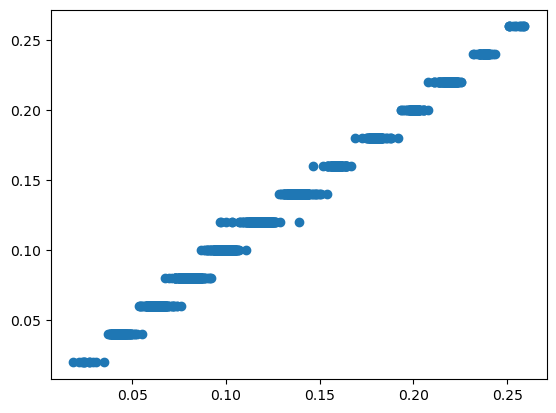

In [114]:
plt.scatter(y_train_pred_xgb, y_train_actual_xgb)
plt.show()

#### 4.4.2 Using Test Data

In [116]:
# Predicting y_train
y_test_pred_xgb = multi_xgb.predict(X_test)

# Actual y_train values
y_test_actual_xgb = y_test.values.tolist()

In [118]:
print("(XGB) R² score:", r2_score(y_test_actual_xgb, y_test_pred_xgb))
print("(XGB) MSE:", mean_squared_error(y_test_actual_xgb, y_test_pred_xgb))

(XGB) R² score: 0.6616260409355164
(XGB) MSE: 0.00032145852481113297


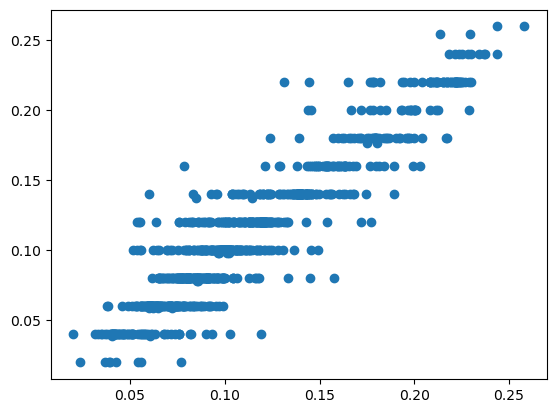

In [120]:
plt.scatter(y_test_pred_xgb, y_test_actual_xgb)
plt.show()

##### **The XGBoost may have been overfitted as the results for running y_test through it were significantly worse than running y_train through it.**

The model only considers weather measurements. That the results for the test dataset were worse than those for the train dataset suggests that **weather measurements alone were unable to determine the cluster composition of Japan's Top 50 songs list**.

### 4.5 Round #2: Optimised Weather Data (XGBoost + Targetted X Variables)

Based on the EDA from earlier, we have deduced that the weather metrics with the most pronounced general trends over time are:
- Temperature
- Sunlight Duration
- Precipitation

In order to optimise the XGBoost model, we shall re-do the train-test split onwards with only measures related to the above metrics. 

#### 4.5.1 Re-doing Train/Test Split

In [124]:
X2 = very_final_jp_df[weather_columns_optimised_jp]
y2 = very_final_jp_df.drop(columns=weather_columns + ['snapshot_date'])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

#### 4.5.2 Using Train Data

In [126]:
xgb1 = XGBRegressor(n_estimators=20, random_state=42)
multi_xgb1 = MultiOutputRegressor(xgb1)
multi_xgb1.fit(X2_train, y2_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=20, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [128]:
# Predicting y_train
y2_train_pred_xgb = multi_xgb1.predict(X2_train)

# Actual y_train values
y2_train_actual_xgb = y2_train.values.tolist()

In [130]:
print("R² score:", r2_score(y2_train_actual_xgb, y2_train_pred_xgb))
print("MSE:", mean_squared_error(y2_train_actual_xgb, y2_train_pred_xgb))

R² score: 0.9478399753570557
MSE: 4.59923170575347e-05


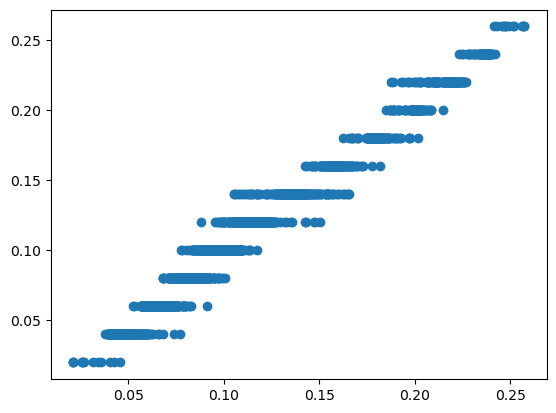

In [132]:
plt.scatter(y2_train_pred_xgb, y2_train_actual_xgb)
plt.show()

#### 4.5.3 Using Test Data

In [134]:
# Predicting y_test
y2_test_pred_xgb = multi_xgb1.predict(X2_test)

# Actual y_train values
y2_test_actual_xgb = y2_test.values.tolist()

In [136]:
print("R² score:", r2_score(y2_test_actual_xgb, y2_test_pred_xgb))
print("MSE:", mean_squared_error(y2_test_actual_xgb, y2_test_pred_xgb))

R² score: 0.338283896446228
MSE: 0.0006314662771147896


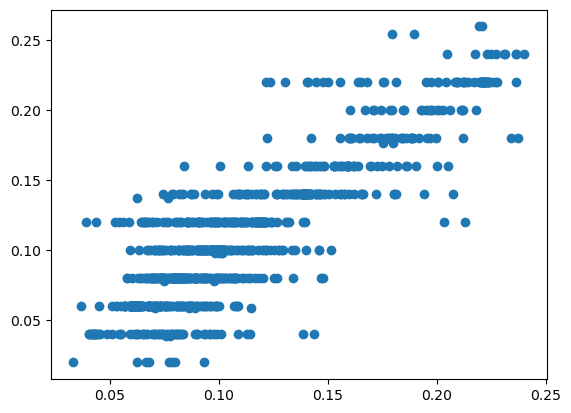

In [138]:
plt.scatter(y2_test_pred_xgb, y2_test_actual_xgb)
plt.show()

If anything, "optimising" the model using only the weather parameters with the clearest patterns has only gone to show that the correlation between the cluster composition of Japan's Spotify Top 50 and weather conditions is very weak.

### 4.6 Round #3: CatBoost Regression

#### 4.6.1 Using Train Data

In [140]:
# Initialise the catboost model
catboost = CatBoostRegressor(
    iterations=1000,     # number of boosting rounds
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100          # prints training progress every 100 iterations
)
# Unless we use MultiOutputRegressor, the catboost model can only do single-target regression 
cat_multi = MultiOutputRegressor(catboost)

In [142]:
# We're going to use the original train/test split because we don't want to use the "optimised X variables". We want all the weather measures
cat_multi.fit(X_train, y_train)

0:	learn: 0.0317169	total: 33.2ms	remaining: 33.2s
100:	learn: 0.0108819	total: 185ms	remaining: 1.65s
200:	learn: 0.0059086	total: 443ms	remaining: 1.76s
300:	learn: 0.0034495	total: 609ms	remaining: 1.41s
400:	learn: 0.0022365	total: 758ms	remaining: 1.13s
500:	learn: 0.0013861	total: 883ms	remaining: 879ms
600:	learn: 0.0009352	total: 1.1s	remaining: 729ms
700:	learn: 0.0006265	total: 1.23s	remaining: 523ms
800:	learn: 0.0004440	total: 1.37s	remaining: 341ms
900:	learn: 0.0003179	total: 1.51s	remaining: 166ms
999:	learn: 0.0002240	total: 1.66s	remaining: 0us
0:	learn: 0.0327066	total: 2.42ms	remaining: 2.42s
100:	learn: 0.0100728	total: 248ms	remaining: 2.2s
200:	learn: 0.0062845	total: 369ms	remaining: 1.47s
300:	learn: 0.0042863	total: 509ms	remaining: 1.18s
400:	learn: 0.0027542	total: 629ms	remaining: 940ms
500:	learn: 0.0018544	total: 779ms	remaining: 776ms
600:	learn: 0.0012881	total: 903ms	remaining: 599ms
700:	learn: 0.0008905	total: 1.08s	remaining: 460ms
800:	learn: 0.0006

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x13b570c80>)

In [143]:
y_train_pred_cat = cat_multi.predict(X_train)
y_train_actual_cat = y_train.values.tolist()

In [146]:
print("(CatB JP Train) R² score:", r2_score(y_train_actual_cat, y_train_pred_cat))
print("(CatB JP Train) MSE:", mean_squared_error(y_train_actual_cat, y_train_pred_cat))

(CatB JP Train) R² score: 0.9999080417689714
(CatB JP Train) MSE: 7.699474965045235e-08


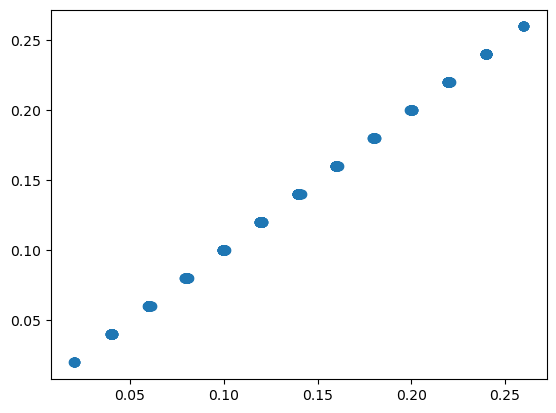

In [148]:
plt.scatter(y_train_pred_cat, y_train_actual_cat)
plt.show()

#### 4.6.2 Using Test Data

In [150]:
y_test_pred_cat = cat_multi.predict(X_test)
y_test_actual_cat = y_test.values.tolist()

In [152]:
print("(CatB JP Test) R² score:", r2_score(y_test_actual_cat, y_test_pred_cat))
print("(CatB JP Test) MSE:", mean_squared_error(y_test_actual_cat, y_test_pred_cat))

(CatB JP Test) R² score: 0.7154141829222558
(CatB JP Test) MSE: 0.0002632912133004734


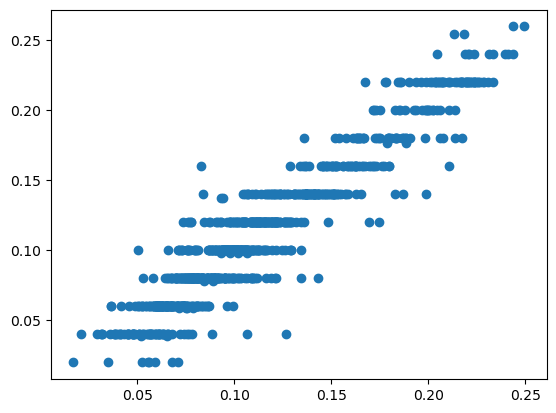

In [154]:
plt.scatter(y_test_pred_cat, y_test_actual_cat)
plt.show()

#### 4.6.3 Running May 2025 Data Through the Catboost Model (Only for Visualisation Purposes on Tableau)

To visualise the predictive capabilities of my model, I downloaded a new set of Open-Meteo data from Tokyo, and cleaned it until the formatting was identical to the weather half of the modelling dataset. The main dataset ends in 30 April 2025, and this new dataset contains weather data between 1 May 2025 to 1 June 2025. 

Now, I will run this dataset ('may_wea') through the cat_multi model we trained earlier so I can obtain a dataframe of predicted proportions of clusters 1-9 for the 30 days after the last date captured in the main dataset we've been using so far.

##### **a) Running May-June 2025 Weather Data through the model, b) Re-merging the results with the weather data, c) Melting cluster column data.**

In [86]:
may_wea = pd.read_csv("/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/FOR TABLEAU/tokyo_wea_may_prepped.csv")
may_wea

snapshot_date  temperature_2m_max (°C)  temperature_2m_min (°C)  \
0     2025-05-01                     24.3                     11.2   
1     2025-05-02                     17.5                     14.4   
2     2025-05-03                     24.2                     14.6   
3     2025-05-04                     24.9                     12.9   
4     2025-05-05                     23.0                     11.5   
5     2025-05-06                     16.8                     13.4   
6     2025-05-07                     24.9                     13.6   
7     2025-05-08                     23.4                     12.8   
8     2025-05-09                     23.3                     13.9   
9     2025-05-10                     21.9                     15.6   
10    2025-05-11                     26.5                     16.0   
11    2025-05-12                     19.3                     15.3   
12    2025-05-13                     25.5                     14.3   
13    2025-05-14                     24.6                     14.6   
14    2025-05-15                     25.1                     15.7   
15    2025-05-16                     23.9                     16.6   
16    2025-05-17                     22.0                     18.4   
17    2025-05-18                     27.8                     20.4   
18    2025-05-19                     20.0                     16.6   
19    2025-05-20                     29.2                     16.2   
20    2025-05-21                     27.1                     17.4   
21    2025-05-22                     26.2                     17.0   
22    2025-05-23                     24.0                     15.9   
23    2025-05-24                     19.6                     14.6   
24    2025-05-25                     23.5                     14.7   
25    2025-05-26                     22.4                     16.5   
26    2025-05-27                     20.0                     14.9   
27    2025-05-28                     26.2                     15.6   
28    2025-05-29                     22.6                     15.6   
29    2025-05-30                     16.8                     14.7   
30    2025-05-31                     16.7                     14.6   
31    2025-06-01                     22.8                     16.0   

    temperature_2m_mean (°C)  rain_sum (mm)  snowfall_sum (cm)  \
0                       17.2            0.0                  0   
1                       16.1           70.7                  0   
2                       18.5            0.0                  0   
3                       17.9            0.0                  0   
4                       17.1            0.0                  0   
5                       14.7           19.2                  0   
6                       18.5            6.6                  0   
7                       17.3            0.0                  0   
8                       17.7            2.7                  0   
9                       18.6            7.3                  0   
10                      20.7            0.6                  0   
11                      17.0            7.4                  0   
12                      19.3            0.0                  0   
13                      19.1            0.0                  0   
14                      19.8            0.0                  0   
15                      19.9            0.1                  0   
16                      20.2           27.8                  0   
17                      23.4            0.0                  0   
18                      18.5            0.6                  0   
19                      22.7            0.0                  0   
20                      21.7            0.0                  0   
21                      21.7            0.8                  0   
22                      18.6            0.0                  0   
23                      16.8            2.4                  0   
24                      18.3           18.

In [91]:
weather_columns = ['temperature_2m_max (°C)',
                   'temperature_2m_min (°C)',
                   'temperature_2m_mean (°C)',
                   'rain_sum (mm)',
                   'snowfall_sum (cm)',
                   'precipitation_sum (mm)',
                   'relative_humidity_2m_max (%)',
                   'relative_humidity_2m_min (%)',
                   'relative_humidity_2m_mean (%)',
                   'wind_speed_10m_max (km/h)',
                   'wind_speed_10m_min (km/h)',
                   'wind_speed_10m_mean (km/h)',
                   'daylight_duration (s)',
                   'sunrise_time',
                   'sunset_time',
                   'season_Spring',
                   'season_Summer',
                   'season_Winter']

# Predicting y values for May 2025 weather 
y_test_pred_cat_may = cat_multi.predict(may_wea[weather_columns])

In [93]:
y_test_pred_cat_may = pd.DataFrame(y_test_pred_cat_may,columns=['1','2','3','4','5','6','7','8','9'])
y_test_pred_cat_may = pd.concat([may_wea['snapshot_date'],y_test_pred_cat_may],axis=1)
y_test_pred_cat_may_full = pd.merge(y_test_pred_cat_may,may_wea,on='snapshot_date')
y_test_pred_cat_may_full['snapshot_date'] = pd.to_datetime(y_test_pred_cat_may_full['snapshot_date'])

In [95]:
y_test_pred_cat_may_full.shape

(32, 28)

In [97]:
y_test_pred_cat_may_full.dtypes

snapshot_date                    datetime64[ns]
1                                       float64
2                                       float64
3                                       float64
4                                       float64
5                                       float64
6                                       float64
7                                       float64
8                                       float64
9                                       float64
temperature_2m_max (°C)                 float64
temperature_2m_min (°C)                 float64
temperature_2m_mean (°C)                float64
rain_sum (mm)                           float64
snowfall_sum (cm)                         int64
precipitation_sum (mm)                  float64
relative_humidity_2m_max (%)              int64
relative_humidity_2m_min (%)              int64
relative_humidity_2m_mean (%)             int64
wind_speed_10m_max (km/h)               float64
wind_speed_10m_min (km/h)               

**One last thing; for the sake of simplicity in Tableau, I will rename the song cluster columns, then melt them.**

In [99]:
y_test_pred_cat_may_full

snapshot_date         1         2         3         4         5         6  \
0     2025-05-01  0.060100  0.092568  0.086932  0.098187  0.083566  0.121377   
1     2025-05-02  0.071281  0.071485  0.100106  0.095442  0.060518  0.126152   
2     2025-05-03  0.050631  0.103875  0.105965  0.086059  0.093388  0.103521   
3     2025-05-04  0.064839  0.091922  0.097746  0.096562  0.079890  0.115159   
4     2025-05-05  0.058824  0.098044  0.084907  0.090376  0.084713  0.118230   
5     2025-05-06  0.047071  0.088761  0.100096  0.083727  0.077279  0.130486   
6     2025-05-07  0.052063  0.101300  0.107850  0.074792  0.090715  0.123571   
7     2025-05-08  0.048799  0.106401  0.104310  0.078824  0.091149  0.107273   
8     2025-05-09  0.063322  0.087267  0.097934  0.108994  0.079970  0.128852   
9     2025-05-10  0.065339  0.068969  0.087811  0.105664  0.065420  0.125399   
10    2025-05-11  0.053909  0.096066  0.092472  0.103606  0.081045  0.115597   
11    2025-05-12  0.063617  0.083826  0.097365  0.104120  0.070801  0.131214   
12    2025-05-13  0.058556  0.096402  0.093582  0.103573  0.080950  0.112040   
13    2025-05-14  0.065281  0.085129  0.093474  0.105586  0.079714  0.117857   
14    2025-05-15  0.067552  0.077863  0.091836  0.104956  0.076660  0.119576   
15    2025-05-16  0.065900  0.082096  0.085814  0.112811  0.078435  0.124088   
16    2025-05-17  0.065045  0.069739  0.085132  0.103729  0.060416  0.125710   
17    2025-05-18  0.063201  0.081457  0.081848  0.111223  0.071860  0.104713   
18    2025-05-19  0.071052  0.065546  0.088568  0.110366  0.073195  0.134366   
19    2025-05-20  0.059812  0.099974  0.091947  0.116104  0.074563  0.108794   
20    2025-05-21  0.060186  0.078765  0.077948  0.112785  0.073395  0.118708   
21    2025-05-22  0.061558  0.072780  0.083409  0.119216  0.083442  0.126715   
22    2025-05-23  0.053116  0.085106  0.085782  0.112666  0.089219  0.121200   
23    2025-05-24  0.053653  0.078196  0.093743  0.115588  0.088123  0.129464   
24    2025-05-25  0.066585  0.076890  0.091059  0.113925  0.077646  0.127911   
25    2025-05-26  0.046073  0.087078  0.094797  0.101810  0.095850  0.113062   
26    2025-05-27  0.050044  0.090582  0.097490  0.115312  0.090446  0.119585   
27    2025-05-28  0.052758  0.076279  0.095552  0.113727  0.091761  0.122573   
28    2025-05-29  0.056552  0.071554  0.101312  0.116754  0.093269  0.125195   
29    2025-05-30  0.047550  0.077872  0.116790  0.103172  0.085650  0.122939   
30    2025-05-31  0.068296  0.043073  0.108819  0.117642  0.077373  0.126535   
31    2025-06-01  0.056424  0.073085  0.123827  0.099518  0.089579  0.111980   

           7         8         9  ...  relative_humidity_2m_mean (%)  \
0   0.115908  0.197152  0.142157  ...                             75   
1   0.116508  0.226400  0.136224  ...                             85   
2   0.114256  0.204939  0.141033  ...                             61   
3   0.113263  0.197522  0.140722  ...                             78   
4   0.114749  0.193944  0.146161  ...                             68   
5   0.120680  0.203278  0.138581  ...                             84   
6   0.114139  0.199540  0.145242  ...                             65   
7   0.116424  0.191923  0.149317  ...                             59   
8   0.114684  0.186816  0.142023  ...                             79   
9   0.109505  0.214971  0.139799  ...                             92   
10  0.118715  0.199979  0.141917  ...                             72   
11  0.115199  0.198177  0.143814  ...                             85   
12  0.116725  0.197918  0.139970  ...                             74   
13  0.118028  0.199875  0.140142  ...                             82   
14  0.111055  0.202743  0.139795  ...                             84   
15  0.111756  0.200319  0.141102  ...                             81   
16  0.111157  0.222975  0.137286  ...                             92   
17  0.115876  0.217384  0.135001  ...                             

In [101]:
y_test_pred_cat_may_full.rename(columns={'1':'#1: Minor/Energetic/Less Danceable',
                                           '2':'#2: Minor/Energetic/Danceable',
                                           '3':'#3: Minor/Edgy/Slower',
                                           '4':'#4: Major/Relaxed/Acoustic',
                                           '5':'#5: Major/Energetic/Rapped',
                                           '6':'#6: Major/Danceable/Mid-Tempo',
                                           '7':'#7: Major/Energetic/Less Lyrical',
                                           '8':'#8: Major/Moody/Slower',
                                           '9':'#9: Major/Upbeat/Less Rhythmic'},inplace=True)
y_test_pred_cat_may_full

snapshot_date  #1: Minor/Energetic/Less Danceable  \
0     2025-05-01                            0.060100   
1     2025-05-02                            0.071281   
2     2025-05-03                            0.050631   
3     2025-05-04                            0.064839   
4     2025-05-05                            0.058824   
5     2025-05-06                            0.047071   
6     2025-05-07                            0.052063   
7     2025-05-08                            0.048799   
8     2025-05-09                            0.063322   
9     2025-05-10                            0.065339   
10    2025-05-11                            0.053909   
11    2025-05-12                            0.063617   
12    2025-05-13                            0.058556   
13    2025-05-14                            0.065281   
14    2025-05-15                            0.067552   
15    2025-05-16                            0.065900   
16    2025-05-17                            0.065045   
17    2025-05-18                            0.063201   
18    2025-05-19                            0.071052   
19    2025-05-20                            0.059812   
20    2025-05-21                            0.060186   
21    2025-05-22                            0.061558   
22    2025-05-23                            0.053116   
23    2025-05-24                            0.053653   
24    2025-05-25                            0.066585   
25    2025-05-26                            0.046073   
26    2025-05-27                            0.050044   
27    2025-05-28                            0.052758   
28    2025-05-29                            0.056552   
29    2025-05-30                            0.047550   
30    2025-05-31                            0.068296   
31    2025-06-01                            0.056424   

    #2: Minor/Energetic/Danceable  #3: Minor/Edgy/Slower  \
0                        0.092568               0.086932   
1                        0.071485               0.100106   
2                        0.103875               0.105965   
3                        0.091922               0.097746   
4                        0.098044               0.084907   
5                        0.088761               0.100096   
6                        0.101300               0.107850   
7                        0.106401               0.104310   
8                        0.087267               0.097934   
9                        0.068969               0.087811   
10                       0.096066               0.092472   
11                       0.083826               0.097365   
12                       0.096402               0.093582   
13                       0.085129               0.093474   
14                       0.077863               0.091836   
15                       0.082096               0.085814   
16                       0.069739               0.085132   
17                       0.081457               0.081848   
18                       0.065546               0.088568   
19                       0.099974               0.091947   
20                       0.078765               0.077948   
21                       0.072780               0.083409   
22                       0.085106               0.085782   
23                       0.078196               0.093743   
24                       0.076890               0.091059   
25                       0.087078               0.094797   
26                       0.090582               0.097490   
27                       0.076279               0.095552   
28                       0.071554               0.101312   
29                       0.077872               0.116790   
30                       0.043073               0.108819   
31                       0.073085               0.123827   

    #4: Major/Relaxed/Acoustic  #5: Major/Energetic/Rapped  \
0                     0.098187                    0.083566   
1                     0.095442                   

In [103]:
col_to_melt = ['#1: Minor/Energetic/Less Danceable','#2: Minor/Energetic/Danceable','#3: Minor/Edgy/Slower','#4: Major/Relaxed/Acoustic','#5: Major/Energetic/Rapped','#6: Major/Danceable/Mid-Tempo','#7: Major/Energetic/Less Lyrical','#8: Major/Moody/Slower','#9: Major/Upbeat/Less Rhythmic']
y_test_pred_cat_may_long = y_test_pred_cat_may_full.melt(id_vars=['snapshot_date'],
                                          value_vars=col_to_melt,
                                          var_name='Cluster Name',
                                          value_name='Cluster Values')
y_test_pred_cat_may_full_long = pd.merge(y_test_pred_cat_may_full[['snapshot_date']+weather_columns],y_test_pred_cat_may_long,on='snapshot_date',how='right')
y_test_pred_cat_may_full_long.sort_values(by=['snapshot_date','Cluster Name'],inplace=True)
y_test_pred_cat_may_full_long

snapshot_date  temperature_2m_max (°C)  temperature_2m_min (°C)  \
0      2025-05-01                     24.3                     11.2   
32     2025-05-01                     24.3                     11.2   
64     2025-05-01                     24.3                     11.2   
96     2025-05-01                     24.3                     11.2   
128    2025-05-01                     24.3                     11.2   
..            ...                      ...                      ...   
159    2025-06-01                     22.8                     16.0   
191    2025-06-01                     22.8                     16.0   
223    2025-06-01                     22.8                     16.0   
255    2025-06-01                     22.8                     16.0   
287    2025-06-01                     22.8                     16.0   

     temperature_2m_mean (°C)  rain_sum (mm)  snowfall_sum (cm)  \
0                        17.2            0.0                  0   
32                       17.2            0.0                  0   
64                       17.2            0.0                  0   
96                       17.2            0.0                  0   
128                      17.2            0.0                  0   
..                        ...            ...                ...   
159                      18.7            0.8                  0   
191                      18.7            0.8                  0   
223                      18.7            0.8                  0   
255                      18.7            0.8                  0   
287                      18.7            0.8                  0   

     precipitation_sum (mm)  relative_humidity_2m_max (%)  \
0                       0.0                            93   
32                      0.0                            93   
64                      0.0                            93   
96                      0.0                            93   
128                     0.0                            93   
..                      ...                           ...   
159                     0.8                            85   
191                     0.8                            85   
223                     0.8                            85   
255                     0.8                            85   
287                     0.8                            85   

     relative_humidity_2m_min (%)  relative_humidity_2m_mean (%)  ...  \
0                              54                             75  ...   
32                             54                             75  ...   
64                             54                             75  ...   
96                             54                             75  ...   
128                            54                             75  ...   
..                            ...                            ...  ...   
159                            62                             74  ...   
191                            62                             74  ...   
223                            62                             74  ...   
255                            62                             74  ...   
287                            62                             74  ...   

     wind_speed_10m_min (km/h)  wind_speed_10m_mean (km/h)  \
0                          1.1                         5.5   
32                         1.1                         5.5   
64                         1.1                         5.5   
96                         1.1                         5.5   
128                        1.1                         5.5   
..                         ...                         ...   
159                        1.3                         4.5   
191                        1.3                         4.5   
223                        1.3                         4.5   
255                        1.3                         4.5   
287                        1.3                        

In [105]:
y_test_pred_cat_may_full_long.to_csv('y_test_pred_cat_may_full_long.csv',index=False)

##### **a) Merging the predicted y_test results from 4.4.2 with the weather data from the same dates, b) Melting cluster column data.**

In [107]:
y_test_index = pd.Series(y_test.index,name='Index')
y_test_index

0      229
1       73
2      352
3       86
4      470
      ... 
104    148
105     46
106     93
107    407
108    182
Name: Index, Length: 109, dtype: int64

In [113]:
pred_y_col = ['#1: Minor/Energetic/Less Danceable',
              '#2: Minor/Energetic/Danceable',
              '#3: Minor/Edgy/Slower',
              '#4: Major/Relaxed/Acoustic',
              '#5: Major/Energetic/Rapped',
              '#6: Major/Danceable/Mid-Tempo',
              '#7: Major/Energetic/Less Lyrical',
              '#8: Major/Moody/Slower',
              '#9: Major/Upbeat/Less Rhythmic']
y_test_pred = pd.DataFrame(y_test_pred_cat,columns=pred_y_col)
y_test_pred = pd.concat([y_test_index,y_test_pred],axis=1)
# y_test_pred.reset_index(inplace=True)
y_test_pred

Index  #1: Minor/Energetic/Less Danceable  #2: Minor/Energetic/Danceable  \
0      229                            0.064604                       0.049021   
1       73                            0.123880                       0.082231   
2      352                            0.067442                       0.145694   
3       86                            0.105227                       0.090038   
4      470                            0.065615                       0.077154   
..     ...                                 ...                            ...   
104    148                            0.094408                       0.065419   
105     46                            0.129194                       0.080657   
106     93                            0.105862                       0.091252   
107    407                            0.080118                       0.100360   
108    182                            0.092722                       0.061232   

     #3: Minor/Edgy/Slower  #4: Major/Relaxed/Acoustic  \
0                 0.121075                    0.099234   
1                 0.035051                    0.162302   
2                 0.072067                    0.113423   
3                 0.052474                    0.142619   
4                 0.089951                    0.100425   
..                     ...                         ...   
104               0.075750                    0.084403   
105               0.036468                    0.158516   
106               0.061082                    0.143135   
107               0.086920                    0.108211   
108               0.070471                    0.099466   

     #5: Major/Energetic/Rapped  #6: Major/Danceable/Mid-Tempo  \
0                      0.076797                       0.115281   
1                      0.048851                       0.047747   
2                      0.067811                       0.101974   
3                      0.070400                       0.057389   
4                      0.093112                       0.109460   
..                          ...                            ...   
104                    0.078486                       0.101996   
105                    0.058930                       0.052983   
106                    0.076739                       0.057799   
107                    0.077849                       0.095369   
108                    0.065018                       0.107223   

     #7: Major/Energetic/Less Lyrical  #8: Major/Moody/Slower  \
0                            0.135424                0.225489   
1                            0.104986                0.190058   
2                            0.112573                0.177052   
3                            0.108670                0.201813   
4                            0.079369                0.162916   
..                                ...                     ...   
104                          0.092944                0.213343   
105                          0.095569                0.217590   
106                          0.085873                0.210221   
107                          0.137190                0.119556   
108                          0.111720                0.233126   

     #9: Major/Upbeat/Less Rhythmic  
0                          0.123656  
1                          0.207807  
2                          0.157926  
3                          0.162696  
4                          0.202384  
..                              ...  
104                        0.188402  
105                        0.179793  
106                        0.163184  
107                        0.188482  
108                        0.143321  

[109 rows x 10 columns]

In [115]:
y_test_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Index                               109 non-null    int64  
 1   #1: Minor/Energetic/Less Danceable  109 non-null    float64
 2   #2: Minor/Energetic/Danceable       109 non-null    float64
 3   #3: Minor/Edgy/Slower               109 non-null    float64
 4   #4: Major/Relaxed/Acoustic          109 non-null    float64
 5   #5: Major/Energetic/Rapped          109 non-null    float64
 6   #6: Major/Danceable/Mid-Tempo       109 non-null    float64
 7   #7: Major/Energetic/Less Lyrical    109 non-null    float64
 8   #8: Major/Moody/Slower              109 non-null    float64
 9   #9: Major/Upbeat/Less Rhythmic      109 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 8.6 KB


In [117]:
y_test_temp_details = very_final_jp_df[very_final_jp_df.index.isin(y_test_pred['Index'])][['snapshot_date']+weather_columns].reset_index()

In [119]:
y_test_temp_details

index snapshot_date  temperature_2m_max (°C)  temperature_2m_min (°C)  \
0        0    2023-10-18                     23.6                     12.8   
1        2    2023-10-20                     25.2                     14.8   
2        6    2023-10-24                     22.4                     11.7   
3        9    2023-10-27                     22.0                     11.6   
4       10    2023-10-28                     20.6                     12.4   
..     ...           ...                      ...                      ...   
104    528    2025-04-10                     19.8                     12.1   
105    529    2025-04-11                     18.8                     13.6   
106    530    2025-04-12                     18.5                     10.7   
107    534    2025-04-16                     19.3                      8.6   
108    536    2025-04-18                     22.5                     13.6   

     temperature_2m_mean (°C)  rain_sum (mm)  snowfall_sum (cm)  \
0                        17.8            0.0                0.0   
1                        20.2            0.0                0.0   
2                        16.7            0.0                0.0   
3                        16.7            0.0                0.0   
4                        16.2            0.1                0.0   
..                        ...            ...                ...   
104                      15.7            1.3                0.0   
105                      15.4            7.3                0.0   
106                      14.4            0.0                0.0   
107                      14.1            0.0                0.0   
108                      18.2            0.0                0.0   

     precipitation_sum (mm)  relative_humidity_2m_max (%)  \
0                       0.0                            91   
1                       0.0                            90   
2                       0.0                            95   
3                       0.0                            97   
4                       0.1                            95   
..                      ...                           ...   
104                     1.3                            88   
105                     7.3                            96   
106                     0.0                            86   
107                     0.0                            62   
108                     0.0                            88   

     relative_humidity_2m_min (%)  relative_humidity_2m_mean (%)  \
0                              47                             72   
1                              57                             75   
2                              49                             78   
3                              50                             79   
4                              58                             80   
..                            ...                            ...   
104                            48                             73   
105                            64                             85   
106                            50                             69   
107                            32                             46   
108                            54                             73   

     wind_speed_10m_max (km/h)  wind_speed_10m_min (km/h)  \
0                         15.5                        2.4   
1                         45.6                        7.0   
2                         15.6                        3.6   
3                         12.4                        3.6   
4                         18.3                        8.3   
..                         ...                        ...   
104                       24.2                        1.6   
105                        9.6                        1.1   
106                       13.9                        4.9   
107                       15.4                        1.5   
108                       17.9            

In [133]:
y_test_pred_df = pd.merge(y_test_pred,y_test_temp_details,left_on='Index',right_on='index')
y_test_pred_df.sort_values(by='Index',inplace=True)
y_test_pred_df

Index  #1: Minor/Energetic/Less Danceable  #2: Minor/Energetic/Danceable  \
84      0                            0.069342                       0.102081   
25      2                            0.065504                       0.142906   
10      6                            0.081204                       0.091837   
53      9                            0.073137                       0.109333   
28     10                            0.085934                       0.109560   
..    ...                                 ...                            ...   
30    528                            0.048400                       0.104631   
54    529                            0.061764                       0.103388   
43    530                            0.059699                       0.102515   
48    534                            0.029248                       0.130640   
63    536                            0.056345                       0.127013   

    #3: Minor/Edgy/Slower  #4: Major/Relaxed/Acoustic  \
84               0.074037                    0.131582   
25               0.086984                    0.111428   
10               0.062835                    0.137009   
53               0.077148                    0.120372   
28               0.085328                    0.116307   
..                    ...                         ...   
30               0.090961                    0.086238   
54               0.097621                    0.079888   
43               0.087653                    0.080619   
48               0.127209                    0.060878   
63               0.099223                    0.088101   

    #5: Major/Energetic/Rapped  #6: Major/Danceable/Mid-Tempo  \
84                    0.065675                       0.108986   
25                    0.074494                       0.108745   
10                    0.065536                       0.108491   
53                    0.073724                       0.112895   
28                    0.072314                       0.104033   
..                         ...                            ...   
30                    0.090646                       0.110523   
54                    0.095217                       0.121241   
43                    0.087495                       0.111651   
48                    0.116267                       0.077298   
63                    0.087918                       0.099107   

    #7: Major/Energetic/Less Lyrical  #8: Major/Moody/Slower  \
84                          0.086132                0.187844   
25                          0.080777                0.175171   
10                          0.086514                0.198060   
53                          0.091736                0.185390   
28                          0.095618                0.184810   
..                               ...                     ...   
30                          0.103865                0.219487   
54                          0.101375                0.204230   
43                          0.099970                0.224665   
48                          0.110733                0.204409   
63                          0.105217                0.220319   

    #9: Major/Upbeat/Less Rhythmic  ...  relative_humidity_2m_mean (%)  \
84                        0.166516  ...                             72   
25                        0.151992  ...                             75   
10                        0.163726  ...                             78   
53                        0.165862  ...                             79   
28                        0.148757  ...                             80   
..                             ...  ...                            ...   
30                        0.147032  ...                             73   
54                        0.151325  ...                             85   
43                        0.145857  ...                             69   
48                        0.151135  ...                             

In [135]:
y_test_pred_df.columns

Index(['Index', '#1: Minor/Energetic/Less Danceable',
       '#2: Minor/Energetic/Danceable', '#3: Minor/Edgy/Slower',
       '#4: Major/Relaxed/Acoustic', '#5: Major/Energetic/Rapped',
       '#6: Major/Danceable/Mid-Tempo', '#7: Major/Energetic/Less Lyrical',
       '#8: Major/Moody/Slower', '#9: Major/Upbeat/Less Rhythmic', 'index',
       'snapshot_date', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'temperature_2m_mean (°C)', 'rain_sum (mm)', 'snowfall_sum (cm)',
       'precipitation_sum (mm)', 'relative_humidity_2m_max (%)',
       'relative_humidity_2m_min (%)', 'relative_humidity_2m_mean (%)',
       'wind_speed_10m_max (km/h)', 'wind_speed_10m_min (km/h)',
       'wind_speed_10m_mean (km/h)', 'daylight_duration (s)', 'sunrise_time',
       'sunset_time', 'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [137]:
y_test_pred_df.drop(['Index','index'],axis=1,inplace=True)
y_test_pred_df

#1: Minor/Energetic/Less Danceable  #2: Minor/Energetic/Danceable  \
84                            0.069342                       0.102081   
25                            0.065504                       0.142906   
10                            0.081204                       0.091837   
53                            0.073137                       0.109333   
28                            0.085934                       0.109560   
..                                 ...                            ...   
30                            0.048400                       0.104631   
54                            0.061764                       0.103388   
43                            0.059699                       0.102515   
48                            0.029248                       0.130640   
63                            0.056345                       0.127013   

    #3: Minor/Edgy/Slower  #4: Major/Relaxed/Acoustic  \
84               0.074037                    0.131582   
25               0.086984                    0.111428   
10               0.062835                    0.137009   
53               0.077148                    0.120372   
28               0.085328                    0.116307   
..                    ...                         ...   
30               0.090961                    0.086238   
54               0.097621                    0.079888   
43               0.087653                    0.080619   
48               0.127209                    0.060878   
63               0.099223                    0.088101   

    #5: Major/Energetic/Rapped  #6: Major/Danceable/Mid-Tempo  \
84                    0.065675                       0.108986   
25                    0.074494                       0.108745   
10                    0.065536                       0.108491   
53                    0.073724                       0.112895   
28                    0.072314                       0.104033   
..                         ...                            ...   
30                    0.090646                       0.110523   
54                    0.095217                       0.121241   
43                    0.087495                       0.111651   
48                    0.116267                       0.077298   
63                    0.087918                       0.099107   

    #7: Major/Energetic/Less Lyrical  #8: Major/Moody/Slower  \
84                          0.086132                0.187844   
25                          0.080777                0.175171   
10                          0.086514                0.198060   
53                          0.091736                0.185390   
28                          0.095618                0.184810   
..                               ...                     ...   
30                          0.103865                0.219487   
54                          0.101375                0.204230   
43                          0.099970                0.224665   
48                          0.110733                0.204409   
63                          0.105217                0.220319   

    #9: Major/Upbeat/Less Rhythmic snapshot_date  ...  \
84                        0.166516    2023-10-18  ...   
25                        0.151992    2023-10-20  ...   
10                        0.163726    2023-10-24  ...   
53                        0.165862    2023-10-27  ...   
28                        0.148757    2023-10-28  ...   
..                             ...           ...  ...   
30                        0.147032    2025-04-10  ...   
54                        0.151325    2025-04-11  ...   
43                        0.145857    2025-04-12  ...   
48                        0.151135    2025-04-16  ...   
63                        0.138099    2025-04-18  ...   

    relative_humidity_2m_mean (%)  wind_speed_10m_max (km/h)  \
84                             72                       15.5   
25                             75                       45.6   
10             

In [139]:
y_test_pred_df.reset_index(inplace=True)

In [141]:
y_test_pred_df.drop('index',axis=1,inplace=True)

In [143]:
y_test_pred_df['snapshot_date']

0     2023-10-18
1     2023-10-20
2     2023-10-24
3     2023-10-27
4     2023-10-28
         ...    
104   2025-04-10
105   2025-04-11
106   2025-04-12
107   2025-04-16
108   2025-04-18
Name: snapshot_date, Length: 109, dtype: datetime64[ns]

In [145]:
y_test_pred_df.dtypes

#1: Minor/Energetic/Less Danceable           float64
#2: Minor/Energetic/Danceable                float64
#3: Minor/Edgy/Slower                        float64
#4: Major/Relaxed/Acoustic                   float64
#5: Major/Energetic/Rapped                   float64
#6: Major/Danceable/Mid-Tempo                float64
#7: Major/Energetic/Less Lyrical             float64
#8: Major/Moody/Slower                       float64
#9: Major/Upbeat/Less Rhythmic               float64
snapshot_date                         datetime64[ns]
temperature_2m_max (°C)                      float64
temperature_2m_min (°C)                      float64
temperature_2m_mean (°C)                     float64
rain_sum (mm)                                float64
snowfall_sum (cm)                            float64
precipitation_sum (mm)                       float64
relative_humidity_2m_max (%)                   int64
relative_humidity_2m_min (%)                   int64
relative_humidity_2m_mean (%)                 

In [147]:
col = 'snapshot_date'
cols = [col] + [c for c in y_test_pred_df.columns if c != col]
y_test_pred_df = y_test_pred_df[cols]
y_test_pred_df

snapshot_date  #1: Minor/Energetic/Less Danceable  \
0      2023-10-18                            0.069342   
1      2023-10-20                            0.065504   
2      2023-10-24                            0.081204   
3      2023-10-27                            0.073137   
4      2023-10-28                            0.085934   
..            ...                                 ...   
104    2025-04-10                            0.048400   
105    2025-04-11                            0.061764   
106    2025-04-12                            0.059699   
107    2025-04-16                            0.029248   
108    2025-04-18                            0.056345   

     #2: Minor/Energetic/Danceable  #3: Minor/Edgy/Slower  \
0                         0.102081               0.074037   
1                         0.142906               0.086984   
2                         0.091837               0.062835   
3                         0.109333               0.077148   
4                         0.109560               0.085328   
..                             ...                    ...   
104                       0.104631               0.090961   
105                       0.103388               0.097621   
106                       0.102515               0.087653   
107                       0.130640               0.127209   
108                       0.127013               0.099223   

     #4: Major/Relaxed/Acoustic  #5: Major/Energetic/Rapped  \
0                      0.131582                    0.065675   
1                      0.111428                    0.074494   
2                      0.137009                    0.065536   
3                      0.120372                    0.073724   
4                      0.116307                    0.072314   
..                          ...                         ...   
104                    0.086238                    0.090646   
105                    0.079888                    0.095217   
106                    0.080619                    0.087495   
107                    0.060878                    0.116267   
108                    0.088101                    0.087918   

     #6: Major/Danceable/Mid-Tempo  #7: Major/Energetic/Less Lyrical  \
0                         0.108986                          0.086132   
1                         0.108745                          0.080777   
2                         0.108491                          0.086514   
3                         0.112895                          0.091736   
4                         0.104033                          0.095618   
..                             ...                               ...   
104                       0.110523                          0.103865   
105                       0.121241                          0.101375   
106                       0.111651                          0.099970   
107                       0.077298                          0.110733   
108                       0.099107                          0.105217   

     #8: Major/Moody/Slower  #9: Major/Upbeat/Less Rhythmic  ...  \
0                  0.187844                        0.166516  ...   
1                  0.175171                        0.151992  ...   
2                  0.198060                        0.163726  ...   
3                  0.185390                        0.165862  ...   
4                  0.184810                        0.148757  ...   
..                      ...                             ...  ...   
104                0.219487                        0.147032  ...   
105                0.204230                        0.151325  ...   
106                0.224665                        0.145857  ...   
107                0.204409                        0.151135  ...   
108                0.220319                        0.138099  ...   

     relative_humidity_2m_mean (%)  wind_speed_10m_max (km/h)  \
0                               72                       15.5   
1                

In [149]:
col_to_melt = ['#1: Minor/Energetic/Less Danceable','#2: Minor/Energetic/Danceable','#3: Minor/Edgy/Slower','#4: Major/Relaxed/Acoustic','#5: Major/Energetic/Rapped','#6: Major/Danceable/Mid-Tempo','#7: Major/Energetic/Less Lyrical','#8: Major/Moody/Slower','#9: Major/Upbeat/Less Rhythmic']
y_test_pred_df_long = y_test_pred_df.melt(id_vars=['snapshot_date'],
                                          value_vars=col_to_melt,
                                          var_name='Cluster Name',
                                          value_name='Cluster Values')
y_test_pred_df_long_final = pd.merge(y_test_pred_df[['snapshot_date']+weather_columns],y_test_pred_df_long,on='snapshot_date',how='right')
y_test_pred_df_long_final.sort_values(by=['snapshot_date','Cluster Name'],inplace=True)

In [151]:
y_test_pred_df_long_final

snapshot_date  temperature_2m_max (°C)  temperature_2m_min (°C)  \
0      2023-10-18                     23.6                     12.8   
109    2023-10-18                     23.6                     12.8   
218    2023-10-18                     23.6                     12.8   
327    2023-10-18                     23.6                     12.8   
436    2023-10-18                     23.6                     12.8   
..            ...                      ...                      ...   
544    2025-04-18                     22.5                     13.6   
653    2025-04-18                     22.5                     13.6   
762    2025-04-18                     22.5                     13.6   
871    2025-04-18                     22.5                     13.6   
980    2025-04-18                     22.5                     13.6   

     temperature_2m_mean (°C)  rain_sum (mm)  snowfall_sum (cm)  \
0                        17.8            0.0                0.0   
109                      17.8            0.0                0.0   
218                      17.8            0.0                0.0   
327                      17.8            0.0                0.0   
436                      17.8            0.0                0.0   
..                        ...            ...                ...   
544                      18.2            0.0                0.0   
653                      18.2            0.0                0.0   
762                      18.2            0.0                0.0   
871                      18.2            0.0                0.0   
980                      18.2            0.0                0.0   

     precipitation_sum (mm)  relative_humidity_2m_max (%)  \
0                       0.0                            91   
109                     0.0                            91   
218                     0.0                            91   
327                     0.0                            91   
436                     0.0                            91   
..                      ...                           ...   
544                     0.0                            88   
653                     0.0                            88   
762                     0.0                            88   
871                     0.0                            88   
980                     0.0                            88   

     relative_humidity_2m_min (%)  relative_humidity_2m_mean (%)  ...  \
0                              47                             72  ...   
109                            47                             72  ...   
218                            47                             72  ...   
327                            47                             72  ...   
436                            47                             72  ...   
..                            ...                            ...  ...   
544                            54                             73  ...   
653                            54                             73  ...   
762                            54                             73  ...   
871                            54                             73  ...   
980                            54                             73  ...   

     wind_speed_10m_min (km/h)  wind_speed_10m_mean (km/h)  \
0                          2.4                        11.0   
109                        2.4                        11.0   
218                        2.4                        11.0   
327                        2.4                        11.0   
436                        2.4                        11.0   
..                         ...                         ...   
544                        1.1                         9.2   
653                        1.1                         9.2   
762                        1.1                         9.2   
871                        1.1                         9.2   
980                        1.1                        

In [153]:
y_test_pred_df_long_final.to_csv('y_test_pred_df_long_final.csv',index=False)

### 4.7 Making Demo Playlists for 2 Different Seasons Based on Model Predictions (Post-Tableau Visualisation)

I used the XGBoost model from 4.4 (Modelling Round #1) to predict song cluster proportions based on weather data from the following time periods:
- All dates which correspond to the indices included in the test set derived after train/test split (109 dates)
- All dates between 1 May 2025 to 1 June 2025 – a completely fresh set of weather data (32 dates) 

I loaded these predictions into a Tableau dashboard which translates the cluster proportions to an actual number of songs per cluster based on the total number of songs the the user indicates should be in the playlist.

To demonstrate both the model's predictions and the Tableau dashboard, I will make two playlists:
- A **winter-themed playlist**, based on the weather conditions for **3 January 2024 (one of the coldest days that year)**
- A **summer-themed playlsit**, based on the weather conditions for **13 August 2024 (one of the hottest days that year)**

In [161]:
# First, I will define a function "playlist_creator" that can randomly select songs from each cluster based on what the Tableau dashboard states the day's playlist should include.
# This playlist is winter-themed, based on the weather of 3 January 2024
num_list1 = [3,3,2,4,2,2,4,5,5]
def playlist_creator(num_list):
    playlist_list = []
    n = 0
    for i in range(1,10):
        fil_index = final_jp_spot_df1[final_jp_spot_df1['cluster'] == i].index.to_list()
        random_indices = random.sample(fil_index,num_list[n])
        for a in random_indices:
            random_index = final_jp_spot_df1.loc[a]
            playlist_list.append(random_index)
        n = n + 1
    playlist = pd.DataFrame(playlist_list)
    return playlist

winter_playlist = playlist_creator(num_list1)
winter_playlist

name                artists  \
232                                            祝福                YOASOBI   
125                                         TOXIC            Charm Holic   
46                                     HIRAKEGOMA               Number_i   
154                                       はいよろこんで        Kocchi no Kento   
89                                            OMG               NewJeans   
143                                   like JENNIE                 JENNIE   
31                                           Drop                   HANA   
12                                     BE CLASSIC                    JO1   
178                                          ヒロイン            back number   
52                                       I wonder                 Da-iCE   
211                                            恋風                  Lilas   
207                                       忘れてください                   ヨルシカ   
161  オトノケ - Otonoke - Opening Theme to DAN DA DAN            Creepy Nuts   
160                                オトノケ - Otonoke            Creepy Nuts   
109                                       Sailing               BE:FIRST   
86                                        Nichijo  OFFICIAL HIGE DANDISM   
87                                         No-Yes               Number_i   
22                                   Chk Chk Boom             Stray Kids   
150                                        ただ君に晴れ                   ヨルシカ   
51                                      How Sweet               NewJeans   
34                                    EYES ON YOU           Kana Nishino   
61                                          Kaiju            sakanaction   
192                                       会いに行くのに                 Aimyon   
177                                          ハピネス                     AI   
27                                           Dear       Mrs. GREEN APPLE   
43                                 HAPPY BIRTHDAY            back number   
42                                         Garden             Fujii Kaze   
230                                          相思相愛                   aiko   
184                                        ベテルギウス                  Yuuri   
173                                          ダーリン       Mrs. GREEN APPLE   

     danceability    energy  loudness  mode  speechiness  acousticness  \
232        0.3904  0.968481  0.808915   0.0     0.181767      0.016518   
125        0.7056  0.929799  0.812982   0.0     0.100362      0.164309   
46         0.5216  0.863897  0.605379   0.0     0.829941      0.003441   
154        0.7760  0.563037  0.070142   0.0     0.122386      0.088898   
89         0.8080  0.690544  0.697684   0.0     0.050181      0.416065   
143        0.8192  0.650430  0.593592   0.0     0.099805      0.327484   
31         0.6272  0.773639  0.625882   0.0     0.224979      0.025610   
12         0.6928  0.567335  0.710799   0.0     0.277948      0.033069   
178        0.2112  0.442693  0.725409   1.0     0.011988      0.243565   
52         0.7776  0.471347  0.714452   1.0     0.093950      0.596724   
211        0.6576  0.535817  0.637254   1.0     0.088096      0.555930   
207        0.8096  0.166189  0.198722   1.0     0.495400      0.609545   
161        0.3488  0.792264  0.462107   1.0     0.899638      0.072231   
160        0.6496  0.759312  0.497883   1.0     0.743518      0.064422   
109        0.7792  0.693410  0.565037   1.0     0.045163      0.093560   
86         0.4912  0.600287  0.455632   1.0     0.024812      0.023861   
87         0.4912  0.809456  0.728065   1.0     0.102035      0.005446   
22         1.0000  0.644699  0.810741   1.0     0.277948      0.185288   
150        0.6080  0.780802  0.767743   1.0     0.018679      0.399748   
51         0.8064  0.868195  0.795551   1.0     0.103150      0.095076   
34         0.6784  0.806590  0.846103   1.0     0.009479      0.369444   
61         0.4672  0.757880  0.800780   1.0     0.068860    

In [136]:
winter_playlist.to_csv('winter_playlist.csv',index=False)

In [142]:
# This playlist is summer-themed, based on the weather of 13 August 2024
num_list2 = [2,4,2,3,1,3,4,7,4]
summer_playlist = playlist_creator(num_list2)
summer_playlist

name                artists  \
5                                            APT.       ROSÉ, Bruno Mars   
200                                             唱                    Ado   
92                                       Overdose                 natori   
119                          Standing Next to You              Jung Kook   
134                                           Who                  Jimin   
72                                    Love seeker                    JO1   
129                              UP - KARINA Solo                  aespa   
30                                          Ditto               NewJeans   
227                                             燈        Soushi Sakiyama   
211                                            恋風                  Lilas   
225                                         満ちてゆく             Fujii Kaze   
161  オトノケ - Otonoke - Opening Theme to DAN DA DAN            Creepy Nuts   
244                                            風神                 Vaundy   
172                                        ダンスホール       Mrs. GREEN APPLE   
32                                           EASY            LE SSERAFIM   
22                                   Chk Chk Boom             Stray Kids   
98                                            RUN               timelesz   
128                                        UNDEAD                YOASOBI   
221                                         最高到達点         SEKAI NO OWARI   
27                                           Dear       Mrs. GREEN APPLE   
120                                      Subtitle  OFFICIAL HIGE DANDISM   
41                                          GOD_i               Number_i   
61                                          Kaiju            sakanaction   
177                                          ハピネス                     AI   
204                                            夢幻   MY FIRST STORY, HYDE   
73                                    Lucky Color                 Aimyon   
214                                      愛をこめて花束を               Superfly   
186                                          メリクリ                    BoA   
69                                 Lost and Found     KingLee, Lil' Flip   
230                                          相思相愛                   aiko   

     danceability    energy  loudness  mode  speechiness  acousticness  \
5          0.7648  0.707736  0.663651   0.0     0.654307      0.032952   
200        0.5072  0.982808  1.000000   0.0     0.509339      0.200440   
92         0.6864  0.583095  0.519382   0.0     0.019794      0.039946   
119        0.6592  0.744986  0.670955   0.0     0.195707      0.052067   
134        0.5776  0.669054  0.724579   0.0     0.018679      0.003336   
72         0.7536  0.875358  0.722504   0.0     0.082520      0.029572   
129        0.7648  0.704871  0.663485   0.0     0.049345      0.015936   
30         0.8240  0.504298  0.540799   0.0     0.238918      0.031437   
227        0.5536  0.617479  0.660496   1.0     0.028436      0.314663   
211        0.6576  0.535817  0.637254   1.0     0.088096      0.555930   
225        0.4256  0.432665  0.378683   1.0     0.023139      0.551268   
161        0.3488  0.792264  0.462107   1.0     0.899638      0.072231   
244        0.6528  0.501433  0.780360   1.0     0.032339      0.026892   
172        0.6992  0.581662  0.714037   1.0     0.059939      0.024327   
32         0.7120  0.588825  0.607454   1.0     0.070811      0.220255   
22         1.0000  0.644699  0.810741   1.0     0.277948      0.185288   
98         0.2464  0.909742  0.573919   1.0     0.189852      0.003931   
128        0.5520  0.995702  0.877812   1.0     0.073878      0.022113   
221        0.5584  0.954155  0.710052   1.0     0.059102      0.086800   
27         0.4272  0.611748  0.630613   1.0     0.021466      0.007765   
120        0.5600  0.564470  0.496555   1.0     0.047672      0.036449   
41         0.5808  0.571633  0.612767   1.0     0.211040    

In [146]:
summer_playlist.to_csv('summer_playlist.csv',index=False)

## Part 5: Repeating the whole process with Singapore 

I wanted to conduct the same process on Singapore's data, because **I want to see how workable it would be to predict the proportions of songs from prescribed clusters based on the day's weather conditions**. 

However, because modelling using Japan's data failed to produce a reliable model, **repeating the process with Singapore's data could also serve to substantiate the conclusion I derived from modelling with Japan's data: that weather measurements alone are inadequate in accurately predicting the cluster of the country's Top 50 songs list**.

One must also note that ultimately, Singapore is a very different country from Japan:<br>
1. Singapore does not have different prefecture- or state-like geographies.
2. Singapore also does not experience a temperate climate marked by 4 distinct seasons. Based on the EDA I went on to conduct, one may even argue that Singapore's weather conditions are far more erratic despite having a consistent general climate throughout the year.

### 5.1: Obtaining Singaporean Weather Data 
<p> I began with retrieving Singapore's weather data between 18 October 2023 to 30 April 2025 from Data.gov.sg using APIs. </p>

#### 5.1.1: Temperature
First, I defined a function that would do three things when fed with a list of every date within the date range I defined:

a) Defines parameters, gets data from the URL and assigns the JSON of the data to a variable<br>
b) Gets only the necessary data from the JSON (the data I need is in a list called 'readings', which itself is in a dictionary called 'data')<br>
c) Initialises a list (data_list) and fills it with dictionaries consisting of "timestamp", "stationId" and "value"<br>
d) Provides a 2-second pause between calls<br>

This code took almost a whole day to execute.

In [7]:
url = "https://api-open.data.gov.sg/v2/real-time/api/air-temperature"
date_list = pd.date_range(start='2023-10-18', end='2025-04-30').strftime('%Y-%m-%d').tolist()

# Define a function that 
# a) Defines your parameters, gets data from the url and assigns the JSON of the data to a variable
# b) Gets only the necessary data out of the JSON
# c) Initialises a list (data_list) and fills it with dictionaries consisting of "timestamp, stationId and value"
def temp_data(date_list):
    data_list = []
    for i in range(len(date_list)):
        paginationToken = None
        try:
            while True:
                # This infinite loop is designed to take the code through every page of data for a certain date. It will only break when there is no more pagination token.
                
                # This will help us keep track with progress
                # print(f"Fetching data for {date_list[i]} | paginationToken: {paginationToken}")
                
                # Let's set up our parameters. 
                # Notice how the paginationToken (which will be defined later) will be assigned to the "paginationToken" parameter only if there is one.
                params = {
                    'date': date_list[i]
                }
                if paginationToken:
                    params['paginationToken'] = paginationToken
        
                # Based on the params, let's get our data from the API.
                response = requests.get(url, params=params)
                data = response.json() 
                real_data = data.get('data').get('readings')
        
                # We will then append all our data to the data_list
                for d in real_data:
                    timestamp = d.get('timestamp')
                    for entry in d.get('data', []):
                        data_list.append({
                            'timestamp': pd.to_datetime(timestamp, errors='coerce'),
                            'stationId': entry.get('stationId'),
                            'value': entry.get('value')
                        })

                # And finally, here's where we redefine paginationToken for the next round of the loop.
                paginationToken = data.get('data').get('paginationToken')
        
                # The loop will break if there is no paginationToken defined by this point in the loop (there would be one defined by this point even in the first round)
                if not paginationToken:
                    break
                time.sleep(1) #This will make the code easier on the API
        except Exception as e:
            print(f"Error on {date_list[i]}: {e}")
        time.sleep(1)  # This will make the code easier on the API
    return data_list

temp = temp_data(date_list)
temp

[{'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S109',
  'value': 26.1},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S117',
  'value': 26.7},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S50',
  'value': 26.1},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S107',
  'value': 27.6},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S43',
  'value': 27.4},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S44',
  'value': 26.3},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S121',
  'value': 26.1},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S111',
  'value': 26.5},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S60',
  'value': 26.4},
 {'ti

<p> Now that I have the data I need, it's time to convert it into a dataframe. 

The function which does this also created a new column 'date' which extracts only the date portion of the timestamp in the index. </p>

In [8]:
# Convert to dataframe
def convert_df(temp):
    # Turn the new_list into a df
    dat_df = pd.DataFrame(temp)

    # Pivot the df such that all temperatures which belong to a specific timestamp are in the same index
    dat_df_pivot = dat_df.pivot(index='timestamp',columns='stationId', values='value')

    # Insert a new column called "Date"; we'll need this to group by later.
    dat_df_pivot['date'] = dat_df_pivot.index.date

    return dat_df_pivot

df = convert_df(temp)
df

stationId                  S06  S102  S104  S106  S107  S108  S109  S111  \
timestamp                                                                  
2023-10-18 00:00:00+08:00  NaN   NaN  29.3   NaN  29.9   NaN  29.6  28.9   
2023-10-18 00:01:00+08:00  NaN   NaN  29.3   NaN  29.8   NaN  29.6  28.9   
2023-10-18 00:02:00+08:00  NaN   NaN  29.3   NaN  29.9   NaN  29.6  28.9   
2023-10-18 00:03:00+08:00  NaN   NaN   NaN   NaN  29.8   NaN  29.6  28.9   
2023-10-18 00:04:00+08:00  NaN   NaN  29.3   NaN  29.8   NaN  29.6  28.9   
...                        ...   ...   ...   ...   ...   ...   ...   ...   
2025-04-30 23:55:00+08:00  NaN  28.8  26.9  26.0  28.6   NaN  26.9  26.9   
2025-04-30 23:56:00+08:00  NaN  28.8  26.9  25.9  28.6   NaN  27.0  26.9   
2025-04-30 23:57:00+08:00  NaN  28.8  26.9  25.9  28.6   NaN  27.0  26.9   
2025-04-30 23:58:00+08:00  NaN  28.8  26.9  25.9  28.6   NaN  27.0  26.9   
2025-04-30 23:59:00+08:00  NaN  28.7  26.9  25.9  28.7   NaN  27.0  26.9   

stationId                  S115  S116  S117  S121   S24   S43   S44   S50  \
timestamp                                                                   
2023-10-18 00:00:00+08:00  29.7  29.6  29.3  29.5  29.5  29.7  29.1  29.1   
2023-10-18 00:01:00+08:00   NaN  29.6  29.3  29.5  29.6  29.7  29.1  29.0   
2023-10-18 00:02:00+08:00  29.7  29.6  29.3  29.5  29.5  29.7  29.1  29.0   
2023-10-18 00:03:00+08:00  29.7  29.7  29.3  29.5  29.6  29.7  29.1  29.0   
2023-10-18 00:04:00+08:00  29.7  29.7  29.3  29.5  29.5  29.7  29.1  29.0   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
2025-04-30 23:55:00+08:00  27.3   NaN   NaN  26.2  27.4  27.7  26.7  26.5   
2025-04-30 23:56:00+08:00  27.3   NaN   NaN  26.3  27.5  27.7  26.7  26.5   
2025-04-30 23:57:00+08:00  27.3   NaN   NaN  26.3  27.5  27.7  26.7  26.5   
2025-04-30 23:58:00+08:00  27.3   NaN   NaN  26.3  27.4  27.7  26.7  26.5   
2025-04-30 23:59:00+08:00  27.3   NaN   NaN  26.3  27.4  27.8  26.8  26.5   

stationId                   S60        date  
timestamp                                    
2023-10-18 00:00:00+08:00  28.9  2023-10-18  
2023-10-18 00:01:00+08:00  28.9  2023-10-18  
2023-10-18 00:02:00+08:00  28.9  2023-10-18  
2023-10-18 00:03:00+08:00  28.9  2023-10-18  
2023-10-18 00:04:00+08:00  28.9  2023-10-18  
...                         ...         ...  
2025-04-30 23:55:00+08:00  27.3  2025-04-30  
2025-04-30 23:56:00+08:00  27.3  2025-04-30  
2025-04-30 23:57:00+08:00   NaN  2025-04-30  
2025-04-30 23:58:00+08:00  27.3  2025-04-30  
2025-04-30 23:59:00+08:00  27.2  2025-04-30  

[804250 rows x 18 columns]

<p> Just for safety's sake, I'll save the raw df to a CSV as well. </p>

In [15]:
df.to_csv("sg_temp_stats_V2_RAW.csv", index=True)

<p> With so much data on hand, I wanted to create a new dataframe which gave me only the min, max and mean temperatures for each day. 

To find each aggregation, I made the code do the following

**Min**: I got the code to group a temporary column (which excludes 'date') by the column 'date' in the original df, before taking the minimum value in each column, then taking the minimum value across all weather stations (ie the whole row).

**Max**: I got the code to group a temporary column (which excludes 'date') by the column 'date' in the original df, before taking the maximum value in each column, then taking the maximum value across all weather stations (ie the whole row).

**Mean**: I got the code to take the mean of all readings for each weather station, then take the mean across the mean temperatures recorded by each weather station. 
</p>

In [9]:
# I now want to transform df to give me only the min, max and mean temperatures for each day.
def temp_stats(df):
    temp_df = df.drop(columns='date', errors='ignore')
    group = temp_df.groupby(df['date'])
    temp_stats = pd.DataFrame({
        'min_temp': group.min().min(axis=1).round(1),
        'max_temp': group.max().max(axis=1).round(1),
        'mean_temp': group.apply(lambda x: x.stack().mean()).round(1)
    })
    return temp_stats

temp_stats = temp_stats(df)
temp_stats

min_temp  max_temp  mean_temp
date                                     
2023-10-18      23.6      33.9       27.8
2023-10-19      24.4      34.0       28.3
2023-10-20      23.5      33.9       28.1
2023-10-21      23.2      33.7       27.9
2023-10-22      22.7      34.5       27.7
...              ...       ...        ...
2025-04-26      24.0      33.0       28.0
2025-04-27      24.3      34.5       28.6
2025-04-28      23.6      34.4       28.4
2025-04-29      22.8      35.2       27.9
2025-04-30      23.0      35.5       28.5

[561 rows x 3 columns]

<p> Now, I'll save the data as a CSV as a backup. </p>

In [13]:
temp_stats.to_csv("sg_temp_stats_V2.csv", index=True)

#### 5.1.2: Obtaining Singaporean Weather Data (Rainfall)
Now, I will repeat the processes I undertook for temperature data retrieval, but this time for rainfall

In [226]:
url = "https://api-open.data.gov.sg/v2/real-time/api/air-temperature"
date_list = pd.date_range(start='2023-10-18', end='2025-04-30').strftime('%Y-%m-%d').tolist()

# Define a function that 
# a) Defines your parameters, gets data from the url and assigns the JSON of the data to a variable
# b) Gets only the necessary data out of the JSON
# c) Initialises a list (data_list) and fills it with dictionaries consisting of "timestamp, stationId and value"
def rain_data(date_list):
    data_list = []
    for i in range(len(date_list)):
        paginationToken = None
        try:
            while True:
                # This infinite loop is designed to take the code through every page of data for a certain date. It will only break when there is no more pagination token.
                
                # This will help us keep track with progress
                print(f"Fetching data for {date_list[i]} | paginationToken: {paginationToken}")
                
                # Let's set up our parameters. 
                # Notice how the paginationToken (which will be defined later) will be assigned to the "paginationToken" parameter only if there is one.
                params = {
                    'date': date_list[i]
                }
                if paginationToken:
                    params['paginationToken'] = paginationToken
        
                # Based on the params, let's get our data from the API.
                response = requests.get(url2, params=params)
                data = response.json() 
                real_data = data.get('data').get('readings')
        
                # We will then append all our data to the data_list
                for r in real_data:
                    timestamp = r.get('timestamp')
                    for entry in r.get('data', []):
                        data_list.append({
                            'timestamp': pd.to_datetime(timestamp, errors='coerce'),
                            'stationId': entry.get('stationId'),
                            'value': entry.get('value')
                        })

                # And finally, here's where we redefine paginationToken for the next round of the loop.
                paginationToken = data.get('data').get('paginationToken')
        
                # The loop will break if there is no paginationToken defined by this point in the loop (there would be one defined by this point even in the first round)
                if not paginationToken:
                    break
                time.sleep(1) #This will make the code easier on the API
        except Exception as e:
            print(f"Error on {date_list[i]}: {e}")
        time.sleep(1)  # This will make the code easier on the API
    return data_list

rain = rain_data(date_list)
rain

[{'timestamp': Timestamp('2023-10-18 23:55:00+0800', tz='UTC+08:00'),
  'stationId': 'S77',
  'value': 0},
 {'timestamp': Timestamp('2023-10-18 23:55:00+0800', tz='UTC+08:00'),
  'stationId': 'S109',
  'value': 0},
 {'timestamp': Timestamp('2023-10-18 23:55:00+0800', tz='UTC+08:00'),
  'stationId': 'S117',
  'value': 0},
 {'timestamp': Timestamp('2023-10-18 23:55:00+0800', tz='UTC+08:00'),
  'stationId': 'S64',
  'value': 0},
 {'timestamp': Timestamp('2023-10-18 23:55:00+0800', tz='UTC+08:00'),
  'stationId': 'S90',
  'value': 0},
 {'timestamp': Timestamp('2023-10-18 23:55:00+0800', tz='UTC+08:00'),
  'stationId': 'S114',
  'value': 0},
 {'timestamp': Timestamp('2023-10-18 23:55:00+0800', tz='UTC+08:00'),
  'stationId': 'S50',
  'value': 0},
 {'timestamp': Timestamp('2023-10-18 23:55:00+0800', tz='UTC+08:00'),
  'stationId': 'S107',
  'value': 0},
 {'timestamp': Timestamp('2023-10-18 23:55:00+0800', tz='UTC+08:00'),
  'stationId': 'S215',
  'value': 0},
 {'timestamp': Timestamp('2023-1

Now to turn this data into a dataframe.

In [246]:
def rain_df(rain):
    # Turn the new_list into a df
    rain_df = pd.DataFrame(rain)

    # Pivot the df such that all readings which belong to a specific timestamp are in the same index
    rain_df_pivot = rain_df.pivot(index='timestamp',columns='stationId', values='value')

    # Insert a new column called "Date"; we'll need this to group by later.
    rain_df_pivot['date'] = rain_df_pivot.index.date

    # Create a new DataFrame with 'mean_rainfall' and 'total_rainfall' columns
    rain_stats = pd.DataFrame({
        'mean_rainfall': rain_df_pivot.groupby(rain_df_pivot['date']).sum().mean(axis=1).round(1),
        'total_rainfall': rain_df_pivot.groupby(rain_df_pivot['date']).sum().sum(axis=1).round(1)
    })
    return rain_stats

df2 = rain_df(rain)
df2.to_csv("sg_rainfall_stats.csv", index=True)

In [247]:
df2

mean_rainfall  total_rainfall
date                                     
2023-10-18           15.7          1143.0
2023-10-19            2.2           163.6
2023-10-20            8.8           639.3
2023-10-21            6.6           480.2
2023-10-22            7.8           567.5
...                   ...             ...
2025-04-26            3.7           273.1
2025-04-27            3.8           277.1
2025-04-28            5.9           432.1
2025-04-29           14.8          1081.7
2025-04-30           12.8           933.8

[561 rows x 2 columns]

#### 5.1.3: Obtaining Singaporean Weather Data (Relative Humidity)

In this part, we'll repeat the above processes to obtain the **max**, **min** and **mean** relative humidity in Singapore **per day**.

In [32]:
# First, let's test the API to see how the data is structured. We'll use the final page of data for 30 April 2025.
url3 = "https://api-open.data.gov.sg/v2/real-time/api/relative-humidity"

def rh_data(date):
    params = {
        'date': date
    }
    response = requests.get(url3, params=params)
    data = response.json()
    return data

rh_data('2025-04-30')

{'code': 0,
 'data': {'stations': [{'id': 'S109',
    'deviceId': 'S109',
    'name': 'Ang Mo Kio Avenue 5',
    'location': {'latitude': 1.3764, 'longitude': 103.8492}},
   {'id': 'S106',
    'deviceId': 'S106',
    'name': 'Pulau Ubin',
    'location': {'latitude': 1.4168, 'longitude': 103.9673}},
   {'id': 'S107',
    'deviceId': 'S107',
    'name': 'East Coast Parkway',
    'location': {'latitude': 1.3135, 'longitude': 103.9625}},
   {'id': 'S104',
    'deviceId': 'S104',
    'name': 'Woodlands Avenue 9',
    'location': {'latitude': 1.44387, 'longitude': 103.78538}},
   {'id': 'S115',
    'deviceId': 'S115',
    'name': 'Tuas South Avenue 3',
    'location': {'latitude': 1.29377, 'longitude': 103.61843}},
   {'id': 'S102',
    'deviceId': 'S102',
    'name': 'Semakau Landfill',
    'location': {'latitude': 1.189, 'longitude': 103.768}},
   {'id': 'S60',
    'deviceId': 'S60',
    'name': 'Sentosa',
    'location': {'latitude': 1.25, 'longitude': 103.8279}},
   {'id': 'S50',
    'd

In [16]:
url3 = "https://api-open.data.gov.sg/v2/real-time/api/relative-humidity"
date_list = pd.date_range(start='2023-10-18', end='2025-04-30').strftime('%Y-%m-%d').tolist()

# Define a function that 
# a) Defines your parameters, gets data from the url and assigns the JSON of the data to a variable
# b) Gets only the necessary data out of the JSON
# c) Initialises a list (data_list) and fills it with dictionaries consisting of "timestamp, stationId and value"
def rh_data(date_list):
    data_list = []
    for i in range(len(date_list)):
        paginationToken = None
        try:
            while True:
                # This infinite loop is designed to take the code through every page of data for a certain date. It will only break when there is no more pagination token.
                
                # This will help us keep track with progress
                #print(f"Fetching data for {date_list[i]} | paginationToken: {paginationToken}")
                
                # Let's set up our parameters. 
                # Notice how the paginationToken (which will be defined later) will be assigned to the "paginationToken" parameter only if there is one.
                params = {
                    'date': date_list[i]
                }
                if paginationToken:
                    params['paginationToken'] = paginationToken
        
                # Based on the params, let's get our data from the API.
                response = requests.get(url3, params=params)
                data = response.json() 
                real_data = data.get('data').get('readings')
        
                # We will then append all our data to the data_list
                for d in real_data:
                    timestamp = d.get('timestamp')
                    for entry in d.get('data', []):
                        data_list.append({
                            'timestamp': pd.to_datetime(timestamp, errors='coerce'),
                            'stationId': entry.get('stationId'),
                            'value': entry.get('value')
                        })

                # And finally, here's where we redefine paginationToken for the next round of the loop.
                paginationToken = data.get('data').get('paginationToken')
        
                # The loop will break if there is no paginationToken defined by this point in the loop (there would be one defined by this point even in the first round)
                if not paginationToken:
                    break
                time.sleep(1) #This will make the code easier on the API
        except Exception as e:
            print(f"Error on {date_list[i]}: {e}")
        time.sleep(1)  # This will make the code easier on the API
    return data_list

rh = rh_data(date_list)
rh

[{'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S109',
  'value': 91.1},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S117',
  'value': 90.6},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S50',
  'value': 90.5},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S107',
  'value': 84.1},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S43',
  'value': 81.1},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S44',
  'value': 95.6},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S121',
  'value': 98.7},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S111',
  'value': 86.8},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S60',
  'value': 87.7},
 {'ti

In [26]:
def convert_df3(rh):
    # Turn the new_list into a df
    rh_df = pd.DataFrame(rh)

    # Pivot the df such that all relative humidities which belong to a specific timestamp are in the same index
    rh_df_pivot = rh_df.pivot(index='timestamp',columns='stationId', values='value')

    # Insert a new column called "Date"; we'll need this to group by later.
    rh_df_pivot['date'] = rh_df_pivot.index.date
    return rh_df_pivot

df3 = convert_df(rh)
df3.to_csv("sg_relative_humidity_stats (RAW).csv", index=True)

In [18]:
def def_rh_stats(df3):
    group = df3.groupby(df3['date'])

    # Create a new DataFrame with 'max_rh' and 'min_rh' and 'mean_rh' columns
    stats_df = pd.DataFrame({
        'max_rh': group.max().max(axis=1).round(1),
        'min_rh': group.min().min(axis=1).round(1),
        'mean_rh': group.apply(lambda x: x.stack().mean()).round(1)
    })
    return stats_df

rh_stats = def_rh_stats(df3)
rh_stats.to_csv("sg_relative_humidity_stats (FINAL).csv", index=True)

#### 5.1.4: Obtaining Singaporean Weather Data (Wind Speed)

Finally, I need to use the same methods above to obtain data on the **max**, **min** and **mean** wind speeds in Singapore per day. 

In [49]:
url4 = "https://api-open.data.gov.sg/v2/real-time/api/wind-speed"
date_list = pd.date_range(start='2023-10-18', end='2025-04-30').strftime('%Y-%m-%d').tolist()

# Define a function that 
# a) Defines your parameters, gets data from the url and assigns the JSON of the data to a variable
# b) Gets only the necessary data out of the JSON
# c) Initialises a list (data_list) and fills it with dictionaries consisting of "timestamp, stationId and value"
def ws_data(date_list):
    data_list = []
    for i in range(len(date_list)):
        paginationToken = None
        try:
            while True:
                # This infinite loop is designed to take the code through every page of data for a certain date. It will only break when there is no more pagination token.
                
                # This will help us keep track with progress
                # print(f"Fetching data for {date_list[i]} | paginationToken: {paginationToken}")
                
                # Let's set up our parameters. 
                # Notice how the paginationToken (which will be defined later) will be assigned to the "paginationToken" parameter only if there is one.
                params = {
                    'date': date_list[i]
                }
                if paginationToken:
                    params['paginationToken'] = paginationToken
        
                # Based on the params, let's get our data from the API.
                response = requests.get(url4, params=params)
                data = response.json() 
                real_data = data.get('data').get('readings')
        
                # We will then append all our data to the data_list
                for d in real_data:
                    timestamp = d.get('timestamp')
                    for entry in d.get('data', []):
                        data_list.append({
                            'timestamp': pd.to_datetime(timestamp, errors='coerce'),
                            'stationId': entry.get('stationId'),
                            'value': entry.get('value')
                        })

                # And finally, here's where we redefine paginationToken for the next round of the loop.
                paginationToken = data.get('data').get('paginationToken')
        
                # The loop will break if there is no paginationToken defined by this point in the loop (there would be one defined by this point even in the first round)
                if not paginationToken:
                    break
                time.sleep(0.5) #This will make the code easier on the API
        except Exception as e:
            print(f"Error on {date_list[i]}: {e}")
        time.sleep(0.8)  # This will make the code easier on the API
    return data_list

ws = ws_data(date_list)
ws

[{'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S109',
  'value': 2.1},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S117',
  'value': 2.8},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S50',
  'value': 0.7},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S107',
  'value': 2.2},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S43',
  'value': 1.6},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S121',
  'value': 7},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S111',
  'value': 1.8},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S60',
  'value': 1.3},
 {'timestamp': Timestamp('2023-10-18 23:59:00+0800', tz='UTC+08:00'),
  'stationId': 'S115',
  'value': 1},
 {'timestamp': Ti

In [50]:
def convert_df4(ws):
    # Turn the new_list into a df
    ws_df = pd.DataFrame(ws)

    # Pivot the df such that all wind speeds which belong to a specific timestamp are in the same index
    ws_df_pivot = ws_df.pivot(index='timestamp',columns='stationId', values='value')

    # Insert a new column called "Date"; we'll need this to group by later.
    ws_df_pivot['date'] = ws_df_pivot.index.date
    return ws_df_pivot

df4 = convert_df(ws)
df4.to_csv("sg_wind_speed_stats (RAW).csv", index=True)

In [51]:
def def_ws_stats(df4):
    group = df4.groupby(df4['date'])

    # Create a new DataFrame with 'max_ws' and 'min_ws' and 'mean_ws' columns
    stats_df = pd.DataFrame({
        'max_ws': group.max().max(axis=1).round(1),
        'min_ws': group.min().min(axis=1).round(1),
        'mean_ws': group.apply(lambda x: x.stack().mean()).round(1)
    })
    return stats_df

ws_stats = def_ws_stats(df4)
ws_stats.to_csv("sg_wind_speed_stats (FINAL).csv", index=True)

#### 5.1.5: Obtaining Singaporean Weather Data (Bringing It All Together – Making a Combined Dataframe)

We're finally done with the tedious process of obtaining all our data. Now, we need to join all the dataframes together to form a cohesive dataset similar to that of the Japanese data.

In [23]:
sg_temp_stats = pd.read_csv("/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/NEA API Dataframes (SG Weather)/sg_temp_stats (FINAL).csv")
sg_rainfall_stats = pd.read_csv("/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/NEA API Dataframes (SG Weather)/sg_rainfall_stats (FINAL).csv")
sg_relative_humidity_stats = pd.read_csv("/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/NEA API Dataframes (SG Weather)/sg_relative_humidity_stats (FINAL).csv")
sg_wind_speed_stats = pd.read_csv("/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/NEA API Dataframes (SG Weather)/sg_wind_speed_stats (FINAL).csv")

In [33]:
merge_df = pd.merge(sg_temp_stats,sg_rainfall_stats,how='left',on='date')
merge_df2 = pd.merge(merge_df,sg_relative_humidity_stats,how='left',on='date')
sg_weather_df = pd.merge(merge_df2,sg_wind_speed_stats,how='left',on='date')
sg_weather_df

date  min_temp  max_temp  mean_temp  mean_rainfall  total_rainfall  \
0    2023-10-18      23.6      33.9       27.8           15.7          1143.0   
1    2023-10-19      24.4      34.0       28.3            2.2           163.6   
2    2023-10-20      23.5      33.9       28.1            8.8           639.3   
3    2023-10-21      23.2      33.7       27.9            6.6           480.2   
4    2023-10-22      22.7      34.5       27.7            7.8           567.5   
..          ...       ...       ...        ...            ...             ...   
556  2025-04-26      24.0      33.0       28.0            3.7           273.1   
557  2025-04-27      24.3      34.5       28.6            3.8           277.1   
558  2025-04-28      23.6      34.4       28.4            5.9           432.1   
559  2025-04-29      22.8      35.2       27.9           14.8          1081.7   
560  2025-04-30      23.0      35.5       28.5           12.8           933.8   

     max_rh  min_rh  mean_rh  max_ws  min_ws  mean_ws  
0      99.2    52.3     82.0    17.6     0.3      3.9  
1      99.2    46.5     79.8    19.2     0.3      4.0  
2      99.2    51.6     80.4    14.9     0.4      3.7  
3      99.3    47.8     80.1    14.8     0.3      3.5  
4      99.2    45.2     79.1    15.9     0.2      3.4  
..      ...     ...      ...     ...     ...      ...  
556    99.7    59.9     84.9    16.3     0.3      3.8  
557    99.5    43.4     80.4    11.4     0.2      3.2  
558    99.4    47.1     80.9    12.4     0.2      3.0  
559    99.7    51.2     81.8    16.6     0.3      3.8  
560   100.0    41.1     80.1    15.8     0.3      3.6  

[561 rows x 12 columns]

Before we save the file, let's check if there are any nulls or duplicated rows in the dataset for good measure.

In [40]:
sg_weather_df.isnull().sum()

date              0
min_temp          0
max_temp          0
mean_temp         0
mean_rainfall     0
total_rainfall    0
max_rh            0
min_rh            0
mean_rh           0
max_ws            0
min_ws            0
mean_ws           0
dtype: int64

In [44]:
sg_weather_df.duplicated().sum()

0

In [47]:
sg_weather_df.dtypes

date               object
min_temp          float64
max_temp          float64
mean_temp         float64
mean_rainfall     float64
total_rainfall    float64
max_rh            float64
min_rh            float64
mean_rh           float64
max_ws            float64
min_ws            float64
mean_ws           float64
dtype: object

In [55]:
# Let's change the 'date' column to datetime format
sg_weather_df['date'] = pd.to_datetime(sg_weather_df['date'],inplace=True)
sg_weather_df.dtypes

date              datetime64[ns]
min_temp                 float64
max_temp                 float64
mean_temp                float64
mean_rainfall            float64
total_rainfall           float64
max_rh                   float64
min_rh                   float64
mean_rh                  float64
max_ws                   float64
min_ws                   float64
mean_ws                  float64
dtype: object

In [357]:
# With the dataset looking clean, let's save it as a csv file.
sg_weather_df.to_csv("sg_weather_df (FULL).csv",index=False)

### 5.2 Exploratory Data Analysis on Singaporean Weather

In [1295]:
sg_wea = pd.read_csv("/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/NEA API Dataframes (SG Weather)/sg_weather_df (FULL).csv")
sg_wea.head()

date  min_temp  max_temp  mean_temp  mean_rainfall  total_rainfall  \
0  2023-10-18      23.6      33.9       27.8           15.7          1143.0   
1  2023-10-19      24.4      34.0       28.3            2.2           163.6   
2  2023-10-20      23.5      33.9       28.1            8.8           639.3   
3  2023-10-21      23.2      33.7       27.9            6.6           480.2   
4  2023-10-22      22.7      34.5       27.7            7.8           567.5   

   max_rh  min_rh  mean_rh  max_ws  min_ws  mean_ws  
0    99.2    52.3     82.0    17.6     0.3      3.9  
1    99.2    46.5     79.8    19.2     0.3      4.0  
2    99.2    51.6     80.4    14.9     0.4      3.7  
3    99.3    47.8     80.1    14.8     0.3      3.5  
4    99.2    45.2     79.1    15.9     0.2      3.4

In [1296]:
# No null values
sg_wea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            561 non-null    object 
 1   min_temp        561 non-null    float64
 2   max_temp        561 non-null    float64
 3   mean_temp       561 non-null    float64
 4   mean_rainfall   561 non-null    float64
 5   total_rainfall  561 non-null    float64
 6   max_rh          561 non-null    float64
 7   min_rh          561 non-null    float64
 8   mean_rh         561 non-null    float64
 9   max_ws          561 non-null    float64
 10  min_ws          561 non-null    float64
 11  mean_ws         561 non-null    float64
dtypes: float64(11), object(1)
memory usage: 52.7+ KB


In [1297]:
# No duplicates either
sg_wea.duplicated().sum()

0

In [1298]:
# We just need to convert 'date' to datetime format
sg_wea.dtypes

date               object
min_temp          float64
max_temp          float64
mean_temp         float64
mean_rainfall     float64
total_rainfall    float64
max_rh            float64
min_rh            float64
mean_rh           float64
max_ws            float64
min_ws            float64
mean_ws           float64
dtype: object

In [1299]:
sg_wea['date'] = pd.to_datetime(sg_wea['date'])
sg_wea.dtypes

date              datetime64[ns]
min_temp                 float64
max_temp                 float64
mean_temp                float64
mean_rainfall            float64
total_rainfall           float64
max_rh                   float64
min_rh                   float64
mean_rh                  float64
max_ws                   float64
min_ws                   float64
mean_ws                  float64
dtype: object

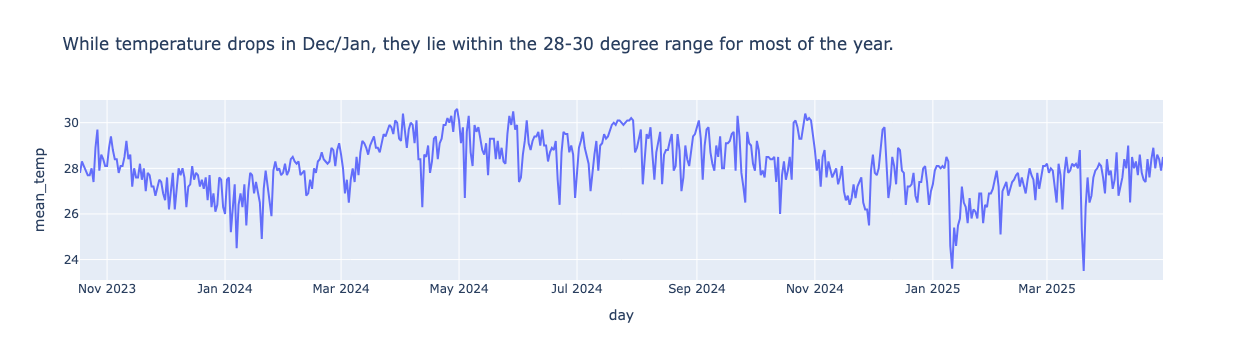

In [1518]:
# Let's look at how temperature has changed over the 561-day period
sg_temp = pd.DataFrame({
    'day': sg_wea['date'],
    'mean_temp': sg_wea['mean_temp']
})
px.line(sg_temp,x='day',y='mean_temp',title='While temperature drops in Dec/Jan, they lie within the 28-30 degree range for most of the year.', width=1000)

In [1301]:
# How about daily rainfall?
sg_daily_rain = pd.DataFrame({
    'day': sg_wea['date'],
    'daily_rainfall': sg_wea['total_rainfall'],
})
px.line(sg_daily_rain,x='day',y='daily_rainfall',title='Singapore Daily Rainfall')

In [1302]:
# How about weekly rainfall?
sg_weekly_rain = pd.DataFrame({
    'weekly_rainfall': sg_wea.groupby(sg_wea['date'].dt.to_period('W').dt.start_time)['total_rainfall'].sum()
})
sg_weekly_rain = (sg_weekly_rain.reset_index()
                  .rename(columns={'date':'week_start'}))
px.line(sg_weekly_rain,x='week_start',y='weekly_rainfall',title='There seems to be no clear pattern in weekly rainfall in Singapore')

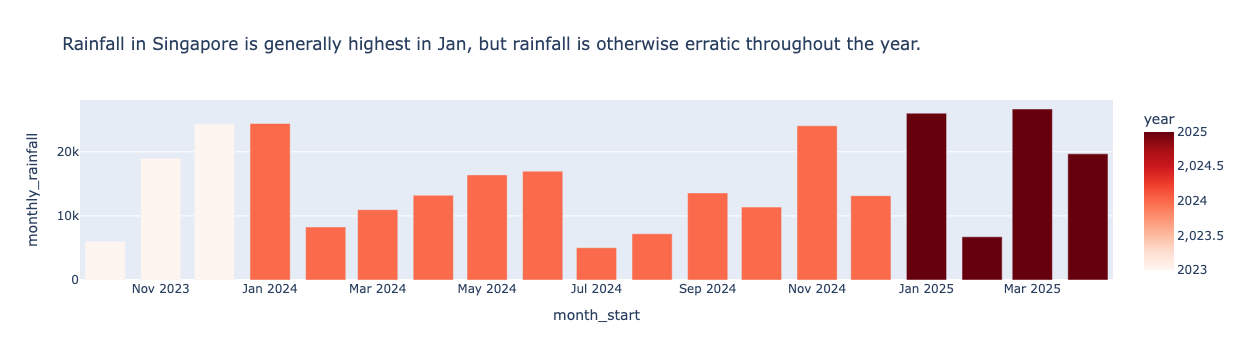

In [1520]:
# How about monthly rainfall?
sg_monthly_rain = pd.DataFrame({
    'monthly_rainfall': sg_wea.groupby(sg_wea['date'].dt.to_period('M').dt.start_time)['total_rainfall'].sum()
})
sg_monthly_rain = (sg_monthly_rain.reset_index()
                  .rename(columns={'date':'month_start'}))
sg_monthly_rain['year'] = sg_monthly_rain['month_start'].dt.year
px.bar(sg_monthly_rain,x='month_start',y='monthly_rainfall',color='year',color_continuous_scale=px.colors.sequential.Reds, title='Rainfall in Singapore is generally highest in Jan, but rainfall is otherwise erratic throughout the year.',width=1000)

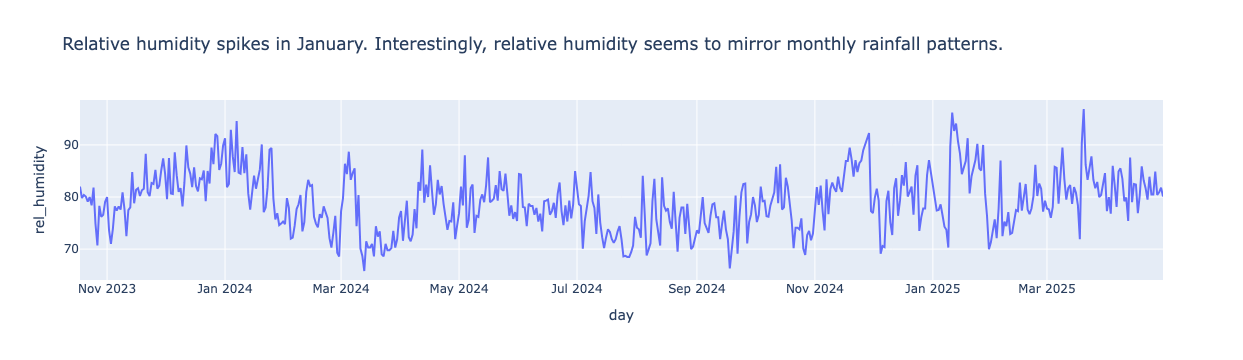

In [1522]:
# How about relative humidity?
sg_rh = pd.DataFrame({
    'day': sg_wea['date'],
    'rel_humidity': sg_wea['mean_rh']
})
px.line(sg_rh,x='day',y='rel_humidity',title='Relative humidity spikes in January. Interestingly, relative humidity seems to mirror monthly rainfall patterns.',width=1000)

In [1305]:
# How about wind speed?
sg_ws = pd.DataFrame({
    'day': sg_wea['date'],
    'mean_wind_speed': sg_wea['mean_ws'],
})
px.line(sg_ws,x='day',y='mean_wind_speed',title='Wind speeds are higher in Jan/Jul, and reach lows in Apr/May and Oct/Nov.')

In [1306]:
# I managed to find a dataset on sunlight hours on Data.gov
# NOTE: Monthly mean daily sunshine hours are not indicative of length of day. Low mean sunshine hours = higher cloud cover, rain, haze, etc.
sg_sun = pd.read_csv("/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/NEA API Dataframes (SG Weather)/data.sg_monthly_mean_daily_sunlight_duration.csv")
sg_sun_df = pd.DataFrame(sg_sun)
px.line(sg_sun_df,x='month',y='mean_sunshine_hrs',title='Data.gov Singapore Monthly Mean Daily Sunshine Hours')

Based on my EDA, I can conclude that the 3 weather metrics with the most pronounced general trends over time are:<br>
&nbsp;• **Relative Humidity**<br>
&nbsp;• **Temperature**<br>
&nbsp;• **Rainfall (Only including this as rainfall is such a big part of Singaporean weather)**<br>

Before we go any further, let's combine the Data.gov dataset on monthly mean daily sunshine hours to our sg_wea dataset. Because there is only one row per month in the Data.gov dataset, I need to create a new column in sg_wea that extracts year and month from 'date' to facilitate a left join between the Data.gov DF and sg_wea.

In [1308]:
sg_wea['month'] = sg_wea['date'].dt.to_period('M').dt.to_timestamp()
sg_wea['month']

0     2023-10-01
1     2023-10-01
2     2023-10-01
3     2023-10-01
4     2023-10-01
         ...    
556   2025-04-01
557   2025-04-01
558   2025-04-01
559   2025-04-01
560   2025-04-01
Name: month, Length: 561, dtype: datetime64[ns]

In [1309]:
sg_sun['month'] = pd.to_datetime(sg_sun['month'])
sg_sun.rename(columns={'mean_sunshine_hrs': 'mean_monthly_daily_sunshine_hrs'})

month  mean_monthly_daily_sunshine_hrs
0  2023-10-01                              7.2
1  2023-11-01                              4.6
2  2023-12-01                              3.6
3  2024-01-01                              4.3
4  2024-02-01                              7.9
5  2024-03-01                              7.1
6  2024-04-01                              6.3
7  2024-05-01                              4.9
8  2024-06-01                              4.8
9  2024-07-01                              6.8
10 2024-08-01                              5.2
11 2024-09-01                              5.9
12 2024-10-01                              5.0
13 2024-11-01                              4.3
14 2024-12-01                              4.6
15 2025-01-01                              3.6
16 2025-02-01                              7.0
17 2025-03-01                              5.2
18 2025-04-01                              6.2

In [1514]:
sg_wea = pd.merge(sg_wea,sg_sun,on='month')
sg_wea

date  min_temp  max_temp  mean_temp  mean_rainfall  total_rainfall  \
0   2023-10-18      23.6      33.9       27.8           15.7          1143.0   
1   2023-10-19      24.4      34.0       28.3            2.2           163.6   
2   2023-10-20      23.5      33.9       28.1            8.8           639.3   
3   2023-10-21      23.2      33.7       27.9            6.6           480.2   
4   2023-10-22      22.7      34.5       27.7            7.8           567.5   
..         ...       ...       ...        ...            ...             ...   
556 2025-04-26      24.0      33.0       28.0            3.7           273.1   
557 2025-04-27      24.3      34.5       28.6            3.8           277.1   
558 2025-04-28      23.6      34.4       28.4            5.9           432.1   
559 2025-04-29      22.8      35.2       27.9           14.8          1081.7   
560 2025-04-30      23.0      35.5       28.5           12.8           933.8   

     max_rh  min_rh  mean_rh  max_ws  min_ws  mean_ws      month  \
0      99.2    52.3     82.0    17.6     0.3      3.9 2023-10-01   
1      99.2    46.5     79.8    19.2     0.3      4.0 2023-10-01   
2      99.2    51.6     80.4    14.9     0.4      3.7 2023-10-01   
3      99.3    47.8     80.1    14.8     0.3      3.5 2023-10-01   
4      99.2    45.2     79.1    15.9     0.2      3.4 2023-10-01   
..      ...     ...      ...     ...     ...      ...        ...   
556    99.7    59.9     84.9    16.3     0.3      3.8 2025-04-01   
557    99.5    43.4     80.4    11.4     0.2      3.2 2025-04-01   
558    99.4    47.1     80.9    12.4     0.2      3.0 2025-04-01   
559    99.7    51.2     81.8    16.6     0.3      3.8 2025-04-01   
560   100.0    41.1     80.1    15.8     0.3      3.6 2025-04-01   

     mean_sunshine_hrs_x  mean_sunshine_hrs_y  
0                    7.2                  7.2  
1                    7.2                  7.2  
2                    7.2                  7.2  
3                    7.2                  7.2  
4                    7.2                  7.2  
..                   ...                  ...  
556                  6.2                  6.2  
557                  6.2                  6.2  
558                  6.2                  6.2  
559                  6.2                  6.2  
560                  6.2                  6.2  

[561 rows x 15 columns]

In [1311]:
# For backup's sake, let's save the cleaned dataset as a csv file
sg_wea.to_csv('sg_wea.csv')

In [1512]:
sg_wea.dtypes

date                 datetime64[ns]
min_temp                    float64
max_temp                    float64
mean_temp                   float64
mean_rainfall               float64
total_rainfall              float64
max_rh                      float64
min_rh                      float64
mean_rh                     float64
max_ws                      float64
min_ws                      float64
mean_ws                     float64
month                datetime64[ns]
mean_sunshine_hrs           float64
dtype: object

### 5.3 Creating a Dataset with Singapore's Spotify Data

In [837]:
# Now, let's create a copy of the dataset, but only filtered to include Singapore's 
sg_spotify_data = spotify_data[spotify_data['country'] == 'SG'].reset_index()
sg_spotify_data = sg_spotify_data.copy()

In [839]:
sg_spotify_data

index              spotify_id                   name  \
0          607  1XZE0InCx3SdCnLpVsPpZl  Jumping Machine (跳楼机)   
1          608  0fK7ie6XwGxQTIkpFoWkd1            like JENNIE   
2          609  7tI8dRuH2Yc6RuoTjxo4dU                    Who   
3          610  298LjjcBvuQCAlwUWb9dKb     像晴天像雨天（电视剧《难哄》心动曲）   
4          611  3be9ACTxtcL6Zm4vJRUiPG                   blue   
...        ...                     ...                    ...   
27006  1956130  5XeFesFbtLpXzIVDNQP22n       I Wanna Be Yours   
27007  1956131  7qEHsqek33rTcFNT9PFqLf      Someone You Loved   
27008  1956132  72OVnXDzugvrCU25lMi9au       如果可以 - 電影"月老"主題曲   
27009  1956133  2Zo1PcszsT9WQ0ANntJbID                Feather   
27010  1956134  1acVBP8BcK6LTeNeFjfxnh                seasons   

                 artists  daily_rank  daily_movement  weekly_movement country  \
0                  LBI利比           1              49               49      SG   
1                 JENNIE           2              48               48      SG   
2                  Jimin           3              47               47      SG   
3           Silence Wang           4              46               46      SG   
4               yung kai           5              45               45      SG   
...                  ...         ...             ...              ...     ...   
27006     Arctic Monkeys          46               4                0      SG   
27007      Lewis Capaldi          47               3                0      SG   
27008            WeiBird          48               2                0      SG   
27009  Sabrina Carpenter          49               1                0      SG   
27010      wave to earth          50               0                0      SG   

      snapshot_date  popularity  ...  key  loudness mode speechiness  \
0        2025-04-30          82  ...    6    -7.981    1      0.0290   
1        2025-04-30          96  ...   10    -5.321    0      0.0611   
2        2025-04-30          90  ...    0    -3.743    0      0.0320   
3        2025-04-30          78  ...    0    -5.817    1      0.0279   
4        2025-04-30          93  ...    4   -11.982    1      0.0342   
...             ...         ...  ...  ...       ...  ...         ...   
27006    2023-10-18          95  ...    0    -9.345    0      0.0256   
27007    2023-10-18          90  ...    1    -5.679    1      0.0319   
27008    2023-10-18          70  ...    3    -6.368    1      0.0290   
27009    2023-10-18          84  ...    6    -4.370    0      0.0339   
27010    2023-10-18          85  ...    7   -10.638    1      0.0272   

       acousticness  instrumentalness  liveness  valence    tempo  \
0           0.65900           0.00000    0.1720    0.351  127.939   
1           0.28100           0.00671    0.0868    0.815  130.019   
2           0.00289           0.00000    0.1930    0.838  116.034   
3           0.43100           0.00000    0.1740    0.385  127.984   
4           0.93300           0.01860    0.1210    0.585   97.490   
...             ...               ...       ...      ...      ...   
27006       0.13600           0.02200    0.0974    0.479   67.528   
27007       0.75100           0.00000    0.1050    0.446  109.891   
27008       0.24100           0.00000    0.3510    0.372   74.969   
27009       0.08930           0.00000    0.0927    0.836  123.510   
27010       0.78000           0.05870    0.2180    0.160   59.157   

       time_signature  
0                   4  
1                   4  
2                   4  
3                   4  
4                   3  
...               ...  
27006               4  
27007               4  
27008               4  
27009               4  
27010               4  

[27011 rows x 26 columns]

#### 5.3.1 Handling Duplicate Rows

Like the Japan dataset, the total number of rows cannot be divided by 50, indicating that there may be duplicates. There should be at least 11 rows of duplicates.

In [844]:
# Which dates have more than 50 rows of data?
sg_missing_dates = sg_spotify_data.groupby('snapshot_date').size()
sg_missing_dates[sg_missing_dates > 50]

snapshot_date
2023-10-27    52
2023-11-20    53
2024-03-14    52
2024-03-16    53
2024-03-18    51
dtype: int64

In [854]:
# Let's go through each of these dates to single out the duplicate rows
sgmissingdf1 = pd.DataFrame(sg_spotify_data[sg_spotify_data['snapshot_date'] == '2023-10-27'])
sgmissingdf1

index              spotify_id  \
26509  1923227  7x9aauaA9cu6tyfpHnqDLo   
26510  1923228  3rUGC1vUpkDG9CZFHMur1t   
26511  1923229  01qFKNWq73UfEslI0GvumE   
26512  1923230  1BxfuPKGuaTgP7aM0Bbdwr   
26513  1923231  0rKWJnmo6Q0ovoPOLoLm0t   
26514  1923232  3vkCueOmm7xQDoJ17W1Pm3   
26515  1923233  5PyDJG7SQRgWXefgexqIge   
26516  1923234  4MTNimMDRyFZv37Thcktwa   
26517  1923235  6gcuJpHu0Ey30D5WR76y98   
26518  1923236  5mjYQaktjmjcMKcUIcqz4s   
26519  1923237  5sdQOyqq2IDhvmx2lHOpwd   
26520  1923238  56y1jOTK0XSvJzVv9vHQBK   
26521  1923239  5Rzpn60KTM11EBETHaF9Kt   
26522  1923240  7uyeEbG6hyApgXuEypGcsZ   
26523  1923241  5aIVCx5tnk0ntmdiinnYvw   
26524  1923242  6dgUya35uo964z7GZXM07g   
26525  1923243  5h1BN75CEh8wdSwE1xrbSe   
26526  1923244  4lIxdJw6W3Fg4vUIYCB0S5   
26527  1923245  7CyPwkp0oE8Ro9Dd5CUDjW   
26528  1923246  1kuGVB7EU95pJObxwvfwKS   
26529  1923247  6I3mqTwhRpn34SLVafSH7G   
26530  1923248  5Eh1nj7IjV9lwpcKAkidyY   
26531  1923249  3Ua0m0YmEjrMi9XErKcNiR   
26532  1923250  6wf7Yu7cxBSPrRlWeSeK0Q   
26533  1923251  1p80LdxRV74UKvL8gnD7ky   
26534  1923252  7fAdinC2UTc0Y9GiKrkTtu   
26535  1923253  1Qrg8KqiBpW07V7PNxwwwL   
26536  1923254  210JJAa9nJOgNa0YNrsT5g   
26537  1923255  29WxJqIfDRMo9isV07kbJP   
26538  1923256  2N0SPREDYqILVEFSsWF5N5   
26539  1923257  65FftemJ1DbbZ45DUfHJXE   
26540  1923258  739WUU1tPFLO4x4HJq561K   
26541  1923259  0V3wPSX9ygBnCm8psDIegu   
26542  1923260  4uOBL4DDWWVx4RhYKlPbPC   
26543  1923261  3oTDi9MWC0JB39FcsLRon3   
26544  1923262  3G7MgLuWLzUJQflWOCDZit   
26545  1923263  5odlY52u43F5BjByhxg7wg   
26546  1923264  4Dvkj6JhhA12EX05fT7y2e   
26547  1923265  3t5edAHbyFEW67wFApp7EO   
26548  1923266  4iZ4pt7kvcaH6Yo8UoZ4s2   
26549  1923267  567e29TDzLwZwfDuEpGTwo   
26550  1923268  3r8RuvgbX9s7ammBn07D3W   
26551  1923269  1vYXt7VSjH9JIM5oRRo7vA   
26552  1923270  1RMnVmHGSvxlexnenQEXSb   
26553  1923271  5XeFesFbtLpXzIVDNQP22n   
26554  1923272  0QzuaeCEEOV40Pn7IvKEny   
26555  1923273  56v8WEnGzLByGsDAXDiv4d   
26556  1923274  1acVBP8BcK6LTeNeFjfxnh   
26557  1923275  1IVj6CsBbTgOEpo0W6hgwN   
26558  1923276  72OVnXDzugvrCU25lMi9au   
26559  1923277  1dGr1c8CrMLDpV6mPbImSI   
26560  1923278  7qEHsqek33rTcFNT9PFqLf   

                                                    name  \
26509                Seven (feat. Latto) (Explicit Ver.)   
26510                                             greedy   
26511                             3D (feat. Jack Harlow)   
26512                                       Cruel Summer   
26513                                           TOO MUCH   
26514                              My Love Mine All Mine   
26515                                        Agora Hills   
26516                                       God of Music   
26517                                           You & Me   
26518                                          Strangers   
26519                                          Super Shy   
26520                                 Paint The Town Red   
26521                                                我会等   
26522                                             Baddie   
26523                                              Water   
26524                                           Nonsense   
26525                                       Slow Dancing   
26526                                              Style   
26527     One Of The Girls (with JENNIE, Lily Rose Depp)   
26528                                            vampire   
26529                                              Ghost   
26530                                  One Of Your Girls   
26531                                         Like Crazy   
26532  What Was I Made For? [From The Motion Picture ...   
26533                                        Blank Space   
26534                                               字字句句   
26535                                          Kill Bill   
26536                                               GODS   
26537                                     

In [882]:
dup_col_lst = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']
sgmissingdf1.duplicated(subset=dup_col_lst,keep='first')

26509    False
26510    False
26511    False
26512    False
26513    False
26514    False
26515    False
26516    False
26517    False
26518    False
26519    False
26520    False
26521    False
26522    False
26523    False
26524    False
26525    False
26526    False
26527    False
26528    False
26529    False
26530    False
26531    False
26532    False
26533    False
26534    False
26535    False
26536    False
26537    False
26538    False
26539    False
26540    False
26541    False
26542    False
26543    False
26544    False
26545    False
26546    False
26547    False
26548    False
26549    False
26550    False
26551    False
26552    False
26553    False
26554    False
26555    False
26556    False
26557    False
26558    False
26559    False
26560    False
dtype: bool

In [884]:
sgmissingdf2 = pd.DataFrame(sg_spotify_data[sg_spotify_data['snapshot_date'] == '2023-11-20'])
sgmissingdf2.duplicated(subset=dup_col_lst,keep='first')

25306    False
25307    False
25308    False
25309    False
25310    False
25311    False
25312    False
25313    False
25314    False
25315    False
25316    False
25317    False
25318    False
25319    False
25320    False
25321    False
25322    False
25323    False
25324    False
25325    False
25326    False
25327    False
25328    False
25329    False
25330    False
25331    False
25332    False
25333    False
25334    False
25335    False
25336    False
25337    False
25338    False
25339    False
25340    False
25341    False
25342    False
25343    False
25344    False
25345    False
25346    False
25347    False
25348    False
25349    False
25350    False
25351    False
25352    False
25353    False
25354    False
25355    False
25356    False
25357    False
25358    False
dtype: bool

In [886]:
sgmissingdf3 = pd.DataFrame(sg_spotify_data[sg_spotify_data['snapshot_date'] == '2024-03-14'])
sgmissingdf3.duplicated(subset=dup_col_lst,keep='first')

19554    False
19555    False
19556    False
19557    False
19558    False
19559    False
19560    False
19561    False
19562    False
19563    False
19564    False
19565    False
19566    False
19567    False
19568    False
19569    False
19570    False
19571    False
19572    False
19573    False
19574    False
19575    False
19576    False
19577    False
19578    False
19579    False
19580    False
19581    False
19582    False
19583    False
19584    False
19585    False
19586    False
19587    False
19588    False
19589    False
19590    False
19591    False
19592    False
19593    False
19594    False
19595    False
19596    False
19597    False
19598    False
19599    False
19600    False
19601    False
19602    False
19603    False
19604    False
19605    False
dtype: bool

In [888]:
sgmissingdf4 = pd.DataFrame(sg_spotify_data[sg_spotify_data['snapshot_date'] == '2024-03-16'])
sgmissingdf4.duplicated(subset=dup_col_lst,keep='first')

19501    False
19502    False
19503    False
19504    False
19505    False
19506    False
19507    False
19508    False
19509    False
19510    False
19511    False
19512    False
19513    False
19514    False
19515    False
19516    False
19517    False
19518    False
19519    False
19520    False
19521    False
19522    False
19523    False
19524    False
19525    False
19526    False
19527    False
19528    False
19529    False
19530    False
19531    False
19532    False
19533    False
19534    False
19535    False
19536    False
19537    False
19538    False
19539    False
19540    False
19541    False
19542    False
19543    False
19544    False
19545    False
19546    False
19547    False
19548    False
19549    False
19550    False
19551    False
19552    False
19553    False
dtype: bool

In [890]:
sgmissingdf5 = pd.DataFrame(sg_spotify_data[sg_spotify_data['snapshot_date'] == '2024-03-18'])
sgmissingdf5.duplicated(subset=dup_col_lst,keep='first')

19450    False
19451    False
19452    False
19453    False
19454    False
19455    False
19456    False
19457    False
19458    False
19459    False
19460    False
19461    False
19462    False
19463    False
19464    False
19465    False
19466    False
19467    False
19468    False
19469    False
19470    False
19471    False
19472    False
19473    False
19474    False
19475    False
19476    False
19477    False
19478    False
19479    False
19480    False
19481    False
19482    False
19483    False
19484    False
19485    False
19486    False
19487    False
19488    False
19489    False
19490    False
19491    False
19492    False
19493    False
19494    False
19495    False
19496    False
19497    False
19498    False
19499    False
19500    False
dtype: bool

Even though the dates highlighted earlier have more than 50 rows of data, no duplicate songs can be found based on the music characteristics in 'dup_col_lst'. 

Because there are no duplicates, we shall not delete any rows of data.

#### 5.3.2 Correcting Wrong Formats

In [893]:
# Let's start by having a bird's eye view of sg_spotify_data
sg_spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27011 entries, 0 to 27010
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               27011 non-null  int64  
 1   spotify_id          27011 non-null  object 
 2   name                27011 non-null  object 
 3   artists             27011 non-null  object 
 4   daily_rank          27011 non-null  int64  
 5   daily_movement      27011 non-null  int64  
 6   weekly_movement     27011 non-null  int64  
 7   country             27011 non-null  object 
 8   snapshot_date       27011 non-null  object 
 9   popularity          27011 non-null  int64  
 10  is_explicit         27011 non-null  bool   
 11  duration_ms         27011 non-null  int64  
 12  album_name          26981 non-null  object 
 13  album_release_date  27011 non-null  object 
 14  danceability        27011 non-null  float64
 15  energy              27011 non-null  float64
 16  key 

In [895]:
# Let's turn the date-related data ('snapshot_date' & 'album_release_date') to datetime format.
sg_spotify_data['snapshot_date'] = pd.to_datetime(sg_spotify_data['snapshot_date'])
sg_spotify_data['album_release_date'] = pd.to_datetime(sg_spotify_data['album_release_date'])
sg_spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27011 entries, 0 to 27010
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               27011 non-null  int64         
 1   spotify_id          27011 non-null  object        
 2   name                27011 non-null  object        
 3   artists             27011 non-null  object        
 4   daily_rank          27011 non-null  int64         
 5   daily_movement      27011 non-null  int64         
 6   weekly_movement     27011 non-null  int64         
 7   country             27011 non-null  object        
 8   snapshot_date       27011 non-null  datetime64[ns]
 9   popularity          27011 non-null  int64         
 10  is_explicit         27011 non-null  bool          
 11  duration_ms         27011 non-null  int64         
 12  album_name          26981 non-null  object        
 13  album_release_date  27011 non-null  datetime64

In [897]:
# Here, we see that 'is_explicit' is a boolean column with 'true' and 'false' values.
sg_spotify_data['is_explicit']

0        False
1         True
2        False
3        False
4        False
         ...  
27006    False
27007    False
27008    False
27009     True
27010    False
Name: is_explicit, Length: 27011, dtype: bool

In [899]:
# Let's convert 'is_explicit' to binary form
sg_spotify_data['is_explicit'] = sg_spotify_data['is_explicit'].astype(int)

In [901]:
sg_spotify_data['is_explicit']

0        0
1        1
2        0
3        0
4        0
        ..
27006    0
27007    0
27008    0
27009    1
27010    0
Name: is_explicit, Length: 27011, dtype: int64

#### 5.3.3 Handling Null Values

In [903]:
# There are 30 null values under 'album_name'. Let's find out what they are.
sg_spotify_data[sg_spotify_data['album_name'].isnull()]

index              spotify_id  name artists  daily_rank  \
13548   977421  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          49   
13649   984722  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          50   
13698   988371  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          49   
13737   992010  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          38   
13782   995655  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          33   
13833   999306  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          34   
13885  1002958  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          36   
13935  1006558  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          36   
13983  1010206  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          34   
14027  1013850  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          28   
14077  1017500  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          28   
14126  1021149  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          27   
14173  1024796  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          24   
14222  1028445  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          23   
14273  1032096  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          24   
14322  1035745  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          23   
14370  1039393  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          21   
14421  1043044  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          22   
14470  1046693  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          21   
14520  1050343  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          21   
14567  1053990  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          18   
14619  1057642  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          20   
14668  1061291  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          19   
14719  1064942  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          20   
14766  1068589  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          17   
14815  1072238  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          16   
14866  1075889  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          17   
14917  1079540  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          18   
14972  1083195  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          23   
15027  1086850  53rB05bAi7JdNbUfgz72I1  ABCD  NAYEON          28   

       daily_movement  weekly_movement country snapshot_date  popularity  ...  \
13548               1              -13      SG    2024-07-16          67  ...   
13649              -1              -16      SG    2024-07-14          68  ...   
13698             -11              -21      SG    2024-07-13          67  ...   
13737              -5              -10      SG    2024-07-12          67  ...   
13782               1               -6      SG    2024-07-11          67  ...   
13833               2              -10      SG    2024-07-10          67  ...   
13885               0              -13      SG    2024-07-09          67  ...   
13935              -2              -12      SG    2024-07-08          67  ...   
13983              -6              -11      SG    2024-07-07          67  ...   
14027               0               -7      SG    2024-07-06          67  ...   
14077              -1               -6      SG    2024-07-05          66  ...   
14126              -3               -6      SG    2024-07-04          66  ...   
14173              -1               -3      SG    2024-07-03          66  ...   
14222               1               -5      SG    2024-07-02          65  ...   
14273              -1               -4      SG    2024-07-01          64  ...   
14322              -2               -4      SG    2024-06-30          63  ...   
14370               1               -1      SG    2024-06-29          63  ...   
14421              -1               -5      SG    2024-06-28          62  ...   
14470               0               -5      SG    2024-06-27          61  ...   
14520              -3               -4      SG    2024-06-26          60  ...   
14567               2                0      SG    2024-06-25          59  ...   
14619              -1                3      SG    2024-06-24          58  ...   
14668               1                

In [905]:
# Since all the entries with missing 'album_name' data are the same, I can simply impute the album name to these entries.
# A brief search revealed that NAYEON's 'ABCD' was released on an EP literally called 'Na' (not to be confused with N/A).
# Let's first check if the 'album_release_date' of these rows matches the date the EP was released (14 June 2024)
sg_spotify_data[sg_spotify_data['album_name'].isnull()]['album_release_date']

13548   2024-06-14
13649   2024-06-14
13698   2024-06-14
13737   2024-06-14
13782   2024-06-14
13833   2024-06-14
13885   2024-06-14
13935   2024-06-14
13983   2024-06-14
14027   2024-06-14
14077   2024-06-14
14126   2024-06-14
14173   2024-06-14
14222   2024-06-14
14273   2024-06-14
14322   2024-06-14
14370   2024-06-14
14421   2024-06-14
14470   2024-06-14
14520   2024-06-14
14567   2024-06-14
14619   2024-06-14
14668   2024-06-14
14719   2024-06-14
14766   2024-06-14
14815   2024-06-14
14866   2024-06-14
14917   2024-06-14
14972   2024-06-14
15027   2024-06-14
Name: album_release_date, dtype: datetime64[ns]

In [907]:
sg_spotify_data.loc[(sg_spotify_data['name'] == 'ABCD') & (sg_spotify_data['album_name'].isnull()),'album_name'] = 'Na'

In [911]:
# There are no more null values in the dataset!
sg_spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27011 entries, 0 to 27010
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               27011 non-null  int64         
 1   spotify_id          27011 non-null  object        
 2   name                27011 non-null  object        
 3   artists             27011 non-null  object        
 4   daily_rank          27011 non-null  int64         
 5   daily_movement      27011 non-null  int64         
 6   weekly_movement     27011 non-null  int64         
 7   country             27011 non-null  object        
 8   snapshot_date       27011 non-null  datetime64[ns]
 9   popularity          27011 non-null  int64         
 10  is_explicit         27011 non-null  int64         
 11  duration_ms         27011 non-null  int64         
 12  album_name          27011 non-null  object        
 13  album_release_date  27011 non-null  datetime64

#### 5.3.4 Checking for Missing Dates

In [913]:
# Let's see if there are any dates missing from the data.
sg_spotify_data['snapshot_date'].unique()

<DatetimeArray>
['2025-04-30 00:00:00', '2025-04-21 00:00:00', '2025-04-20 00:00:00',
 '2025-04-19 00:00:00', '2025-04-18 00:00:00', '2025-04-17 00:00:00',
 '2025-04-16 00:00:00', '2025-04-15 00:00:00', '2025-04-14 00:00:00',
 '2025-04-13 00:00:00',
 ...
 '2023-10-27 00:00:00', '2023-10-26 00:00:00', '2023-10-25 00:00:00',
 '2023-10-24 00:00:00', '2023-10-23 00:00:00', '2023-10-22 00:00:00',
 '2023-10-21 00:00:00', '2023-10-20 00:00:00', '2023-10-19 00:00:00',
 '2023-10-18 00:00:00']
Length: 540, dtype: datetime64[ns]

In [915]:
# The code above tells us that there are only 540/561 days accounted for. Let's find out what the missing 21 days are
date_range = pd.date_range(start='2023-10-18', end='2025-04-30').to_list()

missing_sg = missing_dates(date_range,sg_spotify_data['snapshot_date'])
missing_sg

[Timestamp('2024-03-15 00:00:00'),
 Timestamp('2024-03-17 00:00:00'),
 Timestamp('2024-04-22 00:00:00'),
 Timestamp('2024-11-28 00:00:00'),
 Timestamp('2024-11-29 00:00:00'),
 Timestamp('2024-11-30 00:00:00'),
 Timestamp('2024-12-01 00:00:00'),
 Timestamp('2024-12-02 00:00:00'),
 Timestamp('2024-12-03 00:00:00'),
 Timestamp('2024-12-04 00:00:00'),
 Timestamp('2024-12-05 00:00:00'),
 Timestamp('2024-12-07 00:00:00'),
 Timestamp('2024-12-08 00:00:00'),
 Timestamp('2025-04-22 00:00:00'),
 Timestamp('2025-04-23 00:00:00'),
 Timestamp('2025-04-24 00:00:00'),
 Timestamp('2025-04-25 00:00:00'),
 Timestamp('2025-04-26 00:00:00'),
 Timestamp('2025-04-27 00:00:00'),
 Timestamp('2025-04-28 00:00:00'),
 Timestamp('2025-04-29 00:00:00')]

In [917]:
len(missing_sg)

21

In [919]:
# As the dataset has mandarin characters, the new dataframe must be encoded such that Excel is forced to read the mandarin characters in utf-8 format. 
# This explains the "encoding='utf-8-sig'"
sg_spotify_data.to_csv('sg_spotify_data.csv',index=False,encoding='utf-8-sig')

### 5.4 SG Hierarchical Clustering

#### 5.4.1 Saving a Dataframe with only distinct songs from the sg_spotify dataset

In [13]:
sg_spotify = pd.read_csv("/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/Final Datasets/sg_spotify_data.csv")
sg_spotify

index              spotify_id                   name  \
0          607  1XZE0InCx3SdCnLpVsPpZl  Jumping Machine (跳楼机)   
1          608  0fK7ie6XwGxQTIkpFoWkd1            like JENNIE   
2          609  7tI8dRuH2Yc6RuoTjxo4dU                    Who   
3          610  298LjjcBvuQCAlwUWb9dKb     像晴天像雨天（电视剧《难哄》心动曲）   
4          611  3be9ACTxtcL6Zm4vJRUiPG                   blue   
...        ...                     ...                    ...   
27006  1956130  5XeFesFbtLpXzIVDNQP22n       I Wanna Be Yours   
27007  1956131  7qEHsqek33rTcFNT9PFqLf      Someone You Loved   
27008  1956132  72OVnXDzugvrCU25lMi9au       如果可以 - 電影"月老"主題曲   
27009  1956133  2Zo1PcszsT9WQ0ANntJbID                Feather   
27010  1956134  1acVBP8BcK6LTeNeFjfxnh                seasons   

                 artists  daily_rank  daily_movement  weekly_movement country  \
0                  LBI利比           1              49               49      SG   
1                 JENNIE           2              48               48      SG   
2                  Jimin           3              47               47      SG   
3           Silence Wang           4              46               46      SG   
4               yung kai           5              45               45      SG   
...                  ...         ...             ...              ...     ...   
27006     Arctic Monkeys          46               4                0      SG   
27007      Lewis Capaldi          47               3                0      SG   
27008            WeiBird          48               2                0      SG   
27009  Sabrina Carpenter          49               1                0      SG   
27010      wave to earth          50               0                0      SG   

      snapshot_date  popularity  ...  key  loudness mode speechiness  \
0        2025-04-30          82  ...    6    -7.981    1      0.0290   
1        2025-04-30          96  ...   10    -5.321    0      0.0611   
2        2025-04-30          90  ...    0    -3.743    0      0.0320   
3        2025-04-30          78  ...    0    -5.817    1      0.0279   
4        2025-04-30          93  ...    4   -11.982    1      0.0342   
...             ...         ...  ...  ...       ...  ...         ...   
27006    2023-10-18          95  ...    0    -9.345    0      0.0256   
27007    2023-10-18          90  ...    1    -5.679    1      0.0319   
27008    2023-10-18          70  ...    3    -6.368    1      0.0290   
27009    2023-10-18          84  ...    6    -4.370    0      0.0339   
27010    2023-10-18          85  ...    7   -10.638    1      0.0272   

       acousticness  instrumentalness  liveness  valence    tempo  \
0           0.65900           0.00000    0.1720    0.351  127.939   
1           0.28100           0.00671    0.0868    0.815  130.019   
2           0.00289           0.00000    0.1930    0.838  116.034   
3           0.43100           0.00000    0.1740    0.385  127.984   
4           0.93300           0.01860    0.1210    0.585   97.490   
...             ...               ...       ...      ...      ...   
27006       0.13600           0.02200    0.0974    0.479   67.528   
27007       0.75100           0.00000    0.1050    0.446  109.891   
27008       0.24100           0.00000    0.3510    0.372   74.969   
27009       0.08930           0.00000    0.0927    0.836  123.510   
27010       0.78000           0.05870    0.2180    0.160   59.157   

       time_signature  
0                   4  
1                   4  
2                   4  
3                   4  
4                   3  
...               ...  
27006               4  
27007               4  
27008               4  
27009               4  
27010               4  

[27011 rows x 26 columns]

In [14]:
# Let's make a new segment of the jp_spotify dataset that only has the latest snapshot of each distinct song
music_features = ['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','valence','tempo']

sg_spotify_sorted = sg_spotify.sort_values(by=['name','artists','snapshot_date']).copy()
sg_spotify_sorted['name'] = sg_spotify_sorted['name'].str.strip()
sg_spotify_sorted['artists'] = sg_spotify_sorted['artists'].str.strip()
sg_spotify_sorted_last = sg_spotify_sorted.drop_duplicates(subset=['name','artists'], keep='last')
sg_song_features_df = sg_spotify_sorted_last[['name','artists']+music_features].reset_index(drop=True)
sg_song_features_df

name            artists  \
0    "Slut!" (Taylor's Version) (From The Vault)       Taylor Swift   
1                               ...Ready For It?       Taylor Swift   
2                                1-800-hot-n-fun        LE SSERAFIM   
3                                     15 Minutes  Sabrina Carpenter   
4                                        2 hands         Tate McRae   
..                                           ...                ...   
673                         跳楼机（Jumping Machine）              LBI利比   
674                                    这是你期盼的长大吗                ZQS   
675                                   過了幾天 - 合唱版       郭家瑋, DIOR 大穎   
676                                    過了幾天(合唱版)       郭家瑋, DIOR 大穎   
677                              보나마나 (BONAMANA)           G-DRAGON   

     danceability  energy  loudness  mode  speechiness  acousticness  \
0           0.629   0.413   -13.178     1       0.0550       0.34500   
1           0.613   0.764    -6.509     1       0.1360       0.05270   
2           0.752   0.892    -3.100     1       0.1080       0.07860   
3           0.581   0.888    -3.795     1       0.0714       0.00946   
4           0.608   0.806    -3.443     1       0.0486       0.12100   
..            ...     ...       ...   ...          ...           ...   
673         0.605   0.530    -7.981     1       0.0290       0.65900   
674         0.636   0.503    -8.563     1       0.0338       0.67800   
675         0.391   0.473    -8.272     1       0.0339       0.85000   
676         0.347   0.470    -8.289     1       0.0338       0.84600   
677         0.800   0.389    -9.987     0       0.0550       0.52300   

     instrumentalness  valence    tempo  
0            0.000076    0.306   77.983  
1            0.000000    0.417  160.015  
2            0.000000    0.880  135.953  
3            0.000000    0.731  132.002  
4            0.000000    0.587  104.032  
..                ...      ...      ...  
673          0.000000    0.351  127.939  
674          0.000000    0.519  120.024  
675          0.000000    0.244  145.842  
676          0.000000    0.231  145.314  
677          0.000000    0.685  129.861  

[678 rows x 11 columns]

In [15]:
# This serves to confirm that there are no duplicate rows; the check below returns the same number of rows as the dataframe.
sg_song_features_df[sg_song_features_df.duplicated() == False]

name            artists  \
0    "Slut!" (Taylor's Version) (From The Vault)       Taylor Swift   
1                               ...Ready For It?       Taylor Swift   
2                                1-800-hot-n-fun        LE SSERAFIM   
3                                     15 Minutes  Sabrina Carpenter   
4                                        2 hands         Tate McRae   
..                                           ...                ...   
673                         跳楼机（Jumping Machine）              LBI利比   
674                                    这是你期盼的长大吗                ZQS   
675                                   過了幾天 - 合唱版       郭家瑋, DIOR 大穎   
676                                    過了幾天(合唱版)       郭家瑋, DIOR 大穎   
677                              보나마나 (BONAMANA)           G-DRAGON   

     danceability  energy  loudness  mode  speechiness  acousticness  \
0           0.629   0.413   -13.178     1       0.0550       0.34500   
1           0.613   0.764    -6.509     1       0.1360       0.05270   
2           0.752   0.892    -3.100     1       0.1080       0.07860   
3           0.581   0.888    -3.795     1       0.0714       0.00946   
4           0.608   0.806    -3.443     1       0.0486       0.12100   
..            ...     ...       ...   ...          ...           ...   
673         0.605   0.530    -7.981     1       0.0290       0.65900   
674         0.636   0.503    -8.563     1       0.0338       0.67800   
675         0.391   0.473    -8.272     1       0.0339       0.85000   
676         0.347   0.470    -8.289     1       0.0338       0.84600   
677         0.800   0.389    -9.987     0       0.0550       0.52300   

     instrumentalness  valence    tempo  
0            0.000076    0.306   77.983  
1            0.000000    0.417  160.015  
2            0.000000    0.880  135.953  
3            0.000000    0.731  132.002  
4            0.000000    0.587  104.032  
..                ...      ...      ...  
673          0.000000    0.351  127.939  
674          0.000000    0.519  120.024  
675          0.000000    0.244  145.842  
676          0.000000    0.231  145.314  
677          0.000000    0.685  129.861  

[678 rows x 11 columns]

In [1317]:
# Save for safety's sake
sg_song_features_df.to_csv('sg_song_features_df.csv',encoding='utf-8-sig',index=False)

In [19]:
# Let's apply scaling the songs' measures so only the weightages are considered
music_features = ['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','valence','tempo']

scaler_2 = MinMaxScaler()
scaler_2_df = scaler_2.fit_transform(sg_song_features_df[music_features])
final_sg_spot_df1 = pd.concat([sg_song_features_df[['name', 'artists']], pd.DataFrame(scaler_2_df,
                  columns=music_features)], axis=1)
final_sg_spot_df1

name            artists  \
0    "Slut!" (Taylor's Version) (From The Vault)       Taylor Swift   
1                               ...Ready For It?       Taylor Swift   
2                                1-800-hot-n-fun        LE SSERAFIM   
3                                     15 Minutes  Sabrina Carpenter   
4                                        2 hands         Tate McRae   
..                                           ...                ...   
673                         跳楼机（Jumping Machine）              LBI利比   
674                                    这是你期盼的长大吗                ZQS   
675                                   過了幾天 - 合唱版       郭家瑋, DIOR 大穎   
676                                    過了幾天(合唱版)       郭家瑋, DIOR 大穎   
677                              보나마나 (BONAMANA)           G-DRAGON   

     danceability    energy  loudness  mode  speechiness  acousticness  \
0        0.598465  0.389923  0.306178   1.0     0.059797      0.355608   
1        0.578005  0.759125  0.699304   1.0     0.212110      0.054239   
2        0.755754  0.893762  0.900259   1.0     0.159458      0.080942   
3        0.537084  0.889555  0.859290   1.0     0.090636      0.009657   
4        0.571611  0.803303  0.880040   1.0     0.047762      0.124658   
..            ...       ...       ...   ...          ...           ...   
673      0.567775  0.512990  0.612532   1.0     0.010906      0.679350   
674      0.607417  0.484590  0.578224   1.0     0.019932      0.698940   
675      0.294118  0.453035  0.595378   1.0     0.020120      0.876277   
676      0.237852  0.449879  0.594376   1.0     0.019932      0.872153   
677      0.817136  0.364679  0.494282   0.0     0.059797      0.539131   

     instrumentalness   valence     tempo  
0            0.000087  0.289297  0.159086  
1            0.000000  0.407747  0.689430  
2            0.000000  0.901825  0.533867  
3            0.000000  0.742824  0.508324  
4            0.000000  0.589158  0.327495  
..                ...       ...       ...  
673          0.000000  0.337317  0.482056  
674          0.000000  0.516594  0.430885  
675          0.000000  0.223135  0.597801  
676          0.000000  0.209263  0.594387  
677          0.000000  0.693736  0.494482  

[678 rows x 11 columns]

#### 5.4.2 Clustering & Dendrogram Visualisation

At this stage, **we must acknowledge that Singapore's listening habits happen to be far more varied and diverse than Japan**. <br>

Between 18 October 2023 and 30 April 2025, Japan was noted to only include over 247 distinct songs in its daily Top 50 lists. On the other hand, Singapore's daily Top 50 lists featured a total of over 600 distinct songs during the same time period.<br>

This may be a reflection of Singapore's multicultural landscape, which has several impacts:<br>
1. The diverse mix of ethnicities (ie not merely East Asian) means that songs from a wider variety languages can be included in the Top 50 (Malay- or Bahasa-language songs, for example)
2. The mostly English-speaking Singaporean population could mean that listeners would be open to a wider range of English-language songs
3. Being within the sphere of influence of larger Asian cultural industries (most notably from Korea, Japan, China and Taiwan) means that Singapore's daily Top 50 would also include much of the Korean and Japanese songs included in Japan's Top 50 lists.

Because of the wider variety and higher volume of distinct songs in Singapore's data, clustering is approached differently by default: setting the distance threshold at '2' returned 16 clusters, rather than Japan's 9. An early attempt to cluster Singapore's distinct songs using the same number of clusters as Japan's data reaturned clusters with less distinct musical characteristics. Thus, I shall continue with the 16 clusters returned.

/var/folders/sj/z78m7tkn1jjd56jw9nsfy1100000gn/T/ipykernel_46329/2250182251.py:15: UserWarning: Glyph 10084 (\N{HEAVY BLACK HEART}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/var/folders/sj/z78m7tkn1jjd56jw9nsfy1100000gn/T/ipykernel_46329/2250182251.py:15: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10084 (\N{HEAVY BLACK HEART}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)


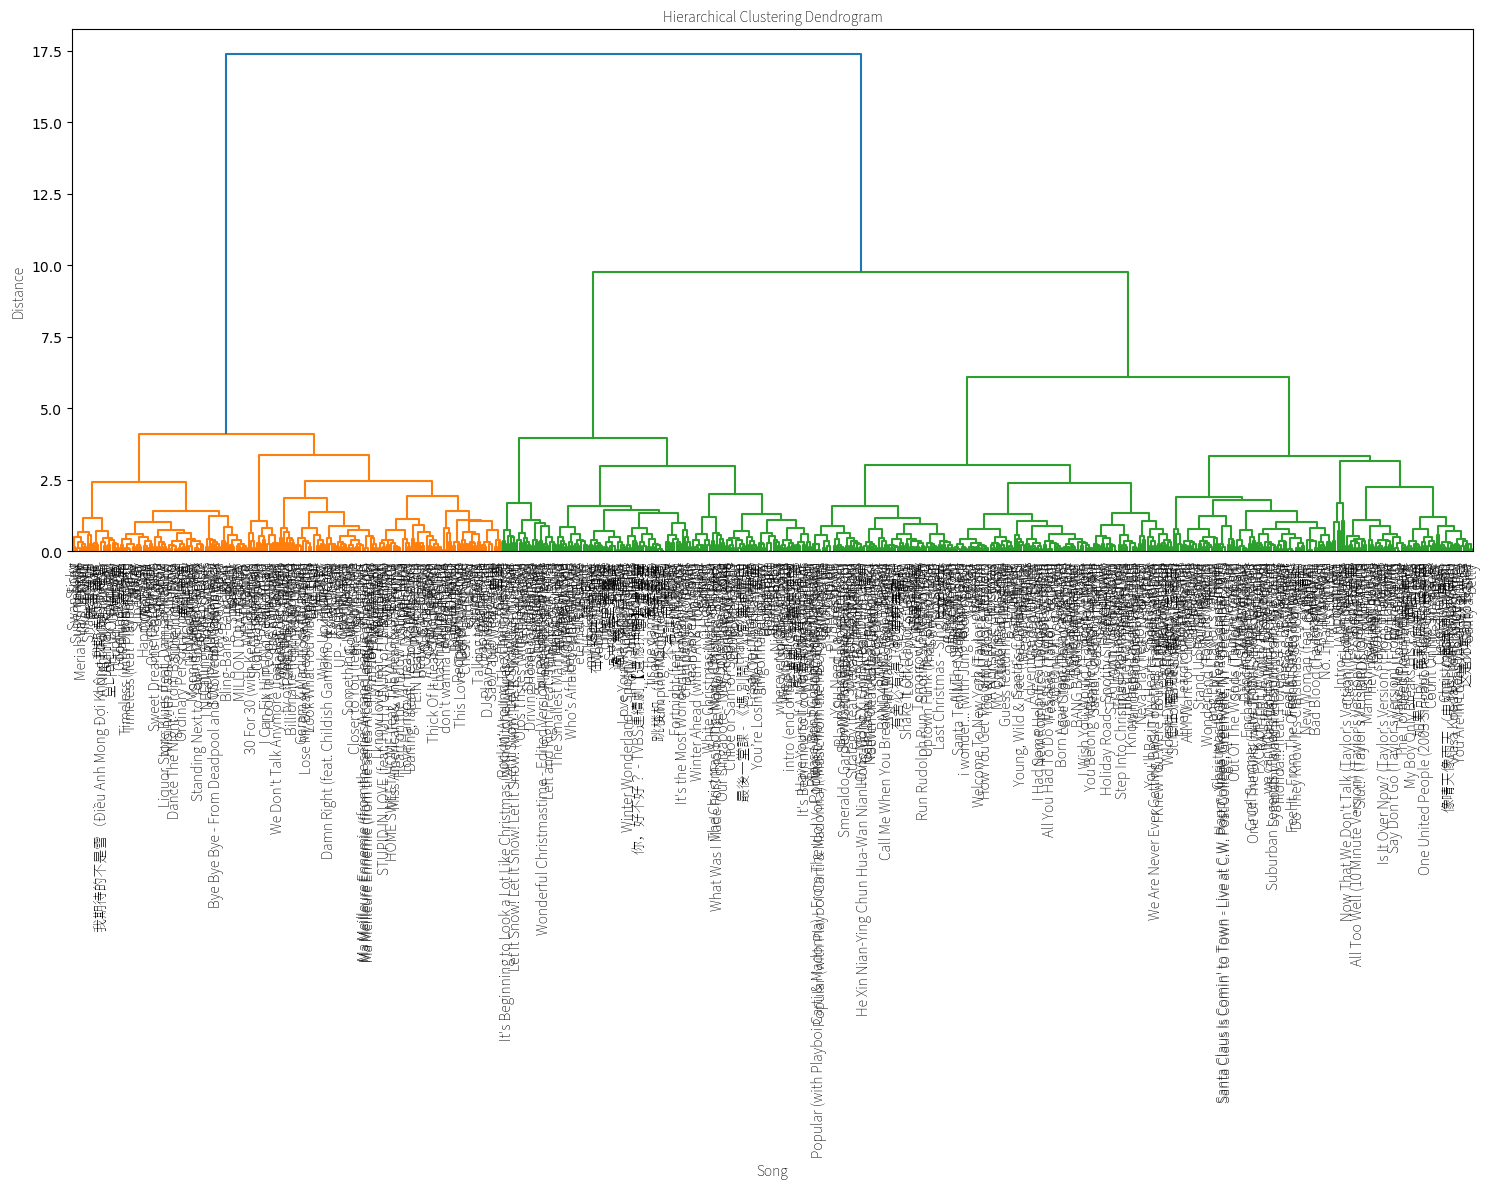

In [22]:
linked2 = linkage(final_sg_spot_df1[music_features], method='ward')  # Ward minimizes variance within clusters

sg_font = fm.FontProperties(fname="/Users/elimatthewordonez/Library/Fonts/NotoSansCJK-VF.ttf.ttc")

# Let's plot a dendrogram!
plt.figure(figsize=(15, 12))
dendrogram(linked2, 
           labels=final_sg_spot_df1['name'].values, 
           leaf_rotation=90, 
           leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram',fontproperties=sg_font)
plt.xlabel('Song',fontproperties=sg_font)
plt.ylabel('Distance',fontproperties=sg_font)
plt.xticks(fontproperties=sg_font)
plt.tight_layout()
plt.show()

In [23]:
# Let's cut the dendrogram off at an appropriate distance that would give us the number of clusters we want. 
den_thresh = 2
final_sg_spot_df1['cluster'] = fcluster(linked2, den_thresh,criterion='distance')
unique_clust = np.unique(final_sg_spot_df1['cluster'], return_counts=False)
print(unique_clust)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


#### 5.4.3 What is each cluster characterised by?

In [25]:
# Let's make a table which gives us the mean value per column in each cluster.
mean_list = []
for i in range(1,17):
    cluster_df = final_sg_spot_df1[final_sg_spot_df1['cluster'] == i][music_features]
    stats = cluster_df.agg(['mean'])
    # pd.pivot(stats,id_vars=music_features,var_name=['mean'])
    stats['cluster'] = i
    mean_list.append(stats)
mean_summary_sg = pd.concat(mean_list)
mean_summary_sg = mean_summary_sg.set_index('cluster')
mean_summary_sg

danceability    energy  loudness      mode  speechiness  \
cluster                                                            
1            0.747526  0.650646  0.707813  0.000000     0.041549   
2            0.748082  0.778482  0.810345  0.000000     0.101827   
3            0.569821  0.392798  0.544337  0.000000     0.076909   
4            0.738491  0.616292  0.703146  0.000000     0.171583   
5            0.527664  0.727902  0.760233  0.000000     0.114579   
6            0.653404  0.513435  0.554471  1.000000     0.050178   
7            0.419825  0.412235  0.580391  1.000000     0.034699   
8            0.291160  0.185436  0.306741  1.000000     0.030651   
9            0.497077  0.380832  0.549630  1.000000     0.038584   
10           0.794025  0.749795  0.801479  1.000000     0.112053   
11           0.669695  0.730646  0.798141  1.000000     0.068638   
12           0.520854  0.742160  0.767186  1.000000     0.120775   
13           0.449397  0.668132  0.705444  1.000000     0.105796   
14           0.464194  0.398689  0.432465  0.666667     0.021907   
15           0.640111  0.469303  0.612130  1.000000     0.045719   
16           0.546755  0.554243  0.669733  1.000000     0.067013   

         acousticness  instrumentalness   valence     tempo  
cluster                                                      
1            0.453152          0.004140  0.756743  0.442194  
2            0.074061          0.003095  0.772514  0.438971  
3            0.656255          0.001111  0.300537  0.351788  
4            0.128323          0.000900  0.426753  0.377730  
5            0.145190          0.009676  0.417830  0.602345  
6            0.564827          0.018471  0.792034  0.370735  
7            0.682943          0.007356  0.287497  0.578781  
8            0.884460          0.019378  0.172047  0.192800  
9            0.770523          0.006808  0.302458  0.263781  
10           0.147558          0.000844  0.831132  0.428567  
11           0.062300          0.006386  0.556077  0.393062  
12           0.073094          0.000566  0.621090  0.684657  
13           0.137395          0.007253  0.281363  0.548693  
14           0.421009          0.838453  0.244638  0.352692  
15           0.158214          0.002784  0.184815  0.330187  
16           0.434069          0.000063  0.434092  0.250302

In [1324]:
mean_summary_sg.to_csv('mean_summary_sg2.csv')

Based on the clusters' mean music data scores, here are some summaries I have gathered about them:

**Cluster 1: Upbeat Feel-Good Pop<br>
Cluster 2: High-Energy Dance Songs<br>
Cluster 3: Mellow Acoustic Ballads<br>
Cluster 4: Vocal-Heavy Mid-Tempo<br>
Cluster 5: Energetic Electronic/Rock<br>
Cluster 6: Happy Major Key Pop<br>
Cluster 7: Gentle Major Key Ballads<br>
Cluster 8: Slow, Ambient Ballads<br>
Cluster 9: Chill Acoustic Folk<br>
Cluster 10: Euphoric Dance Anthems<br>
Cluster 11: Energetic Major Pop/Rock<br>
Cluster 12: Fast Electronic Dance<br>
Cluster 13: Energetic but Moody<br>
Cluster 14: Instrumental/Ambient Mix<br>
Cluster 15: Sad Major Key Songs<br>
Cluster 16: Mid-Tempo Acoustic Rock**

In [30]:
# Let's merge only the cluster number to the main dataset
sg_spotify2 = sg_spotify.merge(final_sg_spot_df1[['name','artists','cluster']],on=['name','artists'],how='left')
sg_spotify2

index              spotify_id                   name  \
0          607  1XZE0InCx3SdCnLpVsPpZl  Jumping Machine (跳楼机)   
1          608  0fK7ie6XwGxQTIkpFoWkd1            like JENNIE   
2          609  7tI8dRuH2Yc6RuoTjxo4dU                    Who   
3          610  298LjjcBvuQCAlwUWb9dKb     像晴天像雨天（电视剧《难哄》心动曲）   
4          611  3be9ACTxtcL6Zm4vJRUiPG                   blue   
...        ...                     ...                    ...   
27006  1956130  5XeFesFbtLpXzIVDNQP22n       I Wanna Be Yours   
27007  1956131  7qEHsqek33rTcFNT9PFqLf      Someone You Loved   
27008  1956132  72OVnXDzugvrCU25lMi9au       如果可以 - 電影"月老"主題曲   
27009  1956133  2Zo1PcszsT9WQ0ANntJbID                Feather   
27010  1956134  1acVBP8BcK6LTeNeFjfxnh                seasons   

                 artists  daily_rank  daily_movement  weekly_movement country  \
0                  LBI利比           1              49               49      SG   
1                 JENNIE           2              48               48      SG   
2                  Jimin           3              47               47      SG   
3           Silence Wang           4              46               46      SG   
4               yung kai           5              45               45      SG   
...                  ...         ...             ...              ...     ...   
27006     Arctic Monkeys          46               4                0      SG   
27007      Lewis Capaldi          47               3                0      SG   
27008            WeiBird          48               2                0      SG   
27009  Sabrina Carpenter          49               1                0      SG   
27010      wave to earth          50               0                0      SG   

      snapshot_date  popularity  ...  loudness  mode speechiness acousticness  \
0        2025-04-30          82  ...    -7.981     1      0.0290      0.65900   
1        2025-04-30          96  ...    -5.321     0      0.0611      0.28100   
2        2025-04-30          90  ...    -3.743     0      0.0320      0.00289   
3        2025-04-30          78  ...    -5.817     1      0.0279      0.43100   
4        2025-04-30          93  ...   -11.982     1      0.0342      0.93300   
...             ...         ...  ...       ...   ...         ...          ...   
27006    2023-10-18          95  ...    -9.345     0      0.0256      0.13600   
27007    2023-10-18          90  ...    -5.679     1      0.0319      0.75100   
27008    2023-10-18          70  ...    -6.368     1      0.0290      0.24100   
27009    2023-10-18          84  ...    -4.370     0      0.0339      0.08930   
27010    2023-10-18          85  ...   -10.638     1      0.0272      0.78000   

       instrumentalness  liveness  valence    tempo  time_signature  cluster  
0               0.00000    0.1720    0.351  127.939               4        7  
1               0.00671    0.0868    0.815  130.019               4        1  
2               0.00000    0.1930    0.838  116.034               4        2  
3               0.00000    0.1740    0.385  127.984               4       16  
4               0.01860    0.1210    0.585   97.490               3        6  
...                 ...       ...      ...      ...             ...      ...  
27006           0.02200    0.0974    0.479   67.528               4        4  
27007           0.00000    0.1050    0.446  109.891               4        9  
27008           0.00000    0.3510    0.372   74.969               4       16  
27009           0.00000    0.0927    0.836  123.510               4        2  
27010           0.05870    0.2180    0.160   59.157               4        8  

[27011 rows x 27 columns]

In [38]:
cluster_count_sg = sg_spotify2.groupby(['snapshot_date', 'cluster']).size().unstack(fill_value=0)
cluster_count_pct_sg = cluster_count_sg.div(cluster_count_sg.sum(axis=1),axis=0)
cluster_count_pct_sg = cluster_count_pct_sg.reset_index()
cluster_count_pct_sg

cluster snapshot_date     1     2     3     4     5     6     7     8     9  \
0          2023-10-18  0.06  0.12  0.02  0.10  0.10  0.00  0.04  0.06  0.06   
1          2023-10-19  0.06  0.12  0.02  0.10  0.10  0.00  0.04  0.06  0.06   
2          2023-10-20  0.06  0.12  0.02  0.10  0.10  0.00  0.04  0.06  0.06   
3          2023-10-21  0.06  0.12  0.02  0.10  0.10  0.00  0.04  0.06  0.06   
4          2023-10-22  0.08  0.10  0.02  0.10  0.10  0.00  0.04  0.06  0.08   
..                ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
535        2025-04-18  0.02  0.12  0.02  0.04  0.06  0.06  0.16  0.00  0.04   
536        2025-04-19  0.02  0.12  0.02  0.04  0.06  0.04  0.16  0.00  0.04   
537        2025-04-20  0.02  0.12  0.02  0.04  0.06  0.04  0.16  0.00  0.04   
538        2025-04-21  0.02  0.12  0.02  0.04  0.06  0.04  0.18  0.00  0.06   
539        2025-04-30  0.02  0.10  0.02  0.02  0.06  0.04  0.12  0.00  0.08   

cluster    10    11    12    13   14    15    16  
0        0.10  0.12  0.06  0.10  0.0  0.02  0.04  
1        0.10  0.12  0.06  0.10  0.0  0.02  0.04  
2        0.10  0.12  0.06  0.10  0.0  0.02  0.04  
3        0.10  0.12  0.06  0.10  0.0  0.02  0.04  
4        0.10  0.10  0.06  0.10  0.0  0.02  0.04  
..        ...   ...   ...   ...  ...   ...   ...  
535      0.10  0.04  0.06  0.20  0.0  0.06  0.02  
536      0.10  0.04  0.06  0.22  0.0  0.06  0.02  
537      0.10  0.04  0.06  0.22  0.0  0.06  0.02  
538      0.08  0.04  0.06  0.22  0.0  0.04  0.02  
539      0.14  0.04  0.06  0.22  0.0  0.04  0.04  

[540 rows x 17 columns]

### 5.5 Merging with SG Weather Data & Final Data Checks

In [40]:
sg_wea_fin = pd.read_csv('/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/GA Data Analytics Course/Bootcamp Notes/PROJECT #4 - Capstone/DATASETS/NEA API Dataframes (SG Weather)/sg_wea.csv')
sg_combined = pd.merge(cluster_count_pct_sg,sg_wea_fin,left_on='snapshot_date',right_on='date',how='left')
sg_combined.drop(columns=['date','month','Unnamed: 0'],inplace=True)
sg_combined

snapshot_date     1     2     3     4     5     6     7     8     9  ...  \
0      2023-10-18  0.06  0.12  0.02  0.10  0.10  0.00  0.04  0.06  0.06  ...   
1      2023-10-19  0.06  0.12  0.02  0.10  0.10  0.00  0.04  0.06  0.06  ...   
2      2023-10-20  0.06  0.12  0.02  0.10  0.10  0.00  0.04  0.06  0.06  ...   
3      2023-10-21  0.06  0.12  0.02  0.10  0.10  0.00  0.04  0.06  0.06  ...   
4      2023-10-22  0.08  0.10  0.02  0.10  0.10  0.00  0.04  0.06  0.08  ...   
..            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
535    2025-04-18  0.02  0.12  0.02  0.04  0.06  0.06  0.16  0.00  0.04  ...   
536    2025-04-19  0.02  0.12  0.02  0.04  0.06  0.04  0.16  0.00  0.04  ...   
537    2025-04-20  0.02  0.12  0.02  0.04  0.06  0.04  0.16  0.00  0.04  ...   
538    2025-04-21  0.02  0.12  0.02  0.04  0.06  0.04  0.18  0.00  0.06  ...   
539    2025-04-30  0.02  0.10  0.02  0.02  0.06  0.04  0.12  0.00  0.08  ...   

     mean_temp  mean_rainfall  total_rainfall  max_rh  min_rh  mean_rh  \
0         27.8           15.7          1143.0    99.2    52.3     82.0   
1         28.3            2.2           163.6    99.2    46.5     79.8   
2         28.1            8.8           639.3    99.2    51.6     80.4   
3         27.9            6.6           480.2    99.3    47.8     80.1   
4         27.7            7.8           567.5    99.2    45.2     79.1   
..         ...            ...             ...     ...     ...      ...   
535       28.6            4.9           357.8    99.4    50.6     80.4   
536       27.8           12.3           900.1   100.0    57.5     85.9   
537       27.5           34.8          2537.5   100.0    45.8     83.2   
538       27.4           16.0          1164.4   100.0    51.8     81.7   
539       28.5           12.8           933.8   100.0    41.1     80.1   

     max_ws  min_ws  mean_ws  mean_sunshine_hrs  
0      17.6     0.3      3.9                7.2  
1      19.2     0.3      4.0                7.2  
2      14.9     0.4      3.7                7.2  
3      14.8     0.3      3.5                7.2  
4      15.9     0.2      3.4                7.2  
..      ...     ...      ...                ...  
535    10.5     0.2      3.1                6.2  
536    14.1     0.2      2.9                6.2  
537    16.4     0.3      3.4                6.2  
538    11.9     0.3      2.9                6.2  
539    15.8     0.3      3.6                6.2  

[540 rows x 29 columns]

**NOTE**: Unlike the Japan combined dataframe, we don't need to introduce "seasonality" as a variable in the dataset as Singapore does not have seasons. The Singaporean dataset also does not have data on sunrise and sunset times, so we don't need to handle them.

Let's just do one last check on the datset to ensure the datatypes are correct, there are no duplicates and no null values.

In [42]:
sg_combined.dtypes

snapshot_date         object
1                    float64
2                    float64
3                    float64
4                    float64
5                    float64
6                    float64
7                    float64
8                    float64
9                    float64
10                   float64
11                   float64
12                   float64
13                   float64
14                   float64
15                   float64
16                   float64
min_temp             float64
max_temp             float64
mean_temp            float64
mean_rainfall        float64
total_rainfall       float64
max_rh               float64
min_rh               float64
mean_rh              float64
max_ws               float64
min_ws               float64
mean_ws              float64
mean_sunshine_hrs    float64
dtype: object

In [44]:
sg_combined['snapshot_date'] = pd.to_datetime(sg_combined['snapshot_date'])

In [46]:
sg_combined[sg_combined.isnull().any(axis=1)]

Empty DataFrame
Columns: [snapshot_date, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, min_temp, max_temp, mean_temp, mean_rainfall, total_rainfall, max_rh, min_rh, mean_rh, max_ws, min_ws, mean_ws, mean_sunshine_hrs]
Index: []

[0 rows x 29 columns]

In [54]:
sg_combined.duplicated().sum()

0

In [56]:
sg_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   snapshot_date      540 non-null    datetime64[ns]
 1   1                  540 non-null    float64       
 2   2                  540 non-null    float64       
 3   3                  540 non-null    float64       
 4   4                  540 non-null    float64       
 5   5                  540 non-null    float64       
 6   6                  540 non-null    float64       
 7   7                  540 non-null    float64       
 8   8                  540 non-null    float64       
 9   9                  540 non-null    float64       
 10  10                 540 non-null    float64       
 11  11                 540 non-null    float64       
 12  12                 540 non-null    float64       
 13  13                 540 non-null    float64       
 14  14        

In [58]:
# Checks are done and the dataset is clean. Let's save it to backup.
sg_combined.to_csv('sg_combined_v2.csv',index=False)

### 5.6 Train/Test Split

Again, I aim to predict the cluster composition of the songs in each day's top 50 based on the weather. As a result:<br>
 • X = Weather columns<br>
 • y = Cluster columns<br>

In [60]:
sg_combined.columns

Index([    'snapshot_date',                   1,                   2,
                         3,                   4,                   5,
                         6,                   7,                   8,
                         9,                  10,                  11,
                        12,                  13,                  14,
                        15,                  16,          'min_temp',
                'max_temp',         'mean_temp',     'mean_rainfall',
          'total_rainfall',            'max_rh',            'min_rh',
                 'mean_rh',            'max_ws',            'min_ws',
                 'mean_ws', 'mean_sunshine_hrs'],
      dtype='object')

In [62]:
weather_columns_sg = ['min_temp',
                      'max_temp',
                      'mean_temp',
                      'mean_rainfall',
                      'total_rainfall',
                      'max_rh',
                      'min_rh',
                      'mean_rh',
                      'max_ws',
                      'min_ws',
                      'mean_ws',
                      'mean_sunshine_hrs']
weather_columns_sg_opitimised = ['min_temp',
                                 'max_temp',
                                 'mean_temp',
                                 'mean_rainfall',
                                 'total_rainfall',
                                 'max_rh',
                                 'min_rh',
                                 'mean_rh']

In [64]:
X_sg = sg_combined[weather_columns_sg]
y_sg = sg_combined.drop(columns=weather_columns_sg + ['snapshot_date'])

X_train_sg, X_test_sg, y_train_sg, y_test_sg = train_test_split(X_sg, y_sg, test_size=0.2, random_state=42)

### 5.7 Modelling

#### 5.7.1 Round #1: XGBoost Regression

##### **6.6.1.1 Train Data**

In [157]:
xgb2 = XGBRegressor(n_estimators=20, random_state=42)
multi_xgb2 = MultiOutputRegressor(xgb2)
multi_xgb2.fit(X_train_sg, y_train_sg)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=20, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [159]:
# Predicting y_train
y_train_pred_sg_xgb = multi_xgb2.predict(X_train_sg)

# Actual y_train values
y_train_actual_sg_xgb = y_train_sg.values.tolist()

In [169]:
print("R² score:", r2_score(y_train_actual_sg_xgb, y_train_pred_sg_xgb))
print("MSE:", mean_squared_error(y_train_actual_sg_xgb, y_train_pred_sg_xgb))

R² score: 0.9741390347480774
MSE: 2.367394943873741e-05


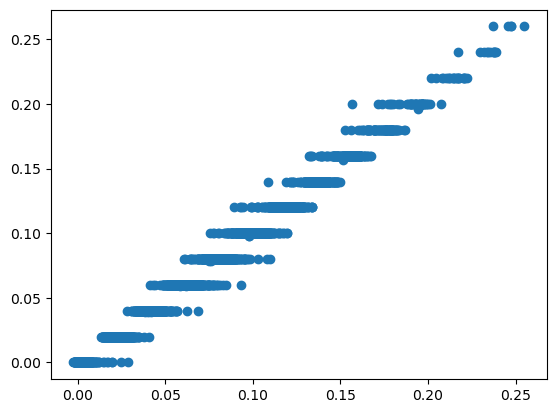

In [163]:
plt.scatter(y_train_pred_sg_xgb, y_train_actual_sg_xgb)
plt.show()

##### **6.6.1.2 Test Data**

In [177]:
# Predicting y_test
y_test_pred_sg_xgb = multi_xgb2.predict(X_test_sg)

# Actual y_test values
y_test_actual_sg_xgb = y_test_sg.values.tolist()

In [179]:
print("R² score:", r2_score(y_test_actual_sg_xgb, y_test_pred_sg_xgb))
print("MSE:", mean_squared_error(y_test_actual_sg_xgb, y_test_pred_sg_xgb))

R² score: 0.5139005780220032
MSE: 0.00040247990856207244


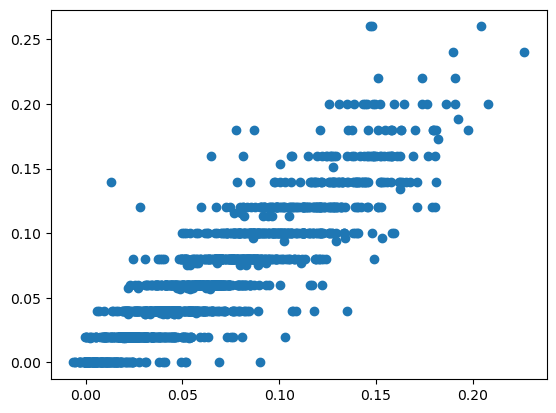

In [181]:
plt.scatter(y_test_pred_sg_xgb, y_test_actual_sg_xgb)
plt.show()

#### 5.7.2 Round #2: Optimising the Model (XGBoost + Targetted X Variables)

Similar to what I did for Japan's data, I will optimise the XGBoost model by including only the weather conditions that seem to have the clearest patterns over time. Our earlier EDA has shown us that the weather metrics with the most pronounced general trends over time are:
- **Relative Humidity**
- **Temperature**
- **Rainfall**

In [183]:
X2_sg = sg_combined[weather_columns_sg_opitimised]
y2_sg = sg_combined.drop(columns=weather_columns_sg + ['snapshot_date'])

X2_train_sg, X2_test_sg, y2_train_sg, y2_test_sg = train_test_split(X2_sg, y2_sg, test_size=0.2, random_state=42)

##### **5.7.2.1 Train Data**

In [185]:
xgb3 = XGBRegressor(n_estimators=20, random_state=42)
multi_xgb3 = MultiOutputRegressor(xgb3)
multi_xgb3.fit(X2_train_sg, y2_train_sg)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=20, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [187]:
# Predicting y_train
y2_train_pred_sg_xgb = multi_xgb3.predict(X2_train_sg)

# Actual y_train values
y2_train_actual_sg_xgb = y2_train_sg.values.tolist()

In [189]:
print("R² score:", r2_score(y2_train_actual_sg_xgb, y2_train_pred_sg_xgb))
print("MSE:", mean_squared_error(y2_train_actual_sg_xgb, y2_train_pred_sg_xgb))

R² score: 0.9302980303764343
MSE: 6.100675379861337e-05


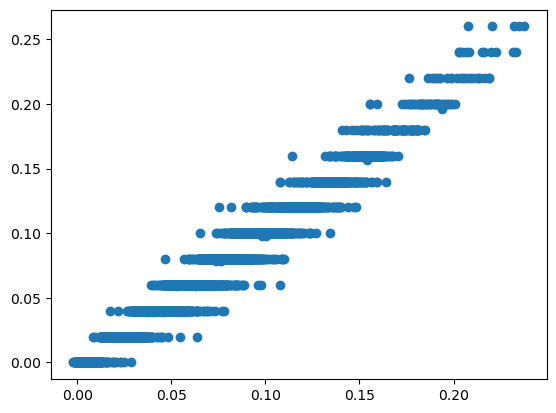

In [193]:
plt.scatter(y2_train_pred_sg_xgb, y2_train_actual_sg_xgb)
plt.show()

##### **5.7.2.2 Test Data**

In [201]:
# Predicting y_train
y2_test_pred_sg_xgb = multi_xgb3.predict(X2_test_sg)

# Actual y_train values
y2_test_actual_sg_xgb = y2_test_sg.values.tolist()

In [203]:
print("R² score:", r2_score(y2_test_actual_sg_xgb, y2_test_pred_sg_xgb))
print("MSE:", mean_squared_error(y2_test_actual_sg_xgb, y2_test_pred_sg_xgb))

R² score: 0.14095789194107056
MSE: 0.0007903543040680876


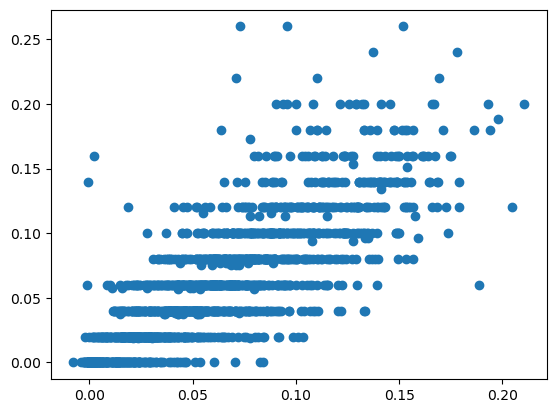

In [205]:
plt.scatter(y2_test_pred_sg_xgb, y2_test_actual_sg_xgb)
plt.show()

#### 5.7.3 Round #3: CatBoost Regression

##### **5.7.3.1 Train Data**

In [11]:
# Initialise the catboost model
catboost = CatBoostRegressor(
    iterations=1000,     # number of boosting rounds
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100          # prints training progress every 100 iterations
)
# Unless we use MultiOutputRegressor, the catboost model can only do single-target regression 
cat_multi_sg = MultiOutputRegressor(catboost)

In [68]:
# We're going to use the original train/test split because we don't want to use the "optimised X variables". We want all the weather measures
cat_multi_sg.fit(X_train_sg, y_train_sg)

0:	learn: 0.0182940	total: 59.9ms	remaining: 59.9s
100:	learn: 0.0077946	total: 169ms	remaining: 1.5s
200:	learn: 0.0050046	total: 282ms	remaining: 1.12s
300:	learn: 0.0033483	total: 406ms	remaining: 942ms
400:	learn: 0.0022613	total: 527ms	remaining: 787ms
500:	learn: 0.0015794	total: 614ms	remaining: 612ms
600:	learn: 0.0010519	total: 722ms	remaining: 479ms
700:	learn: 0.0007298	total: 848ms	remaining: 362ms
800:	learn: 0.0005102	total: 1.06s	remaining: 263ms
900:	learn: 0.0003604	total: 1.23s	remaining: 135ms
999:	learn: 0.0002548	total: 1.33s	remaining: 0us
0:	learn: 0.0470463	total: 1.6ms	remaining: 1.59s
100:	learn: 0.0163849	total: 146ms	remaining: 1.29s
200:	learn: 0.0099719	total: 334ms	remaining: 1.33s
300:	learn: 0.0061038	total: 542ms	remaining: 1.26s
400:	learn: 0.0042795	total: 719ms	remaining: 1.07s
500:	learn: 0.0028937	total: 845ms	remaining: 842ms
600:	learn: 0.0019219	total: 1.12s	remaining: 741ms
700:	learn: 0.0012756	total: 1.24s	remaining: 528ms
800:	learn: 0.0009

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x12d546e40>)

In [72]:
y_train_pred_cat_sg = cat_multi_sg.predict(X_train_sg)
y_train_actual_cat_sg = y_train_sg.values.tolist()

In [88]:
print("(CatB SG Train) R² score:", r2_score(y_train_actual_cat_sg, y_train_pred_cat_sg))
print("(CatB SG Train) MSE:", mean_squared_error(y_train_actual_cat_sg, y_train_pred_cat_sg))

(CatB SG Train) R² score: 0.9998344053868341
(CatB SG Train) MSE: 1.3569225815668403e-07


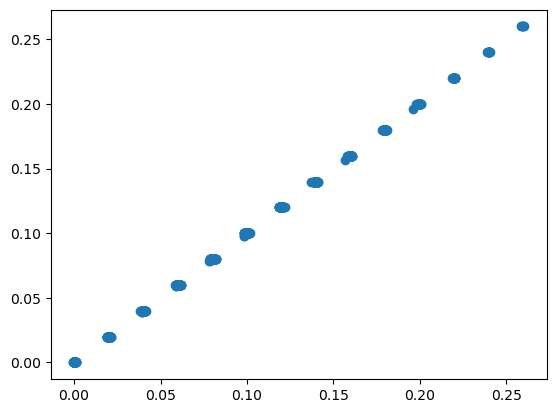

In [78]:
plt.scatter(y_train_pred_cat_sg, y_train_actual_cat_sg)
plt.show()

##### **5.7.3.2 Test Data**

In [86]:
y_test_pred_cat_sg = cat_multi_sg.predict(X_test_sg)
y_test_actual_cat_sg = y_test_sg.values.tolist()

In [92]:
print("(CatB SG Test) R² score:", r2_score(y_test_actual_cat_sg, y_test_pred_cat_sg))
print("(CatB SG Test) MSE:", mean_squared_error(y_test_actual_cat_sg, y_test_pred_cat_sg))

(CatB SG Test) R² score: 0.4998873442142508
(CatB SG Test) MSE: 0.00042166809227148384


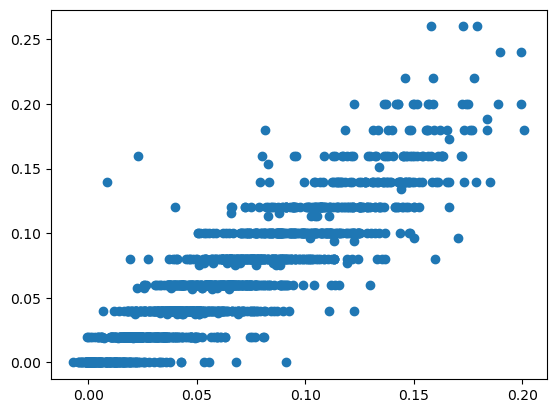

In [94]:
plt.scatter(y_test_pred_cat_sg, y_test_actual_cat_sg)
plt.show()

#### 5.7.3 Performance Review

In [211]:
# Japan XGBoost
print("\033[1mJapan XGBoost\033[0m")
# Train
print("Japan XGB Train R² score:", r2_score(y_train_actual_xgb, y_train_pred_xgb))
print("Japan XGB Train MSE:", mean_squared_error(y_train_actual_xgb, y_train_pred_xgb))
print()
# Test
print("Japan XGB Test R² score:", r2_score(y_test_actual_xgb, y_test_pred_xgb))
print("Japan XGB Test MSE:", mean_squared_error(y_test_actual_xgb, y_test_pred_xgb))
print()
# Japan XGBoost Optimised
print("\033[1mJapan XGBoost Optimised\033[0m")
# Train
print("Japan XGB Optimised Train R² score:", r2_score(y2_train_actual_xgb, y2_train_pred_xgb))
print("Japan XGB Optimised Train MSE:", mean_squared_error(y2_train_actual_xgb, y2_train_pred_xgb))
print()
# Test
print("Japan XGB Optimised Test R² score:", r2_score(y2_test_actual_xgb, y2_test_pred_xgb))
print("Japan XGB Optimised Test MSE:", mean_squared_error(y2_test_actual_xgb, y2_test_pred_xgb))
print()
# Japan CatBoost
print("\033[1mJapan CatBoost\033[0m")
# Train
print("Japan CatBoost Train R² score:", r2_score(y_train_actual_cat, y_train_pred_cat))
print("Japan CatBoost Train MSE:", mean_squared_error(y_train_actual_cat, y_train_pred_cat))
print()
# Test
print("Japan CatBoost Test R² score:", r2_score(y_test_actual_cat, y_test_pred_cat))
print("Japan CatBoost Test MSE:", mean_squared_error(y_test_actual_cat, y_test_pred_cat))
print()
# SG XGBoost
print("\033[1mSG XGBoost\033[0m")
# Train
print("SG XGB Train R² score:", r2_score(y_train_actual_sg_xgb, y_train_pred_sg_xgb))
print("SG XGB Train MSE:", mean_squared_error(y_train_actual_sg_xgb, y_train_pred_sg_xgb))
print()
# Test
print("SG XGB Test R² score:", r2_score(y_test_actual_sg_xgb, y_test_pred_sg_xgb))
print("SG XGB Test MSE:", mean_squared_error(y_test_actual_sg_xgb, y_test_pred_sg_xgb))
print()
# SG XGBoost Optimised
print("\033[1mSG XGBoost Optimised\033[0m")
#Train
print("SG XGB Optimised Train R² score:", r2_score(y2_train_actual_sg_xgb, y2_train_pred_sg_xgb))
print("SG XGB Optimised Train MSE:", mean_squared_error(y2_train_actual_sg_xgb, y2_train_pred_sg_xgb))
print()
#Test
print("SG XGB Optimised Test R² score:", r2_score(y2_test_actual_sg_xgb, y2_test_pred_sg_xgb))
print("SG XGB Optimised Test MSE:", mean_squared_error(y2_test_actual_sg_xgb, y2_test_pred_sg_xgb))
print()
# SG CatBoost
print("\033[1mSG CatBoost\033[0m")
# Train
print("SG CatBoost Train R² score:", r2_score(y_train_actual_cat_sg, y_train_pred_cat_sg))
print("SG CatBoost Train MSE:", mean_squared_error(y_train_actual_cat_sg, y_train_pred_cat_sg))
print()
# Test
print("SG CatBoost Test R² score:", r2_score(y_test_actual_cat_sg, y_test_pred_cat_sg))
print("SG CatBoost Test MSE:", mean_squared_error(y_test_actual_cat_sg, y_test_pred_cat_sg))
print()

Japan XGBoost
Japan XGB Train R² score: 0.9886205196380615
Japan XGB Train MSE: 8.96383221401509e-06

Japan XGB Test R² score: 0.6616260409355164
Japan XGB Test MSE: 0.00032145852481113297

Japan XGBoost Optimised
Japan XGB Optimised Train R² score: 0.9478399753570557
Japan XGB Optimised Train MSE: 4.59923170575347e-05

Japan XGB Optimised Test R² score: 0.338283896446228
Japan XGB Optimised Test MSE: 0.0006314662771147896

Japan CatBoost
Japan CatBoost Train R² score: 0.9999080417689714
Japan CatBoost Train MSE: 7.699474965045235e-08

Japan CatBoost Test R² score: 0.7154141829222558
Japan CatBoost Test MSE: 0.0002632912133004734

SG XGBoost
SG XGB Train R² score: 0.9741390347480774
SG XGB Train MSE: 2.367394943873741e-05

SG XGB Test R² score: 0.5139005780220032
SG XGB Test MSE: 0.00040247990856207244

SG XGBoost Optimised
SG XGB Optimised Train R² score: 0.9302980303764343
SG XGB Optimised Train MSE: 6.100675379861337e-05

SG XGB Optimised Test R² score: 0.14095789194107056
SG XGB Op

## Part 6: Conclusions and Recommendations

### 6.1 Interpretation

In both Japan's and Singapore's cases, creating a reliable model which could accurately predict the proportions of songs from prescribed clusters based on weather conditions proved difficult.

#### Japan
When all weather data was considered, the XGBoost model ultimately faltered when fed the test data, returning an r-squared score of only 0.66. However, when the X variables were optimised to only include columns pertaining to temperature, daylight duration and precipitation, the model performed even worse when fed the test data, at only 0.33.

#### Singapore
When all weather data was considered, the XGBoost model ultimately faltered when fed the test data, returning an r-squared score of only 0.5, lower than the test result for Japan when all weather columns were considered. However, when the X variables were optimised to only include columns pertaining to temperature, daylight duration and precipitation, the model performed even worse when fed the test data, at only 0.14, making the model virtually unusable.

**That neither model based on data from Japan nor Singapore were able to accurately predict the proportion of song clusters based on the day's weather proves that weather alone is inadequate in determining the proportion of song clusters in their daily Top 50 playlists.**

Realistically, the makeup of the Top 50 playlist is determined by a variety of factors, including:
1. The degree of promotion a song is receiving from the recording company that produced it
2. The song's public reception
3. The time of year
   - E.g Christmas songs would experience a spike in popularity during the year-end season

### 6.2 Limitations of Project

1. Inadequate Data
    - In order to find out the correlation between weather conditions and music listening habits, the data used for research must be specific to one geographical boundary. For modelling on Japan's data, **while I could obtain data specific to Tokyo, I could not obtain Spotify data that was specific to Tokyo as well**. I could only fix my geography to Tokyo assuming that with it having the most Spotify users in Japan, Tokyo's listening habits would be reflective of the general Spotify data from Japan at large.
    
    - In addition, **while this whole project carried the assumption that weather conditions did affect users' listening habits to some degree, there was no way of testing this assumption as the data does not account for more granular changes in listening habits or weather (e.g by hour or by minute).**
        - If I had this data, I can truly track the impact of weather conditions on music listening habits by observing how they change the moment the weather changes in a day. This would have been especially useful for Singapore's case, where weather conditions can change sharply within the course of a day (e.g from clear and sunny skies to rainy with dark clouds)

    - Lastly, my project only accounts for one playlist, the Top 50. Even if listening patterns are substantially influenced by the weather, the music data does not account for whether users change to a different playlist when the weather changes.
        - Spotify's platform has a wide variety of playlists that have been curated to suit different themes and moods – for example, the "Lofi Beats" playlist is noted to feature softer, slower and more gentle music which has widely been considered suitable as background music for work or study. With the data I was able to obtain for this project, I was unable to track whether the listenership of a playlist like "Lofi Beats" goes up under certain weather conditions, for example, during winter season in Tokyo or rainy days in Singapore when temperatures are lower and people may want music that is "cozier" feeling.
    
2. Data Limitations
    - During the clustering phase, while I tried my best to obtain the distinct songs from Japan's or Singapore's data, **I noticed that there were still many "duplicates" in the data, in that the same song was appearing in the dataset but under either a different name, a different artist, or even different scores under the music characteristics columns**.
        - These duplicates were very difficult to remove, and seeing that there would be problems with joining the 'cluster' column back to the main dataframe if I filtered out these "duplicates", I decided against removing them. The data would have been slightly less noisy post-clustering if the same song only appeared under the same metadata throughout the period captured.

    - I am unsure of how Spotify's algorithms come to assign scores for each song under the musical columns. **Some songs appeared to carry scores which I did not agree with.**
        - For example, Mariah Carey's "All I Want For Christmas Is You" has a relatively low valence of 0.336 despite it having a very upbeat and joyous mood. This is in comparison with a song like Wham!'s "Last Christmas", which has a higher valence of 0.962. This does not make sense as Carey’s song is clearly the more upbeat between the two, in terms of its subject matter, mood and musical characteristics.

3. Assumptions on Music Listening Habits
    - I initially intended to accurately predict the song a Spotify user in a locality would listen to based on current weather conditions. While this approach would have secured a more concrete model output, it carried the assumption that people would only listen to a specific song based on weather conditions.
        - **This explains why my project involves predicting the proportionality across song clusters rather than predicting a single song at a time, so as to account for how users can listen to anything at any given point in time.**

### 6.3 Recommendations

While this project was an imperfect attempt at building a predictive model for a local weather-based playlist on Spotify, it definitely serves as a proof of concept. 

The model can be augmented with more granular information, including minute-by-minute Spotify and weather data, for better reliability. If the relationship between music listening patterns and weather can be more robustly proven, the data aggregation and modelling processes would also have to adjust accordingly.

My model can provide a recommendation for the proportion of songs from each music style that should make up the playlist based on the day’s weather, but the songs from each cluster which do go into the playlist every day remain undetermined. Should the company be interested in developing the weather-based playlist as a platform feature, discussions must be initiated between various internal stakeholders to decide on what songs to include per day, given the complex web of considerations that go into playlist curation.